## Process txt files

In [ ]:
!pip install pandas


In [2]:
import codecs

In [ ]:
# must run
import xml.etree.ElementTree as xml_parser
import re
import tarfile
from tqdm.auto import tqdm
import json
import os,codecs
from time import sleep
import pandas as pd
import urllib.request as ur
from random import randint



# test download one file 
# !wget ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/5f/a6/PMC7102175.tar.gz

# must run
def get_id_list_by_year_season(year, season=1):

    '''
    reldate
    When reldate is set to an integer n, ELink returns only those items that have a date specified by datetype within the last n days.
    # "cerebral palsy"[MeSH Terms] OR ("cerebral"[All Fields] AND "palsy"[All Fields]) OR "cerebral palsy"[All Fields]
    https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=cerebral+palsy[MeSH+Terms]+OR+cerebral+palsy[All+Fields]+AND+Randomized+Controlled+Trial[Publication+Type]

    '''
    #term1 = "(cerebral+palsy[MeSH+Terms]+OR+cerebral+palsy[All+Fields]+AND+Randomized+Controlled+Trial[Publication+Type])"
    #term2 = "(cerebral+palsy[MeSH+Terms]+OR+cerebral+palsy[All+Fields]+AND+randomized+controlled+trial[All+Fields])"
    #term3 = "(randomized+controlled+trial[All+Fields])"
    #term3 = "(Randomized+Controlled+Trial[Publication+Type])"
    term4 = "(Observational+Study[Publication+Type])"
    term5 = "(Observational+Study%2C+Veterinary[Publication+Type])"
    term6 = term4 + "||" + term5
    term7 = "(Case+Reports[Publication+Type])"
    term8 = "(ffrft[Filter])"
    term9 = "+AND+(humans[Filter])+AND+(english[Filter])"
    term10 = term7 + '+AND+' + term8 + term9
    baseURL = 'http://eutils.ncbi.nlm.nih.gov/entrez/eutils/'
    #filter=pubt.randomizedcontrolledtrial
    #Randomized Controlled Trial[Publication Type]

    reldate=None
    eutil = 'esearch.fcgi?'
    dbParam = 'db=pubmed'#db=pubmed, db=pmc
    usehistoryParam = '&usehistory=y'
    retmode = '&retmode=JSON'
    eutilfetch = 'efetch.fcgi?'
    fieldParam = '&field=title'
    termParam = '&term='+ str(term10)
    reldateParam = '&reldate='+ str(reldate)+'&datetype=edat'
    if season==1:
        mindate='&mindate='+str(year)+'/01/01'
        maxdate='&maxdate='+str(year)+'/03/31'
    elif season==2:
        mindate='&mindate='+str(year)+'/04/01'
        maxdate='&maxdate='+str(year)+'/06/30'
    elif season==3:
        mindate='&mindate='+str(year)+'/07/01'
        maxdate='&maxdate='+str(year)+'/09/30'
    elif season==4:
        mindate='&mindate='+str(year)+'/10/01'
        maxdate='&maxdate='+str(year)+'/12/31'
    else:
        mindate='&mindate='+str(year)+'/01/01'
        maxdate='&maxdate='+str(year)+'/12/31'

        
    #crdt='&crdt=2021'
    retmax = 1000000
    retmaxParam = '&retmax='+str(retmax)
    #retstart = 0
    if reldate is not None and isinstance(reldate, int):
        fullURL = baseURL+eutil+dbParam+fieldParam+termParam+usehistoryParam+retmode+retmaxParam+reldateParam
        print (fullURL)
    else:
        fullURL = baseURL+eutil+dbParam+fieldParam+termParam+usehistoryParam+retmode+retmaxParam+mindate+maxdate
        #print ("Invalid/Empty reldate intput (need to be an INTEGER). Collecting publications from all time ...")
        print(fullURL)

    # =====urllib.error.HTTPError: HTTP Error 400: Bad Request======== dealing with non-ascii url =====
    try:
        fetch = ur.urlopen(fullURL)
    except:
        fullURL = urllib.parse.quote(fullURL,safe=':/') # <- here
        fetch = ur.urlopen(fullURL)

    datam = json.loads(fetch.read().decode('utf-8')) 
    idlist = []
   
    try:
        count = datam['esearchresult']['count']
    except:
        count = None
    if count is not None:
        idlist = datam['esearchresult']['idlist']

    return count, idlist



for i in range(1,3):
  year = i+2010
  count, idlist = get_id_list_by_year_season(year, 2)
  print(f'year {year}: {count}')
  print(len(idlist))
  print(idlist[:20])
  sleep(0.2)


In [ ]:
def save_id_list_season(year_begin, year_end):
    #Yingcheng Update
    #API instructions: https://dataguide.nlm.nih.gov/eutilities/utilities.html
    year = year_begin
    total_count=0
    total_list=[]
    while year <= year_end:
        for season in range(1,5):
            sleep(0.5)
            count,idlist = get_id_list_by_year_season(year, season)
            print(year, count, len(idlist))
            total_count+=len(idlist)

            path="data/"
            os.makedirs(path, exist_ok=True)
            output_dir = os.path.join(os.getcwd(),path+"pmid_"+str(year)+".list")
            outfile = codecs.open(output_dir, "a+")
            for pmid in idlist:
                outfile.write(pmid+"\n")
                total_list.append(int(pmid))

        year += 1 
    print(total_count)
    print(len(set(total_list)))
    
save_id_list_season(1960, 2022)

In [442]:
path = 'data/'
pmidlist= codecs.open(path+'pmid_'+str(2022)+'.list').readlines()
length = len(pmidlist)
print(f'total pmids: {length}')

total pmids: 12437


## Process Text

In [8]:
!ls ../case-report-race-data/text_data/
comm_dir = '../case-report-race-data/text_data/comm/unziped'

non_comm_dir = '../case-report-race-data/text_data/non_comm/unziped'

other_dir = '../case-report-race-data/text_data/other/unziped'

!ls $other_dir

comm     non_comm other
PMC000xxxxxx PMC002xxxxxx PMC004xxxxxx PMC006xxxxxx PMC008xxxxxx
PMC001xxxxxx PMC003xxxxxx PMC005xxxxxx PMC007xxxxxx PMC009xxxxxx


In [9]:
import os, codecs
from tqdm.auto import tqdm
import pandas as pd

In [597]:
txt_files_dict = {}

duplicates_pmcs=[]

def read_pmc_files_dict(txt_files_dict, folder_dir):
    for root, dirs, files in os.walk(folder_dir):
        for afile in files:
            if afile.endswith(".txt"):
                txt_file_name = os.path.basename(afile).replace('.txt', '').strip()
                if txt_file_name in txt_files_dict:
#                     print(txt_file_name+" already exist!")
                    duplicates_pmcs.append(txt_file_name)
                else:
                    txt_files_dict[txt_file_name] = os.path.join(root, afile)
    return txt_files_dict


pmc_dict = read_pmc_files_dict(txt_files_dict, other_dir)
print(len(pmc_dict))
pmc_dict = read_pmc_files_dict(txt_files_dict, comm_dir)
print(len(pmc_dict))
pmc_dict = read_pmc_files_dict(txt_files_dict, non_comm_dir)
print(len(pmc_dict))

print(len(duplicates_pmcs))

435949
3667207
4974288
179


In [11]:
print(len(pmc_dict))

4974288


In [596]:
for k,v in pmc_dict.items():
    print(f'{k},{v}')
    break

PMC8459462,../case-report-race-data/text_data/other/unziped/PMC008xxxxxx/PMC8459462.txt


In [12]:
def get_content_from_file(file_dir):
    f = open(file_dir, 'r', errors='replace') 
    lines = f.readlines()
#     print(lines)
    start_idx = 0
    end_idx = 0
    for idx, line in enumerate(lines):
        if line.startswith('==== Body'):
            start_idx = idx
        elif line.startswith('====') and not line.startswith('==== Front') and idx > start_idx:
            end_idx = idx
            break
        else:
            end_idx = len(lines)-1
#             print('error: '+ k)

#     print(f'{k}\t{start_idx}\t{end_idx}')
    return ' '.join(lines[start_idx+1:end_idx])

In [13]:
for k, v in tqdm(pmc_dict.items()):
    file_dir = v
#     lines = codecs.open(file_dir, encoding='utf-8').readlines() # read the file we downloaded for case reports in US.
    # print(lines)
    print(get_content_from_file(file_dir))
    break

  0%|          | 0/4974288 [00:00<?, ?it/s]

pmc Clinical Implications
 
 Compared with non–eosinophilic gastrotintestinal disease (EGID) coronavirus disease 2019 (COVID-19) positive patients, EGID COVID-19 positive individuals stayed longer in the hospital, yet had a lower hazard of in-patient mortality. This analysis suggests that EGID may provide a protective effect against severe COVID-19 outcomes.
 
 In the United States, the coronavirus disease 2019 (COVID-19) pandemic was the third leading cause of death in 2020.1 Peripheral eosinophilia is hypothesized to play a protective role in COVID-19.2 Yet, little is known about eosinophilic gastrotintestinal disease (EGID) and COVID-19 outcomes. Th2 mucosal responses of patients with EGID may protect against severe effects of COVID-19 by reducing viral entry into cells.3 , 4 We hypothesized that EGID would be protective against severe outcomes in COVID-19 infections. We reviewed administrative data from an extensive central medical system in the United States to identify all COVID-

In [14]:
def load_dict():
    id_mappings_ftp = 'ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/PMC-ids.csv.gz'
    df = pd.read_csv(id_mappings_ftp, dtype=str)
  # df.head()
    keys = df['PMID'].to_list()
    keys = [str(x).strip() for x in keys]
    values = df['PMCID'].to_list()
    values = [y.strip() for y in values]
    dictionary = dict(zip(keys, values))
    return dictionary

def get_pmcid_from_pmid(pmid, dictionary):
    if dictionary is None or len(dictionary)==0:
        print('loading pmid to pmcid dict...')
        dictionary = load_dict()
    else:
        pmid = str(pmid).strip()
        if pmid in dictionary:
            return dictionary[str(pmid)]
        else:
            return None

dictionary = load_dict()

In [15]:
print(len(dictionary))

8060898


In [16]:
for k, v in dictionary.items():
    print(k,v)
    break
    
print(dictionary[str(11056682)])

11250746 PMC13900
PMC13914


In [17]:
found_total_count = 0

for year in range(1960,2023):
    path = 'data/'
#     year = 1960
    print(f'processing year: {year}')
    output_path = path+'haotest/'+str(year)+'/'
    os.makedirs(output_path, exist_ok=True)

    pmid_pmcid_no_found=codecs.open(os.path.join(output_path,"pmid_pmcid_no_found.list"),'w')

    pmid_pmcid_found_no_content=codecs.open(os.path.join(output_path,"pmid_pmcid_found_no_content.list"),'w')

    pmidlist= codecs.open(path+'pmid_'+str(year)+'.list').readlines()
    length = len(pmidlist)
    print(f'total pmids: {length}')

    content_pmids = []

    for pmid in tqdm(pmidlist):
        pmid = str(pmid)
        pmid = pmid.strip()
        pmcid = get_pmcid_from_pmid(pmid, dictionary)
        if pmcid is None:
    #         print(f'cannot find pmcid for pmid: {pmid}, skip')
            pmid_pmcid_no_found.write(str(pmid)+"\n")
            continue
        else:
            if pmcid in pmc_dict:
                file_dir = pmc_dict[pmcid]
                content_pmids.append(pmid)
                content = get_content_from_file(file_dir)
    #             print(content)
                output_dir = os.path.join(os.getcwd(),output_path+str(pmid)+".txt")
                outfile = codecs.open(output_dir, "w")
                outfile.write(content)
                outfile.close()
                found_total_count+=1
            else:
    #             print(f'no content for pmcid: {pmcid}')
                pmid_pmcid_no_found.write(str(pmid)+"\n")


    pmid_pmcid_found_no_content.close()           
    pmid_pmcid_no_found.close()

    print(f'total content pmids: {len(content_pmids)}')
print(f'total content pmids count:{found_total_count}')

processing year: 1960
total pmids: 190


  0%|          | 0/190 [00:00<?, ?it/s]

total content pmids: 2
processing year: 1961
total pmids: 245


  0%|          | 0/245 [00:00<?, ?it/s]

total content pmids: 1
processing year: 1962
total pmids: 179


  0%|          | 0/179 [00:00<?, ?it/s]

total content pmids: 0
processing year: 1963
total pmids: 0


0it [00:00, ?it/s]

total content pmids: 0
processing year: 1964
total pmids: 7


  0%|          | 0/7 [00:00<?, ?it/s]

total content pmids: 5
processing year: 1965
total pmids: 333


  0%|          | 0/333 [00:00<?, ?it/s]

total content pmids: 10
processing year: 1966
total pmids: 770


  0%|          | 0/770 [00:00<?, ?it/s]

total content pmids: 8
processing year: 1967
total pmids: 454


  0%|          | 0/454 [00:00<?, ?it/s]

total content pmids: 5
processing year: 1968
total pmids: 227


  0%|          | 0/227 [00:00<?, ?it/s]

total content pmids: 1
processing year: 1969
total pmids: 188


  0%|          | 0/188 [00:00<?, ?it/s]

total content pmids: 3
processing year: 1970
total pmids: 202


  0%|          | 0/202 [00:00<?, ?it/s]

total content pmids: 0
processing year: 1971
total pmids: 256


  0%|          | 0/256 [00:00<?, ?it/s]

total content pmids: 1
processing year: 1972
total pmids: 184


  0%|          | 0/184 [00:00<?, ?it/s]

total content pmids: 0
processing year: 1973
total pmids: 146


  0%|          | 0/146 [00:00<?, ?it/s]

total content pmids: 2
processing year: 1974
total pmids: 185


  0%|          | 0/185 [00:00<?, ?it/s]

total content pmids: 3
processing year: 1975
total pmids: 786


  0%|          | 0/786 [00:00<?, ?it/s]

total content pmids: 3
processing year: 1976
total pmids: 1471


  0%|          | 0/1471 [00:00<?, ?it/s]

total content pmids: 16
processing year: 1977
total pmids: 1649


  0%|          | 0/1649 [00:00<?, ?it/s]

total content pmids: 18
processing year: 1978
total pmids: 1503


  0%|          | 0/1503 [00:00<?, ?it/s]

total content pmids: 8
processing year: 1979
total pmids: 1625


  0%|          | 0/1625 [00:00<?, ?it/s]

total content pmids: 9
processing year: 1980
total pmids: 1713


  0%|          | 0/1713 [00:00<?, ?it/s]

total content pmids: 18
processing year: 1981
total pmids: 1836


  0%|          | 0/1836 [00:00<?, ?it/s]

total content pmids: 13
processing year: 1982
total pmids: 1992


  0%|          | 0/1992 [00:00<?, ?it/s]

total content pmids: 21
processing year: 1983
total pmids: 2097


  0%|          | 0/2097 [00:00<?, ?it/s]

total content pmids: 22
processing year: 1984
total pmids: 2237


  0%|          | 0/2237 [00:00<?, ?it/s]

total content pmids: 17
processing year: 1985
total pmids: 2209


  0%|          | 0/2209 [00:00<?, ?it/s]

total content pmids: 31
processing year: 1986
total pmids: 2126


  0%|          | 0/2126 [00:00<?, ?it/s]

total content pmids: 41
processing year: 1987
total pmids: 2366


  0%|          | 0/2366 [00:00<?, ?it/s]

total content pmids: 54
processing year: 1988
total pmids: 2402


  0%|          | 0/2402 [00:00<?, ?it/s]

total content pmids: 63
processing year: 1989
total pmids: 2520


  0%|          | 0/2520 [00:00<?, ?it/s]

total content pmids: 64
processing year: 1990
total pmids: 2700


  0%|          | 0/2700 [00:00<?, ?it/s]

total content pmids: 75
processing year: 1991
total pmids: 2799


  0%|          | 0/2799 [00:00<?, ?it/s]

total content pmids: 84
processing year: 1992
total pmids: 2928


  0%|          | 0/2928 [00:00<?, ?it/s]

total content pmids: 79
processing year: 1993
total pmids: 2965


  0%|          | 0/2965 [00:00<?, ?it/s]

total content pmids: 86
processing year: 1994
total pmids: 3118


  0%|          | 0/3118 [00:00<?, ?it/s]

total content pmids: 84
processing year: 1995
total pmids: 3491


  0%|          | 0/3491 [00:00<?, ?it/s]

total content pmids: 66
processing year: 1996
total pmids: 3758


  0%|          | 0/3758 [00:00<?, ?it/s]

total content pmids: 102
processing year: 1997
total pmids: 3617


  0%|          | 0/3617 [00:00<?, ?it/s]

total content pmids: 102
processing year: 1998
total pmids: 4067


  0%|          | 0/4067 [00:00<?, ?it/s]

total content pmids: 115
processing year: 1999
total pmids: 4267


  0%|          | 0/4267 [00:00<?, ?it/s]

total content pmids: 177
processing year: 2000
total pmids: 4626


  0%|          | 0/4626 [00:00<?, ?it/s]

total content pmids: 144
processing year: 2001
total pmids: 4978


  0%|          | 0/4978 [00:00<?, ?it/s]

total content pmids: 212
processing year: 2002
total pmids: 5422


  0%|          | 0/5422 [00:00<?, ?it/s]

total content pmids: 223
processing year: 2003
total pmids: 5954


  0%|          | 0/5954 [00:00<?, ?it/s]

total content pmids: 290
processing year: 2004
total pmids: 6163


  0%|          | 0/6163 [00:00<?, ?it/s]

total content pmids: 373
processing year: 2005
total pmids: 6834


  0%|          | 0/6834 [00:00<?, ?it/s]

total content pmids: 501
processing year: 2006
total pmids: 7907


  0%|          | 0/7907 [00:00<?, ?it/s]

total content pmids: 617
processing year: 2007
total pmids: 8514


  0%|          | 0/8514 [00:00<?, ?it/s]

total content pmids: 880
processing year: 2008
total pmids: 8644


  0%|          | 0/8644 [00:00<?, ?it/s]

total content pmids: 951
processing year: 2009
total pmids: 9504


  0%|          | 0/9504 [00:00<?, ?it/s]

total content pmids: 1106
processing year: 2010
total pmids: 11234


  0%|          | 0/11234 [00:00<?, ?it/s]

total content pmids: 1552
processing year: 2011
total pmids: 12523


  0%|          | 0/12523 [00:00<?, ?it/s]

total content pmids: 1694
processing year: 2012
total pmids: 13741


  0%|          | 0/13741 [00:00<?, ?it/s]

total content pmids: 1880
processing year: 2013
total pmids: 15832


  0%|          | 0/15832 [00:00<?, ?it/s]

total content pmids: 2655
processing year: 2014
total pmids: 16200


  0%|          | 0/16200 [00:00<?, ?it/s]

total content pmids: 3556
processing year: 2015
total pmids: 15529


  0%|          | 0/15529 [00:00<?, ?it/s]

total content pmids: 4099
processing year: 2016
total pmids: 14963


  0%|          | 0/14963 [00:00<?, ?it/s]

total content pmids: 4664
processing year: 2017
total pmids: 15996


  0%|          | 0/15996 [00:00<?, ?it/s]

total content pmids: 5807
processing year: 2018
total pmids: 17154


  0%|          | 0/17154 [00:00<?, ?it/s]

total content pmids: 6913
processing year: 2019
total pmids: 17313


  0%|          | 0/17313 [00:00<?, ?it/s]

total content pmids: 7675
processing year: 2020
total pmids: 20453


  0%|          | 0/20453 [00:00<?, ?it/s]

total content pmids: 11512
processing year: 2021
total pmids: 17430


  0%|          | 0/17430 [00:00<?, ?it/s]

total content pmids: 11297
processing year: 2022
total pmids: 12437


  0%|          | 0/12437 [00:00<?, ?it/s]

total content pmids: 8572
total content pmids count:78582


In [590]:
dictionary[str(27959684)]

'PMC5178827'

In [591]:
pmcid='PMC5178827'
pmc_dict[pmcid]

KeyError: 'PMC5178827'

In [ ]:
https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&id=27959684&retmode=XML

## Extract race info

In [18]:
folder_dir = 'data/haotest/'
files_dict ={}
for root, dirs, files in os.walk(folder_dir):
        for afile in files:
            if afile.endswith(".txt"):
                txt_file_name = os.path.basename(afile).replace('.txt', '').strip()
                files_dict[txt_file_name] = os.path.join(root, afile)
                

print(len(files_dict))

78669


In [1017]:
import re

subjects = 'girl|boy|patient|american|american|child|children|participants|girls|boys|patients|americans|male|males|female|females|participant|woman|women|man|men|subject|subjects|islander|islanders|native|natives|mother|mothers|father|fathers|soldier|soldiers|infant|infants'

sub_patterns = r'((?:\S+\s+){0,5}\b'+f'({subjects})'+r'\b\s*(?:\S+\b\s*){0,5})'

# sub_patterns = r'((?:\S+\s+){0,3}\b'+f'({subjects}))'

print(sub_patterns)

text_all = 'A 5-year-old man and turkish boy and hawaiian islanders was admitted to the hospital with chest tightness and palpitations which persisted for 2 years.'

matches = re.findall(sub_patterns, text_all.lower())

print(matches)
for match in matches:
    print(match)


def get_subjects(text_all):
    matches = re.findall(sub_patterns, text_all.lower())
    results = []
    for match in matches:
        s = ''.join(match[0])
        s = re.sub("\s+", " ", s)
        results.append(s)
    return results


print(get_subjects(text_all))



((?:\S+\s+){0,5}\b(girl|boy|patient|american|american|child|children|participants|girls|boys|patients|americans|male|males|female|females|participant|woman|women|man|men|subject|subjects|islander|islanders|native|natives|mother|mothers|father|fathers|soldier|soldiers|infant|infants)\b\s*(?:\S+\b\s*){0,5})
[('a 5-year-old man and turkish boy and hawaiian islanders was admitted ', 'boy')]
('a 5-year-old man and turkish boy and hawaiian islanders was admitted ', 'boy')
['a 5-year-old man and turkish boy and hawaiian islanders was admitted ']


In [1043]:
black_races_terms = 'black|south african|north african|caribbean|east african|north african|south african|west african|african|ghanaian|akan|nigerian'

# black_patterns = f'({black_races_terms})([\w\s]'+'{,10})'+f'({subjects})'

black_patterns = f'\W({black_races_terms})'+r'([\b\s*(?:\S+\b\s*)]{0,10}?\b)'+f'({subjects})\W'

text_all = 'A 65-year-old black woman, and african american girl was admitted to the hospital with chest tightness and palpitations which persisted for 2\xa0years. The patient had a free past medical history, and denied any other relevant personal or family history. '

def get_black_races(text_all):
    matches = re.findall(black_patterns, text_all.lower())
    results = []
    for match in matches:
        results.append(''.join(match))
    return results


print(get_black_races(text_all))



['black woman', 'african american']


In [1044]:
white_races_terms = 'white|portuguese|french|british|european|lebanese|syrian|russian|caucasian|german|polish|ukrainian|arab|italian|english|irish|roma|scottish|welsh|turkish|algerian|iranian|moroccan|saudi|greek|omani|finnish|iraqi|milan|belgian|afghan|danish'

# white_patterns = f'({white_races_terms})([\w\s]'+'{,10})'+f'({subjects})'

white_patterns = f'\W({white_races_terms})'+r'([\b\s*(?:\S+\b\s*)]{0,10}?\b)'+f'({subjects})\W'
# print(white_patterns)

text_all = 'A 65-year-old danish man was admitted to the hospital with chest tightness and palpitations which persisted for 2\xa0years. The patient had a free past medical history, and denied any other relevant personal or family history. '

def get_white_races(text_all):
    matches = re.findall(white_patterns, text_all.lower())
    results = []
    for match in matches:
        results.append(''.join(match))
    return results


print(get_white_races(text_all))

['danish man']


In [1063]:
asian_races_terms = 'bangladeshi|bengali|cambodian|chinese|indian|malaysian|pakistani|filipino|thai|cambodia|china|india|japan|japanese|korea|korean|malaysia|pakistan|philippine|thailand|vietnam|vietnamese|taiwanese|asian|sri lankan|philippino'

# asian_patterns = f'({asian_races_terms})([\w\s]'+'{,10})'+f'({subjects})'

asian_patterns = f'\W({asian_races_terms})'+r'([\b\s*(?:\S+\b\s*)]{0,10}?\b)'+f'({subjects})\W'

text_all = 'A 23 years old caucasian man, and 65-year-old taiwanese woman and a 30-year-old bangladeshi-bengali female was admitted to the hospital with chest tightness and palpitations which persisted for 2\xa0years. The patient had a free past medical history, and denied any other relevant personal or family history. '

def get_asian_races(text_all):
    matches = re.findall(asian_patterns, text_all.lower())
    results = []
    for match in matches:
        results.append(''.join(match))
    return results


print(get_asian_races(text_all))

# matches = re.findall(patterns, text_all.lower())

# for match in matches:
#     print(''.join(match))

['taiwanese woman', 'bangladeshi-bengali female']


In [1046]:
latino_races_terms = 'latino|latina|latinx|latin|pashtun|hispanic|cuban|mexican|puerto rican|south american|central american|spanish|brazilian|brazil'

# latino_patterns = f'({latino_races_terms})([\w\s]'+'{,10})'+f'({subjects})'

latino_patterns = f'\W({latino_races_terms})'+r'([\b\s*(?:\S+\b\s*)]{0,10}?\b)'+f'({subjects})\W'


text_all = 'A 65-year-old brazilian man was admitted to the hospital with chest tightness and palpitations which persisted for 2\xa0years. The patient had a free past medical history, and denied any other relevant personal or family history. '

def get_latino_races(text_all):
    matches = re.findall(latino_patterns, text_all.lower())
    results = []
    for match in matches:
        results.append(''.join(match))
    return results


print(get_latino_races(text_all))

# matches = re.findall(patterns, text_all.lower())

# for match in matches:
#     print(''.join(match))

['brazilian man']


In [1047]:
american_indian_terms = 'aboriginal|amerindian|indigenous|american indian'

american_indian_patterns = f'\W({american_indian_terms})'+r'([\b\s*(?:\S+\b\s*)]{0,10}?\b)'+f'({subjects})\W'

text_all = 'A 65-year-old american indian woman, and two indigenous girls, was admitted to the hospital with chest tightness and palpitations which persisted for 2\xa0years. The patient had a free past medical history, and denied any other relevant personal or family history. '

def get_ameindian_races(text_all):
    matches = re.findall(american_indian_patterns, text_all.lower())
    results = []
    for match in matches:
        results.append(''.join(match))
    return results


print(get_ameindian_races(text_all))

# matches = re.findall(patterns, text_all.lower())

# for match in matches:
#     print(''.join(match))

['american indian woman', 'indigenous girls']


In [1048]:
# Native Hawaiian or Other Pacific Islander
# Hawaiian
# Guamanian
# Samoan

islander_terms = 'hawaiian|hawaii|samoan|guamanian'

islander_patterns = f'\W({islander_terms})'+r'([\b\s*(?:\S+\b\s*)]{0,10}?\b)'+f'({subjects})\W'

text_all = 'A 65-year-old american samoan woman and two five year hawaiian islanders, was admitted to the hospital with chest tightness and palpitations which persisted for 2\xa0years. The patient had a free past medical history, and denied any other relevant personal or family history. '

def get_islander_races(text_all):
    matches = re.findall(islander_patterns, text_all.lower())
    results = []
    for match in matches:
        results.append(''.join(match))
    return results


print(get_islander_races(text_all))

# matches = re.findall(patterns, text_all.lower())

# for match in matches:
#     print(''.join(match))


['samoan woman', 'hawaiian islanders']


In [1049]:
def get_races_all(text_all):
    race_list = []
    race_type = []
    if len(get_black_races(text_all))>0:
        race_list.extend(get_black_races(text_all))
        race_type.append('black')
    if len(get_white_races(text_all))>0:
        race_list.extend(get_white_races(text_all))
        race_type.append('white')
    if len(get_ameindian_races(text_all))>0:
        race_list.extend(get_ameindian_races(text_all))
        race_type.append('ameindian')
    if len(get_latino_races(text_all))>0:
        race_list.extend(get_latino_races(text_all))
        race_type.append('latino')
    if len(get_asian_races(text_all))>0:
        race_list.extend(get_asian_races(text_all))
        race_type.append('asian')
    if len(get_islander_races(text_all))>0:
        race_list.extend(get_islander_races(text_all))
        race_type.append('islander')
    return list(set(race_list)), list(set(race_type))

text_all = 'A 65-year-old hawaiian woman and a turkish boy were admitted to the hospital with chest tightness and palpitations which persisted for 2\xa0years. The patient had a free past medical history, and denied any other relevant personal or family history. '
race_list, race_type = get_races_all(text_all)
print(race_list)
print(race_type)


print(get_subjects(text_all))

['turkish boy', 'hawaiian woman']
['white', 'islander']
['a 65-year-old hawaiian woman and a turkish boy were ', 'persisted for 2 years. the patient had a free past medical ']


In [1050]:
df_list =[]

for pmid, file_dir in tqdm(files_dict.items()):
#     print(k)
#     print(file_dir)
    no_race = False
    no_text = False
    race_info = None
    subject_info = None
    race_type = 'NA'
    f = open(file_dir,  'r', errors='replace') 
    lines = f.readlines()
#     print(lines)
    if len(lines)>0:
        text_all = ' '.join(lines)
        race_info, race_type = get_races_all(text_all)
        subject_info = get_subjects(text_all)
        if len(race_info)>0:
            print(race_info)  
        else:
#             print('no race info')
            no_race=True
#             if len(subject_info)>0:
#                 print(subject_info)
    else:
#         print('no text')
        no_text= True
        no_race = True
    adflist=[pmid, race_info, race_type, subject_info, no_race, no_text]
    df_list.append(adflist)
        

  0%|          | 0/78669 [00:00<?, ?it/s]

['caucasian male', 'caucasian female']
['japanese male']
['china\tfemale', 'china\tmale']
['brazilian woman']
['japanese male']
['japanese female']
['hispanic female']
['white male']
['caucasian man']
['hispanic male']
['korea). the patient']
['moroccan male']
['white male']
['chinese woman']
['japanese man']
['caucasian male', 'caucasian woman']
['caucasian woman', 'brazilian woman']
['hispanic male']
['korean girl']
['japanese woman']
['caucasian male']
['european patient', 'caucasian female']
['caucasian man']
['african americans', 'blacks, 30% of men', 'african american']
['japanese male']
['asian female']
['mexican patients', 'caucasian patients']
['chinese man']
['african american']
['japanese patients']
['white female']
['chinese girl']
['japan, 64 patients', 'japan, 61 patients', 'japan, 59 patients', 'japan, 1 patient']
['chinese woman']
['white male']
['french patients']
['european/māori girl']
['korean scz patients']
['iranian\xa0man']
['moroccan male']
['japanese children']

['italian woman']
['sri lankan woman']
['caucasian man']
['italian patients']
['white patients', 'black/african american']
['african american']
['chinese woman']
['chinese woman']
['white woman']
['white males', 'black african males', 'white female', 'black african patients', 'white females', 'white male', 'south african women', 'white patients', 'black african females', 'black african female']
['japanese woman']
['hispanic female', 'filipino female']
['black americans']
['caucasian male', 'caucasian man', 'white men']
['japanese man']
['korean man']
['iranian boy']
['african americans']
['latin american']
['chinese woman']
['chinese patients', 'chinese rsts patient', 'chinese rsts patients', 'chinese boy']
['indian woman']
['korea (3)\tpatient', 'korea (4)\tpatient']
['chinese man']
['malaysian woman']
['caucasian women']
['korean boy']
['pakistani girl']
['german child']
['japanese woman']
['japanese patients', 'japan, 28% of children', 'japan for patients']
['caucasian male']
['afri

['asian women', 'asian patient']
['caucasian male']
['latin american', 'chinese patients']
['chinese woman']
['italian) male']
['greek\xa0woman']
['chinese patient']
['caucasian male']
['caucasian woman']
['african/african‐american']
['african american']
['caucasian male']
['chinese woman']
['spanish man']
['iranian\xa0man']
['caucasian man']
['caucasian woman']
['korean military men', 'romanian man']
['caucasian female']
['caucasian woman']
['african americans', 'caucasian/african americans', 'english patient', 'caucasian male']
['white man']
['asian/pacific islanders']
['asian children', 'japanese woman']
['japanese patient', 'japanese woman']
['chinese male']
['germany) in the patient', 'italian woman']
['chinese patient']
['japanese woman']
['black male']
['spanish native']
['belgian patient']
['polish participants', 'spanish participants']
['chinese woman']
['thai female']
['india.19 patients']
['indian male']
['japanese\xa0male']
['indian male']
['asian men', 'japanese woman']
['

['thai patients']
['caucasian woman']
['arab patients', 'saudi female', 'korean patients', 'chinese healthy subjects']
['germany). the patient']
['iranian man']
['japan. this patient']
['chinese woman']
['sri lankan patient']
['caribbean woman', 'caribbean male']
['chinese male']
['chinese woman']
['chinese man']
['iraqi-born man']
['asian boy']
['germany). both patients']
['white man']
['china\tn = 1\tmale', 'korea\tn = 1\tfemale', 'korea\tn = 1\tmale', 'korea\tn = 2\tmale', 'china\tn = 66\tmales']
['european and american']
['caucasian male']
['black female']
['japanese woman']
['korea, in patients', 'chinese patients']
['indian boy']
['caucasian woman']
['white female']
['chinese girl']
['caucasian woman']
['african americans']
['caucasian male']
['chinese man']
['chinese woman']
['african americans']
['japanese man']
['japanese mother', 'chinese mothers']
['italian children']
['pakistani female', 'european patients', 'filipino female']
['caucasian man']
['brazilian male']
['chinese 

['japanese man']
['asian man', 'asian male']
['chinese male']
['chinese female']
['japanese man']
['nigerian-american']
['caucasian man']
['japanese girl']
['spanish patients']
['chinese man']
['asian woman']
['japanese woman']
['japanese man']
['italian girl']
['german patient']
['white man']
['pakistan. the mother']
['caucasian male']
['japan to a patient']
['caucasian male']
['japanese man']
['chinese patients', 'chinese pord patients']
['chinese female']
['caucasian woman']
['taiwanese woman']
['caucasian girl']
['caucasian male']
['asian patients']
['italian male']
['asian girl']
['hispanic male']
['south african zulu woman']
['asian woman']
['asian patients']
['irish male', 'caucasian irish male']
['iranian patients']
['japanese woman']
['chinese man']
['caucasian woman']
['japanese woman']
['indian woman']
['asian patients']
['french child']
['asian girls', 'chinese patient']
['arabic female']
['china) on subject']
['japanese woman']
['caucasian, male']
['white male']
['korean m

['japanese man']
['pakistani male']
['korean male']
['chinese woman']
['korean female']
['japanese woman']
['german patient']
['japanese man']
['white woman']
['saudi man']
['china. the patient']
['indian patient', 'british (0.83%), american', 'korean patients', 'pakistani patient']
['indian female']
['japanese man']
['chinese man']
['japanese man']
['caucasian female']
['african american']
['chinese man']
['caucasian girl']
['caucasian male']
['japanese mother']
['japanese woman']
['italian boy']
['latin american', 'korean patients']
['japan, patients']
['chinese patient']
['hispanic women']
['african american']
['african americans', 'african american']
['japanese man']
['pakistani origin male']
['japanese females', 'hispanic female']
['japanese woman']
['japanese male']
['caucasian man']
['chinese boy', 'chinese children']
['taiwanese male']
['japanese man']
['indian woman']
['chinese patients']
['japanese woman']
['japan for a patient']
['spanish patients', 'black patients', 'hispan

['caucasian woman']
['caucasian woman']
['japanese man']
['white woman']
['european cgl patient']
['chinese man']
['iranian adpkd patients']
['caucasian male', 'caucasian female', 'caucasian woman']
['japanese woman']
['japanese man']
['caucasian patient']
['caucasian male']
['brazil. all patients']
['japan [3]. the patient', 'chinese male']
['caucasian, italian female']
['white female']
['japanese woman']
['black male', 'black\n  patients']
['caucasian man']
['caucasian infant']
['germany. the patient']
['caucasian woman']
['white man', 'african american']
['french woman', 'caucasian woman']
['chinese woman']
['caucasian male']
['chinese woman']
['indian boy']
['chinese woman']
['italian ats patients', 'italian patient', 'italian boy']
['india. all patients']
['chinese man']
['chinese woman']
['caucasian woman']
['japanese man']
['korean male', 'asian subjects']
['white female']
['asian patients']
['german man']
['african woman']
['caucasian woman']
['latin american', 'asians and nati

['chinese patient']
['white bars. * patient']
['chinese girls']
['korean patients']
['pakistani young man']
['japanese female']
['turkish man']
['japanese woman']
['sri lankan man']
['african american']
['sri lankan male']
['caucasian male']
['korean male']
['chinese patient']
['caucasian woman']
['chinese woman']
['caucasian woman']
['caucasian man']
['chinese male']
['caucasian male', 'caucasian female']
['white, women', 'white women']
['korean children']
['asian woman']
['japan, one patient', 'caucasian female']
['caucasian male']
['chinese woman']
['asian/pacific islander']
['caucasian female']
['caucasian man']
['european subjects']
['asian patients']
['french patient']
['japanese woman']
['sri lankan girl']
['white male']
['turkish male']
['hispanic young man']
['caucasian female']
['asian female']
['japanese female']
['caucasian male']
['caucasian woman']
['italian girl']
['chinese man']
['caucasian man']
['korean man']
['japanese man']
['chinese males']
['brazilian female']
['c

['african american']
['japanese woman']
['caucasian man', 'african-americans']
['caucasian female']
['white woman']
['japanese man']
['japan. the patient', 'japanese man']
['caucasian man']
['korean male', 'korean man']
['caucasian woman']
['asian children', 'chinese children']
['caucasian woman']
['japanese patient']
['japanese male']
['korean man']
['caucasian man']
['caucasian woman']
['hispanic male']
['african children']
['turkish woman']
['caucasian woman']
['caucasian man']
['hawaiian-pacific islander', 'african american']
['chinese boy']
['caucasian female']
['chinese woman']
['caucasian female', 'asian female']
['indian patients', 'caucasian patients']
['japanese male']
['black man', 'brazilian black man']
['thai man']
['caucasian man']
['white female']
['indian woman']
['caucasian woman']
['japanese man']
['caucasian woman']
['japanese patients']
['white female']
['germany). the patient']
['saudi woman']
['italian ks children']
['italian man', 'italian woman', 'chinese patien

['caucasian, male']
['japanese woman']
['caucasian female']
['caribbean girl', 'indian boy']
['european female']
['japanese woman']
['japanese male', 'japanese female']
['japan\t57\tfemale', 'thailand\t4\tfemale', 'china. the patient', 'japan\t68\tmale', 'china\t7\tfemale']
['japanese man']
['japanese) woman']
['korean woman', 'turkish male']
['caucasian man']
['asian male']
['japanese patient']
['caucasian woman']
['caucasian patient']
['vietnam was a male']
['chinese boy', 'chinese male', 'chinese patient', 'chinese boys']
['chinese girl', 'brazilian bss patient']
['chinese male']
['germany). the patient']
['caucasian male']
['chinese children']
['african americans', 'caucasian patients']
['chinese patient', 'chinese male']
['black/african american', 'african american']
['caucasian male', 'caucasian man']
['chinese men']
['japanese man', 'korean patients', 'japanese woman']
['asian american', 'asian woman']
['japanese male']
['japanese children']
['japanese woman']
['greek female', '

['chinese aosd patients', 'taiwanese female']
['chinese adult patients']
['pakistani\xa0woman']
['white man']
['turkish jewish/mother', 'japanese patients', 'japanese and american']
['european woman']
['japanese woman']
['chinese woman']
['caucasian female']
['caucasian man']
['indian man']
['chinese patients']
['asian female']
['korean woman']
['filipino patient', 'japanese woman', 'filipino woman']
['amerindian patients', 'amerindian patient']
['black subjects']
['caucasian woman']
['japanese woman']
['japanese girl']
['thai man']
['arab male']
['african american']
['japanese boy']
['germany female', 'chinese man']
['japanese male']
['caucasian man']
['japanese man']
['white children', 'black women']
['chinese woman']
['african male']
['asian female']
['caucasian male']
['latin american']
['india (for infant']
['japanese patient', 'caucasian patient', 'latin patient']
['japanese woman']
['japanese man']
['hispanic, married woman', 'hispanic, widowed woman']
['japanese man']
['caucasi

['european and american']
['caucasian man']
['japanese man']
['korean male']
['chinese male']
['chinese patient']
['taiwanese man']
['european subjects']
['caucasian male']
['caucasian male']
['china, the patient']
['caucasian women']
['japanese woman']
['turkish girl']
['caucasian boy', 'caucasian woman']
['african black male']
['chinese woman']
['caucasian female']
['hispanic female']
['african woman']
['japanese woman']
['white arabian woman']
['caucasian man']
['white male']
['chinese man']
['caucasian men']
['african-american']
['polish registry patients']
['taiwanese man']
['caucasian female']
['saudi male']
['caucasian patients', 'african-american']
['white male']
['caucasian female']
['british woman']
['white woman']
['chinese women']
['chinese control subjects']
['european man']
['japanese man']
['japanese patient']
['caucasian woman']
['caucasian female']
['caucasian female']
['caucasian male']
['japanese woman']
['caucasian boy', 'caucasian man']
['arabian woman']
['korean w

['white woman']
['japanese man']
['indian women', 'indian woman']
['caucasian male']
['turkish female']
['caucasian male']
['chinese woman']
['caucasian woman']
['white male']
['white male']
['japanese girl']
['caucasian patients']
['chinese man']
['asian man']
['chinese boy']
['white man']
['caucasian woman', 'caucasian man']
['japanese male', 'japanese woman']
['hispanic mother']
['bangladeshi girl']
['greek woman']
['saudi male', 'saudi patient']
['japanese man']
['white man']
['white man']
['china. the patient']
['korean patient', 'asian subjects']
['japanese girl', 'japanese woman']
['white female']
['caucasian male', 'asian patients']
['caucasian woman']
['korean male']
['portuguese patients']
['japanese female']
['caucasian boy']
['japanese patients', 'japanese man']
['korean boy', 'chinese children']
['sri lankan moor woman']
['chinese male']
['caucasian man']
['japanese man']
['caucasian male', 'caucasian female']
['caucasian female', 'caucasian patient']
['caucasian male']
['

['caucasian male']
['white man', 'white woman']
['white male']
['spanish patient', 'moroccan patients']
['caucasian woman']
['japan. the patient']
['japanese woman']
['japanese woman']
['latin american']
['japanese woman']
['chinese male']
['caucasian man']
['caucasian women', 'caucasian woman']
['pakistani man']
['african american']
['korean man']
['sri lankan man']
['japanese man']
['china.12 the patient']
['caucasian woman']
['latin american']
['chinese female']
['caucasian girl']
['european american']
['caucasian man']
['hispanic americans']
['saudi infant']
['chinese children']
['chinese man']
['white male']
['african patients']
['asian female']
['caucasian girl']
['japanese boy', 'taiwanese teenager patient']
['japanese woman']
['japanese boy', 'japanese patient']
['caucasian patient']
['caucasian man']
['chinese kabuki patients', 'chinese children', 'china and children', 'china. those patients', 'chinese patients', 'japanese children']
['korean children', 'greek man', 'caucasian

['black patients']
['brazil-born woman']
['korean male', 'european patients']
['germany, a man']
['african american']
['white (6 patients']
['japanese man']
['arab patient']
['african american']
['sri lankan sinhala male']
['caucasian woman']
['chinese patient']
['white woman']
['caucasian female']
['caucasian man']
['turkish patient']
['african males']
['chinese male']
['korean woman']
['korean patients']
['chinese female']
['french mother']
['japanese male']
['caucasian woman']
['chinese male']
['korea, patients', 'korean girl']
['caucasian female', 'french patients']
['belgian woman']
['turkish patient', 'turkish subjects', 'turkish children']
['african–american']
['korea of a patient']
['north african woman']
['japanese male']
['chinese patient']
['japanese women']
['greek male']
['korean man']
['moroccan woman']
['japanese patients']
['japanese woman']
['caucasian man']
['chinese patients', 'asian patient', 'chinese female']
['chinese patients']
['caucasian female']
['caucasian ma

['saudi child']
['caucasian subjects']
['african american']
['saudi male']
['korean patient']
['korea, nine patients']
['korean man']
['arabian female']
['hispanic male']
['black subjects']
['caucasian woman']
['germany). the patient']
['korean woman', 'korean patient', 'korea. our patient']
['germany in a patient']
['korean woman']
['chinese patients']
['south african women', 'mexican women']
['saudi male', 'saudi female']
['korean woman']
['latin american']
['puerto rican male']
['chinese boy']
['korean man']
['saudi man']
['white. all patients']
['caucasian male', 'caucasian female', 'african american']
['african father']
['korean woman', 'korean women', 'hispanic women']
['french man']
['french soldier', 'french soldiers']
['saudi female', 'british woman']
['hispanic female']
['caucasian man']
['european boys']
['saudi female', 'saudi male']
['german infant']
['caucasian male', 'caucasian\n  male']
['aboriginal girl']
['saudi girl', 'saudi child']
['white female']
['korean patients

['white female', 'white male']
['italian patients', 'japanese man']
['caucasian man']
['black woman']
['saudi patients']
['caucasian woman']
['white female']
['caucasian male']
['germany). all patients']
['korea\n  \n  *male']
['japanese man']
['hispanic female']
['white man']
['japanese woman']
['caucasian female', 'caucasian. the patient']
['british girl']
['caucasian man']
['chinese males']
['caucasian male']
['hispanic woman']
['filipino male']
['caucasian female']
['white female', 'white male', 'asian males', 'african-american', 'african american']
['african-american']
['caucasian male', 'latin americans']
['caucasian male', 'indian man']
['caucasian male']
['saudi infant']
['black male']
['japanese male', 'japanese female']
['white man']
['korean patients', 'korean fop patients']
['japanese patient']
['korean women']
['african man']
['caucasian males']
['korean female', 'korean hht patients', 'korean patients']
['african americans']
['bangladeshi male', 'french soldiers']
['cauca

['african-american']
['hispanic girl']
['japanese woman']
['caucasian woman']
['chinese women']
['white woman']
['brazilian patients']
['asian man']
['chinese nsclc patient']
['japanese man']
['japanese man']
['ghanaian girl']
['chinese boy', 'chinese patient']
['black female']
['black woman']
['japanese man']
['japanese man']
['chinese patient']
['japanese male']
['korean woman']
['japanese woman']
['arabian girl']
['asian male']
['caribbean-american', 'european-american']
['central american\n  patients']
['caucasian woman']
['greek children']
['japanese woman']
['japanese man']
['white british woman']
['japanese woman']
['belgian woman']
['japanese man']
['sri lankan female']
['china. subjects']
['chinese woman']
['taiwanese female']
['japanese man']
['germany). our patient', 'japanese man']
['sri lankan female']
['white woman']
['chinese man']
['saudi children']
['white man']
['chinese man']
['caucasian patient']
['caucasian patient']
['chinese patient', 'chinese male']
['sri lankan

['asian male']
['chinese male']
['turkish woman']
['korean man']
['african american']
['japanese man']
['moroccan nps-ttd patient']
['white italian boy']
['european patient']
['asian women']
['white boy']
['japanese woman']
['african americans', 'african american']
['spanish adult female', 'spanish woman']
['japanese female']
['japanese male', 'japanese patients', 'japanese fmf patients']
['caucasian woman']
['japanese man', 'japanese woman']
['japanese patients', 'japanese man']
['danish hht patients']
['saudi male']
['korean patient', 'caucasian load patient', 'korean male', 'chinese eoad patient', 'belgian ad patient', 'chinese patients', 'korean eoad patient', 'german patient']
['chinese patients', 'japanese diabetic patients', 'japanese woman', 'japanese man']
['white male']
['bengali man']
['african american']
['japanese subjects', 'japanese male', 'japanese female']
['african female']
['caucasian woman']
['japanese male', 'japanese female']
['brazilian woman']
['caucasian male']

['chinese man']
['hispanic preterm female']
['japanese woman']
['japanese woman']
['white male']
['korean woman']
['caucasian male']
['caucasian male']
['caucasian female']
['japanese patients', 'african american']
['white woman']
['chinese han man']
['chinese women', 'chinese patients']
['hispanic male']
['taiwanese female']
['african patients']
['japanese man']
['chinese man']
['moroccan man']
['caucasian female']
['caucasian woman']
['japanese woman']
['caucasian man', 'germany). the patient']
['indian boy']
['polish scid children']
['chinese nsclc patients']
['asian patients']
['japan. patients']
['nigerian patients']
['japanese woman']
['sri lankan tamil man']
['sri lankan woman']
['japanese woman', 'japanese man']
['caucasian male']
['asian patients']
['afghan woman']
['african-american']
['indian adult male']
['white french man']
['asian patient']
['korean patient']
['spanish patients']
['hispanic male']
['saudi boy']
['white woman']
['indigenous children']
['japanese man']
['it

['caucasian male']
['taiwanese patient', 'korean patient']
['japanese male']
['white man']
['latin american']
['chinese woman']
['caucasian female']
['chinese woman']
['japanese man']
['white woman']
['japanese woman']
['white man']
['caucasian woman', 'japanese patients']
['american indian children', 'indian children']
['caucasian man']
['saudi male']
['black african patient']
['white male']
['japanese patient', 'japanese girl']
['caucasian woman', 'south african\n  patients']
['white: the infant']
['caucasian woman']
['chinese woman']
['japanese patients', 'japanese man']
['japanese man']
['black african woman']
['caucasian man']
['turkish cphd patients', 'turkish patient', 'arab girl']
['moroccan man']
['chinese male']
['finnish woman']
['japanese girl']
['asian man']
['japanese man']
['caucasian women']
['north african woman']
['mexican girl']
['chinese man']
['japanese man']
['korean patient']
['japanese man']
['african woman']
['japanese man']
['japanese man']
['japanese man']
['

['white mothers', 'african-americans', 'african-american']
['indian male', 'indian patient']
['chinese mother']
['caucasian male']
['korea. in 21 patients']
['white patient']
['turkish infant']
['latin american']
['indian male']
['caucasian patient', 'germany). the patient']
['chinese female']
['african americans', 'african american', 'african-american']
['white man']
['chinese woman']
['saudi arabian patients']
['caucasian male']
['french soldiers']
['italian woman']
['korean patient']
['korean female']
['italian boy']
['taiwanese woman']
['caucasian female']
['indian patient', 'indian patients']
['japanese woman']
['black female']
['saudi female']
['caucasian woman']
['caucasian male', 'chinese girl']
['korean hs patients']
['caucasian female']
['white females']
['chinese girl']
['italian man']
['italian subjects']
['chinese female']
['caucasian male']
['french-american']
['chinese man']
['german patient']
['caucasian male']
['chinese patients']
['korea, the patient']
['korean ces pa

['japanese woman']
['china. the patient']
['asian woman']
['china).\n  \n  patient', 'chinese male']
['asian male']
['caucasian female']
['japanese man']
['chinese female']
['pakistan. the patient']
['indian woman']
['korean girl']
['hispanic female']
['french group of patients', 'french patients']
['caucasian subjects']
['iranian woman']
['korea. the patient']
['japanese patients', 'japanese man']
['chinese male']
['white man']
['moroccan boy']
['chinese patients', 'asian patients', 'chinese female']
['korean man']
['chinese female']
['mexican male', 'latino american', 'mexican patients', 'mexican patient']
['indian woman']
['south african male']
['chinese female']
['white male']
['china. the patient']
['asian indian female']
['asian child', 'asian infant']
['japanese male', 'japanese patient', 'japan.[2,3] patient']
['latin america. boys']
['chinese man']
['caucasian female']
['japanese man']
['african american']
['japanese man']
['japanese woman']
['caucasian, female']
['chinese boy

['asian patient']
['chinese female']
['japanese patients']
['caucasian women', 'caucasian woman', 'hispanic woman']
['sri lankan man']
['pakistani girl', 'sri lankan patients', 'asian children', 'afghan patients']
['greek patient', 'greek boys']
['chinese woman']
['chinese girl']
['japanese man']
['chinese boy']
['iraqi children', 'syrian girl', 'japan. our patient']
['black female']
['japanese control participants', 'japanese patients']
['asian man']
['chinese female']
['iranian male']
['chinese woman']
['french-american']
['caucasian males']
['white boy']
['turkish girl', 'indian boy']
['caucasian male']
['china. the patient']
['arab man']
['chinese woman']
['japanese woman']
['asian patients']
['japanese woman']
['asian male', 'japanese woman']
['japanese patients']
['brazilian woman']
['caucasian male']
['african american', 'japan, tio patients']
['european and american']
['japanese man']
['caucasian women']
['china. if the patient']
['chinese woman']
['china, and the patient']
['a

['caucasian man']
['asian woman']
['chinese patients', 'chinese male']
['caucasian female']
['asians woman']
['japanese children', 'japanese boys']
['chinese male']
['latin american']
['asian patients']
['caucasian woman']
['japanese patients']
['caucasian man']
['caucasian girl']
['japanese subjects']
['japanese woman']
['chinese woman']
['japanese man']
['caucasian patient']
['japanese male', 'japanese female']
['japanese man']
['japanese man']
['china).\n  \n  patient', 'chinese american']
['white or native']
['japanese man']
['chinese woman']
['chinese female']
['chinese male']
['japanese woman']
['japanese sals patients', 'chinese bvftd patient', 'chinese ftd patient', 'chinese als patient', 'chinese patients']
['japanese man', 'japanese woman']
['chinese nsclc patients', 'chinese woman', 'chinese man']
['indian woman']
['japanese woman']
['caucasian man']
['asian woman']
['pakistani boy']
['caucasian man', 'african american', 'caucasian\tafrican american']
['white patients']
['ge

['chinese male', 'japanese study, patients', 'asian hbv patients', 'chinese patients', 'chinese female']
['chinese subjects', 'china. patient']
['hispanic man']
['caucasian female', 'african american']
['chinese patients', 'chinese boy']
['african-american']
['asian woman']
['japanese patients', 'italian infants']
['greek woman']
['caucasian man']
['caucasian woman']
['white woman']
['asian woman']
['arabian man']
['japanese woman']
['japanese female']
['african americans']
['germany. the child']
['japanese patients']
['african-american', 'caucasian girl']
['chinese boy', 'chinese patient']
['chinese woman']
['china. the patient']
['caucasian woman']
['caucasian woman']
['chinese hcc patient']
['japanese patients']
['japanese patients']
['latin american']
['european–american']
['caucasian man']
['japanese man']
['japanese female']
['caucasian male']
['iraqi male']
['african american']
['japanese patients', 'caucasian patients', 'japan. her mother', 'japanese woman']
['filipino man']
['

['taiwanese male']
['african-american']
['caucasian male', 'asian male']
['chinese woman']
['japanese man']
['taiwanese native']
['chinese woman']
['asian woman']
['african-american']
['china, the patients']
['chinese female']
['spanish patients', 'caucasian‐american', 'mexican‐american', 'caucasian girl']
['lebanese american']
['caucasian man']
['japanese woman']
['japanese woman']
['japanese woman']
['chinese infant', 'chinese boy']
['japanese man']
['asian woman']
['caucasian woman']
['white man']
['japanese patient', 'japanese man']
['chinese man']
['caucasian male', 'brazil. all patients']
['chinese woman']
['chinese woman']
['latin american']
['japanese man']
['hispanic patients']
['chinese patient']
['asian woman']
['african americans', 'caucasian woman']
['chinese patient']
['chinese patient']
['chinese female']
['caucasian woman', 'caucasian man']
['chinese male']
['turkish children']
['black male']
['caucasian woman', 'caucasian man']
['china and the patient']
['caucasian mal

['african girl']
['asian woman']
['japanese man']
['korea in a patient']
['hispanic female', 'hispanic male']
['japanese man']
['saudi arabian girl']
['caucasian woman']
['asian male']
['chinese woman', 'chinese man']
['african-americans']
['caucasian male']
['japanese woman']
['italian infant']
['african american']
['white woman']
['japanese woman']
['chinese children']
['chinese subjects']
['caucasian man']
['hispanic female']
['french man']
['iranian female']
['chinese patient']
['chinese children']
['china for patients', 'asian men', 'chinese man']
['brazilian and american']
['india\t25\u2009years\tfemale', 'india\t30\u2009years\tfemale', 'india\t24\u2009years\tfemale']
['white woman']
['caucasian woman', 'caucasian patients', 'caucasian subjects']
['chinese man']
['caucasian woman']
['thai woman']
['japanese man']
['germany]) of patients']
['chinese girl', 'chinese female']
['chinese poi women', 'european male']
['spanish child', 'italian patients', 'spanish patient']
['caucasian 

['chinese patients', 'chinese children']
['japanese man']
['caucasian female']
['japanese male']
['chinese man']
['japanese man']
['black. patient']
['asian patients']
['japanese patients']
['chinese boy']
['japanese women']
['african american']
['chinese patients', 'china, female', 'chinese patient', 'chinese pls patients']
['chinese patient']
['hispanic man']
['caucasian male', 'mexican man']
['japanese woman']
['iranian man']
['chinese woman']
['taiwanese woman']
['chinese patients', 'china, patients']
['chinese patients', 'chinese family’s patients']
['african-american']
['caucasian female']
['caucasian male']
['european or american']
['chinese female']
['asian-indian boy', 'amerindian boy']
['japanese woman']
['latina mother', 'black, and native', 'latina woman']
['irish/native', 'irish (father']
['caucasian female']
['japanese woman']
['chinese woman']
['brazil. patient']
['asian patient']
['brazilian mother', 'italian father']
['japanese patients', 'caucasian patients']
['chines

['romania. the patient']
['japan. the patient', 'japan). the patient']
['hispanic female']
['white british boy']
['caucasian female']
['korea)\t5-y-old female']
['caucasian male']
['china of 41 patients']
['italian patient']
['spanish woman']
['portuguese male']
['white woman']
['italian male', 'italian man']
['caucasian female']
['chinese woman']
['caucasian infant']
['japanese man']
['european, north american']
['japanese woman']
['caucasian male']
['white woman']
['japanese man']
['moroccan woman']
['black male', 'white female', 'hispanic female', 'white male', 'black man', 'hispanic woman']
['japanese female']
['chinese study, 9 patients', 'asian patients']
['moroccan patients']
['sri lankan boy', 'sri lankan children']
['japanese men', 'japanese man']
['chinese boy']
['caucasian patient']
['japanese woman']
['african female']
['chinese woman']
['japanese woman']
['caucasian male']
['japanese patients']
['japanese man']
['iranian patient']
['indigenous male']
['japanese man']
['nor

['white woman']
['african american']
['chinese woman']
['caucasian man']
['caucasian male']
['germany)\tleft\tmale']
['caucasian elderly women', 'japanese patients', 'white women']
['caucasian woman']
['italian female']
['african american']
['caucasian woman']
['japanese man']
['white woman']
['germany). patients']
['korea.\n  \n  patient']
['japanese patients', 'japanese woman']
['japanese cs patients', 'caucasian cs patients', 'japanese girl']
['japanese woman']
['caucasian male']
['chinese man']
['spanish man', 'spanish woman']
['asian female']
['chinese woman']
['japanese subjects']
['caucasian boy']
['white man']
['caucasian females']
['chinese woman']
['caucasian woman', 'caucasian patients']
['brazilian male']
['caucasian male', 'caucasian female', 'caucasian woman']
['pakistani male']
['asian woman']
['spanish. the women', 'mexican american']
['african american']
['indian woman']
['african american']
['chinese children']
['chinese woman']
['japanese woman']
['india\tmale', 'chi

['asian/white american', 'white american']
['black male']
['japanese boy']
['chinese patients', 'japanese patients']
['chinese woman']
['african american']
['caucasian male', 'indian child']
['moroccan patient']
['chinese patients']
['black women']
['african american']
['caucasian male', 'caucasian patient']
['caucasian woman']
['caucasian male']
['japanese man']
['caucasian woman']
['african woman', 'caucasian obese man']
['chinese han girl', 'china). all participants', 'korea girls']
['japanese woman']
['bangladeshi children', 'india, children']
['italian patients']
['japanese patients']
['chinese female']
['chinese boy']
['saudi man']
['caucasian male']
['thailand. the patient']
['caucasian woman']
['caucasian women', 'african-american']
['vietnam. patients']
['caucasian male']
['japanese tsd patients', 'korean children', 'korean male', 'korean female', 'japanese patients', 'asian tsd patients']
['korean patient', 'korean patients']
['white female']
['caucasian woman']
['japanese ma

['chinese male']
['japanese man']
['caucasian man']
['thai patient']
['chinese male']
['finnish male']
['italian woman']
['asian girl']
['russian patients']
['korean woman', 'korean man']
['caucasian male']
['caucasian man']
['chinese children']
['japanese woman']
['caucasian man', 'african-american']
['white woman']
['moroccan patients', 'white woman']
['caucasian woman']
['korean children', 'korea. this child']
['hispanic female']
['caucasian patients']
['japanese) woman']
['asian girl']
['saudi female']
['japanese female']
['iranian woman']
['white woman']
['caucasian female']
['asian patients', 'brazilian patients', 'japanese female']
['chinese girl']
['caucasian male']
['indian female']
['caucasian woman']
['ukrainian male']
['white, obese, female']
['caucasian female']
['italian patients']
['chinese man', 'china and one (patient']
['chinese aps-1 patient', 'russian patients', 'indian patients', 'chinese male']
['caucasian male']
['caucasian cs patients']
['china) man']
['china, 3

['japanese female']
['english or patients']
['chinese woman']
['caucasian woman']
['japanese women']
['caucasian man']
['china) male', 'chinese patients', 'chinese opc patients']
['japanese woman']
['french creole male', 'white female']
['asian man']
['caucasian man']
['caucasian man']
['hispanic, native']
['saudi male']
['omani children']
['korean patients']
['caucasian girl']
['chinese woman']
['white female']
['japanese woman']
['indian patient', 'caucasian cf patients', 'caucasian patient', 'chinese patient']
['white male']
['asian woman']
['japanese woman']
['caucasian man']
['chinese american']
['caucasian male']
['caucasian woman']
['african male']
['japanese patients']
['chinese female', 'chinese woman']
['asian man', 'asian male']
['japanese woman']
['japanese woman']
['chinese woman']
['caucasian female']
['north african patient', 'north african male', 'north african man']
['white male']
['italian patients', 'italian children', 'italian subjects']
['caucasian girl']
['syrian 

['caucasian girl']
['white woman']
['asian young men', 'asian patients', 'asian males', 'chinese man']
['italian, american']
['british fd patient']
['spanish pmm2 patients']
['chinese children']
['japanese man']
['hispanic white women', 'white women', 'hispanic female', 'hispanic women']
['caucasian male', 'african-american']
['vietnamese patients', 'vietnam). three patients', 'vietnam national children']
['chinese female', 'chinese patient', 'chinese male']
['chinese girl']
['caucasian woman']
['korea, and one patient']
['japanese dialysis patients']
['chinese girl', 'chinese patients']
['white female']
['caucasian male']
['black woman']
['thailand. this patient']
['japanese male']
['caucasian female']
['caucasian women', 'caucasian female']
['chinese wd patients']
['polish females', 'caucasian female', 'asian women']
['china). all patients']
['japanese man']
['african american']
['japan.\n  \n  patients']
['caucasian men']
['hispanic female']
['chinese female']
['caucasian male', 'af

['caucasian man']
['hispanic african-american', 'african-american']
['caucasian woman']
['japanese man']
['pakistani children']
['north african female', 'caucasian female']
['bangladeshi male']
['japanese man']
['chinese man']
['germany storz children']
['caucasian patient']
['hispanic man']
['vietnamese man']
['chinese patients', 'italian patient']
['asian nsclc patients']
['samoan american']
['chinese htg‐apip patients', 'chinese patient']
['white man']
['japanese man']
['korean woman', 'korean patient']
['chinese patients']
['japanese man']
['chinese patients', 'taiwanese aadcd patients']
['chinese woman']
['caucasian man']
['caucasian man']
['china\t1\t64\tmale', 'china\t1\t38\tmale', 'china\t1\t62\tmale', 'china\t1\t36\tfemale']
['caucasian male']
['japanese man']
['french canadian patients']
['african patients']
['asian male']
['african american']
['japanese woman']
['germany. both patients']
['japanese boy']
['india. children']
['caucasian female']
['korea of 100 children']
['ja

['caucasian man']
['japanese woman']
['japan\t59\tfemale']
['asian woman']
['caucasian male']
['caucasian man']
['chinese patient']
['spanish child', 'spanish patients', 'spanish boy']
['russian male']
['chinese patient']
['caucasian man']
['white male']
['chinese female', 'black) of the patient']
['spanish female', 'nigerian male']
['arabic man']
['chinese man']
['chinese patients']
['caucasian, 5 afro-american', 'chinese patient']
['caucasian male']
['black male']
['caucasian man']
['caucasian woman']
['hispanic female', 'caucasian male', 'caucasian\tafrican-american', 'hispanic\tafrican-american', 'african-american', 'african american']
['japanese female']
['hispanic woman']
['chinese patients', 'chinese patient']
['japanese woman']
['japanese patients']
['chinese patients', 'chinese man']
['syrian arab girl', 'syrian child']
['african american']
['thai patient']
['china) and the patient']
['chinese male']
['china showed patients']
['japanese man']
['japanese woman']
['hispanic man'

['chinese patient', 'chinese woman']
['white hispanic female', 'hispanic female']
['caucasian woman']
['white men']
['white bars are patients']
['japanese man']
['chinese han woman']
['chinese newborn infant']
['african american']
['caucasian man']
['japanese woman']
['chinese girl']
['white skin, female']
['caucasian male']
['caucasian man']
['japan, women']
['chinese man']
['english speaking participants']
['japanese man']
['japanese man']
['caucasian woman']
['japanese patients', 'japanese man']
['japanese man']
['european and american', 'european or american']
['caucasian male']
['korean case of infant', 'japan, infant']
['chinese man']
['caucasian male']
['white woman']
['russian male', 'russian female']
['korean boy']
['caucasian male']
['spanish male']
['chinese xp‐v patient']
['caucasian girl', 'italian woman']
['latin american']
['asian children', 'chinese male']
['finnish, american']
['black female']
['china, the patient']
['japan. patient']
['chinese patients', 'chinese man'

['asian indian male', 'asian-indian patient', 'african-american']
['chinese male']
['chinese patient']
['japanese male']
['chinese female', 'chinese woman']
['japanese woman']
['japanese man']
['chinese man']
['japanese man']
['hispanic man', 'white man', 'asian man', 'black for patients', 'black woman', 'hispanic woman']
['turkish patient']
['korean woman']
['caucasian man']
['japanese patients', 'hispanic man']
['african-american']
['pakistani man']
['african american']
['japanese girl']
['chinese woman']
['japanese woman']
['japanese woman']
['caucasian male', 'african children']
['brazilian woman']
['korean patients']
['japanese man']
['bangladeshi boy']
['caucasian woman']
['chinese girl']
['japanese boy']
['korean boy']
['african american']
['chinese man']
['chinese woman']
['caucasian woman']
['vietnam national children']
['lebanese american']
['white boy']
['japanese woman']
['syrian man']
['turkish bd patients', 'asian male']
['caucasian man']
['japanese woman']
['caucasian fe

['asian pregnant woman']
['asian woman']
['caucasian man']
['japanese man']
['chinese patients']
['india.13 patients']
['chinese patients', 'caucasian woman']
['italian male', 'italian child']
['portuguese patient']
['asian man']
['caucasian male']
['indian/alaska native', 'caucasian and female', 'white subjects', 'american indian/alaska native']
['mexican-born male']
['saudi arabian male']
['caucasian woman']
['chinese man']
['chinese boy']
['chinese girl']
['japanese man']
['chinese male']
['chinese female', 'chinese patient']
['caucasian woman']
['pakistani boy']
['japanese patient']
['korean patients', 'korea. study subject']
['chinese patients']
['japanese woman']
['caucasian man']
['caucasian 1g0p0a0t woman']
['thai man']
['korean woman']
['caucasian male']
['caucasian man']
['japanese patient']
['latino- and native']
['japanese patients', 'asian woman']
['china). each patient']
['turkish patients']
['chinese children']
['chinese male', 'taiwanese gs patients', 'chinese males', '

['china with patients']
['japanese man']
['african-american']
['asian woman']
['caucasian female']
['white man']
['germany). the patient']
['chinese man']
['african american']
['moroccan man']
['chinese woman']
['chinese patients']
['china. the patient']
['iranian children']
['caucasian\xa0man']
['chinese man']
['japanese man']
['african american']
['japanese woman']
['asian patients']
['chinese female']
['japanese woman']
['caucasian male']
['iranian female']
['white male']
['china, this patient']
['african american']
['african-americans', 'india, the patient']
['caucasian male', 'caucasian boy']
['japanese patients']
['chinese boy', 'chinese male']
['japanese boy']
['african american']
['brazilian woman']
['chinese women', 'brazilian pregnant women']
['caucasian female']
['chinese han female', 'chinese lqt2 patients']
['african american']
['latin american']
['white man']
['chinese iecee1 patient']
['hispanic man']
['saudi woman']
['malaysia. younger male', 'malaysia where men']
['whi

['japanese man']
['chinese woman']
['asian man']
['korean woman']
['chinese male']
['japanese man']
['black men', 'black, male']
['caucasian retired man']
['italian patients']
['british female']
['japanese subjects', 'japanese patients']
['japan. case-patient']
['caucasian male', 'russian man', 'asian male']
['chinese male']
['african american']
['chinese man']
['chinese man']
['iranian twin boys']
['china.11 the patient', 'chinese man']
['caucasian male']
['chinese man']
['china). the patient']
['white man', 'asian man']
['korean male']
['germany). patients']
['japanese man']
['indian female', 'chinese male']
['caucasian female']
['caucasian woman']
['white female']
['white man']
['arabic woman']
['white americans']
['chinese male']
['chinese patients', 'chinese woman']
['asian woman']
['china). the patient']
['china, the patient']
['mexican patients']
['japanese woman']
['caucasian male']
['white female']
['african american', 'african-american']
['african american']
['african america

['french soldiers']
['japanese man']
['japanese woman']
['white, female']
['french- american', 'italian named patient']
['pakistani patients', 'pakistani female', 'pakistani apeced patients']
['japanese patients']
['caucasian female']
['chinese woman']
['white man']
['italian male']
['chinese male']
['saudi male', 'japanese patient', 'japanese patients']
['japanese woman']
['european american', 'african-american']
['african american']
['chinese woman']
['taiwanese woman']
['germany). his father', 'arab infant', 'iranian patients']
['caucasian male']
['asian female']
['chinese female']
['chinese girl', 'chinese patient']
['asian male']
['japanese girl']
['korean men', 'african-american']
['japan and the patient']
['thai woman', 'thailand. our patient']
['latin male', 'latin female']
['hispanic male']
['korean father']
['asian woman']
['japanese patient']
['caucasian woman']
['saudi male']
['japanese woman']
['sri lankan male']
['chinese female']
['japanese man']
['brazilian man']
['afri

['caucasian man']
['japanese patient', 'japanese patients']
['caucasian female']
['chinese boy', 'chinese patient', 'china. as the patient']
['chinese woman']
['japanese woman']
['brazilian man']
['chinese man']
['caucasian girl']
['japanese man']
['chinese children']
['latin american']
['caucasian man']
['korean female', 'japanese female']
['korean woman']
['japanese patient', 'japanese patients']
['chinese pregnant female', 'chinese female']
['japanese man']
['chinese woman']
['african‐american']
['japanese man']
['japan, but patients']
['indian women']
['malaysian boy']
['white, female']
['asian male']
['japanese woman']
['japanese woman']
['japanese woman']
['japanese patients', 'japanese man']
['japanese patients']
['caucasian woman']
['hispanic man']
['iranian mdc1a patients', 'iranian patients']
['caucasian female']
['black male']
['korean girl']
['african american']
['german boy']
['chinese man']
['south african women']
['caucasian.\n  \n  an american']
['indian man']
['japanes

['white man']
['chinese boy']
['asian man']
['japanese man']
['japan. these patients', 'chinese male']
['caucasian retired male']
['saudi female']
['japanese man']
['white man']
['asian woman']
['chinese child']
['japanese woman']
['caucasian male', 'vietnamese patients', 'caucasian female', 'sri lankan patients']
['taiwanese woman', 'saudi man', 'chinese han patients']
['greek woman']
['caucasian girl']
['chinese woman']
['european and american']
['chinese female']
['sri lankan woman']
['korean woman', 'korean patient', 'korean patients']
['japanese man']
['african-american']
['white man', 'white patients', 'white woman']
['chinese aip patients', 'chinese female']
['caucasian male']
['caucasian female']
['caucasian male', 'caucasian female', 'caucasian man']
['chinese boy']
['chinese patients']
['white man']
['caucasian women']
['china\tmale', 'japan\tmale', 'india\tmale', 'vietnam\tmale', 'chinese. 26 patients']
['chinese patients', 'caucasian boy', 'caucasian girl']
['germany) on th

['chinese man']
['asian woman']
['asian men', 'chinese man']
['japanese girl']
['korean woman']
['filipino man']
['japanese man', 'japanese woman']
['caucasian patients']
['asian patients']
['japan (1). patients', 'japanese man']
['hispanic man']
['caucasian male']
['japanese woman']
['african black man']
['japanese woman']
['chinese patients', 'china, most children']
['caucasian man', 'asian patients']
['chinese patients']
['china. patient']
['african man', 'black patients']
['japanese man']
['caucasian woman']
['caucasian male']
['white man']
['china. the patient']
['aboriginal male']
['moroccan patient']
['chinese child', 'chinese patient', 'chinese children']
['japanese man']
['japanese boy']
['african child', 'caucasian children']
['china). the patient']
['japanese man']
['iranian male']
['japanese patients', 'caucasian patient', 'italian woman']
['caucasian female']
['greek male']
['caucasian female']
['white female']
['caucasian man']
['korean female', 'filipino american', 'japa

['korean man']
['african-americans', 'european-american', 'european-americans', 'african-american']
['south african subject']
['caucasian man']
['belgian woman']
['caucasian male']
['white girl', 'white boy', 'chinese boy']
['bangladeshi male', 'india of 1000 patients', 'bangladeshi subjects']
['caucasian male', 'korean female']
['caucasian man']
['european american']
['saudi patients', 'saudi boy']
['white woman']
['caucasian woman']
['white woman']
['japanese woman']
['japanese was the native']
['hispanic woman']
['caucasian female']
['japanese woman']
['moroccan woman']
['white man']
['indian male']
['arab man']
['caucasian male']
['hispanic patients']
['white man']
['japanese male']
['japanese woman']
['caucasian boy']
['korean patient', 'korea, the patient', 'korea when the male']
['chinese child']
['asian man', 'asian female']
['chinese male']
['chinese males']
['chinese-american']
['white males']
['caucasian male']
['caucasian female']
['japanese patients', 'japanese man']
['cau

['white man']
['caucasian male']
['japanese woman']
['white man']
['chinese patients', 'japanese patients', 'korean patients']
['japanese patients', 'japanese man']
['chinese subjects', 'japanese subjects', 'chinese gs patients']
['asian man']
['moroccan arab boy']
['chinese man']
['chinese patients']
['white man']
['chinese frg patient']
['nigerian male']
['german ebs-md patient', 'german female', 'british female', 'german male']
['japanese man']
['korean patient', 'asian patient']
['japanese woman']
['japanese woman']
['japanese boy']
['japan. patients']
['chinese boy']
['turkish patients']
['caucasian female', 'japanese woman']
['japan. the patient', 'japanese woman']
['asian, 4 men']
['japanese patients', 'japanese ra patients']
['caucasian man']
['japanese man']
['iranian boy']
['japanese man']
['italian patients']
['white woman', 'white pregnant woman', 'african-american', 'asian patients']
['white man']
['caucasian male']
['mexican male']
['japanese man']
['chinese patient', 'ch

['portuguese patient']
['caucasian woman']
['hispanic woman']
['chinese man']
['caucasian woman']
['spanish study, 2 patients', 'caucasian man']
['saudi child', 'saudi patients', 'saudi children']
['white male']
['germany. the man']
['chinese woman']
['japanese boy']
['african-american']
['japanese man']
['african children']
['caucasian woman', 'caucasian female', 'hispanic woman']
['white woman']
['japanese patients', 'caucasian patients']
['japanese patients', 'european, north american']
['asian patients']
['chinese boy']
['turkish patient']
['thai male', 'thai female']
['caucasian male', 'caucasian woman', 'caucasian man', 'caucasian males']
['japanese man']
['asian patients', 'japanese woman']
['chinese han patients', 'chinese han patient']
['japanese woman']
['moroccan boy']
['nigerian children', 'african children']
['thai woman']
['asian man']
['chinese man']
['white american']
['latin american', 'caucasian man', 'french-american']
['chinese female']
['sri lankan man']
['japanese

['italian female']
['african american']
['asian woman']
['white man']
['korean man']
['indian woman']
['chinese young girl']
['chinese girl', 'china. her mother']
['african-american']
['european american', 'white female', 'african american']
['chinese man']
['taiwanese man', 'asian man']
['caucasian male']
['white woman']
['korea. our patient']
['japanese male']
['caucasian female']
['caucasian patient']
['asian male']
['caucasian male']
['white male']
['chinese patient']
['chinese girl']
['caucasian males']
['japanese man']
['caucasian woman']
['japanese woman']
['thailand. the patient']
['caucasian female']
['iraqi woman', 'spanish male', 'japanese boy']
['chinese male']
['chinese han boy']
['sri lankan man']
['black female']
['omani female']
['bengali man']
['chinese patient']
['caucasian woman']
['japanese man']
['caucasian male']
['caucasian boy']
['thai gd patients', 'chinese patient']
['african american']
['african-american']
['pakistani female']
['white, female']
['caucasian fe

['white woman']
['caucasian male']
['hispanic male', 'latin american', 'mexican-americans', 'african american', 'hispanic woman']
['white man']
['korean women']
['white americans']
['caucasian male']
['japanese patients', 'japan for patients', 'japan, 39\u2009000 patients']
['caucasian patient']
['caucasian female']
['korean patient', 'korean patients']
['korean baby girl']
['korean arlgmd patients', 'caucasian patients', 'korean lgmd2b patients']
['african american']
['germany.\n  \n  american']
['korean woman']
['saudi girl', 'saudi female', 'saudi male']
['korean woman']
['japan. this patient']
['white female']
['english patient', 'african-american']
['saudi girl']
['japan,\n  patients']
['white woman']
['turkish boy']
['korean male']
['hispanic\n  child', 'hispanic mother', 'hispanic child']
['indian male']
['danish man', 'danish adult patients', 'danish patients']
['black hispanic man', 'hispanic man']
['asian man']
['african-american']
['caucasian man', 'white men']
['chinese wom

In [1051]:
df = pd.DataFrame(df_list, columns =['pmid', 'race_info', 'race_type', 'subject_info', 'no_race', 'no_text'])
df.head()

pmid                           race_info race_type  \
0  23775233                                  []        []   
1  24050515                                  []        []   
2  36028867                                  []        []   
3  36187048                                  []        []   
4  23587009  [caucasian male, caucasian female]   [white]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [1052]:
df.shape

(78669, 6)

In [1053]:
file_name = 'pmid_race_subject_all_v4.csv'
df.to_csv(file_name, index=False)

In [1054]:
print(df[df['no_text']==True].shape)
df[df['no_text']==True].head(10)
# df.loc[df['no_text'] == True, 'no_race'] = True

(425, 6)


pmid race_info race_type subject_info  no_race  no_text
20862  3077055      None        NA         None     True     True
20866  3267363      None        NA         None     True     True
20867  3267367      None        NA         None     True     True
20869  3267366      None        NA         None     True     True
20871  3267364      None        NA         None     True     True
20872  3267358      None        NA         None     True     True
20873  3267359      None        NA         None     True     True
20874  3267365      None        NA         None     True     True
20879  3267355      None        NA         None     True     True
20881  3267357      None        NA         None     True     True

In [1055]:
print(df[(df['no_race']==True) & (df['no_text']==False)].shape)

(61446, 6)


In [1056]:
# print(df[df['race_type'].str.contains("white")])

df[df['race_type'].apply(lambda x: 'white' in x)].shape

(6917, 6)

In [1057]:
# df[df['race_type'].str.contains("asian")]

df[df['race_type'].apply(lambda x: 'asian' in x)].shape

(8499, 6)

In [1058]:
# df[df['race_type'].str.contains("black")]

df[df['race_type'].apply(lambda x: 'black' in x)].shape

(1570, 6)

In [1059]:
# df[df['race_type'].str.contains("latino")]

df[df['race_type'].apply(lambda x: 'latino' in x)].shape

(1050, 6)

In [1060]:
# df[df['race_type'].str.contains("ameindian")]

df[df['race_type'].apply(lambda x: 'ameindian' in x)].shape

(52, 6)

In [1061]:
# df[df['race_type'].str.contains("islander")]

df[df['race_type'].apply(lambda x: 'islander' in x)].shape

(8, 6)

In [1062]:
df[df['race_type'].apply(lambda x: 'islander' in x)]

pmid  \
3674   36045581   
11583  24886637   
15416  25948555   
23783  17476819   
26602  28386950   
49790  34704392   
53581  32806960   
56806  32476258   

                                                                                   race_info  \
3674                                           [hawaiian/pacific islander, african‐american]   
11583                                          [hawaiian-pacific islander, african american]   
15416                                                                           [samoan man]   
23783                                                                   [hawaiian islanders]   
26602                               [samoan mother, hispanic father, hispanic‐samoan mother]   
49790                                 [european boy, european girl, samoan girl, samoan boy]   
53581                                                                      [samoan american]   
56806  [latino, or native, asian, 1 was native, hawaiian/pacific islander, african american]   

                              race_type  \
3674                  [islander, black]   
11583                 [islander, black]   
15416                        [islander]   
23783                        [islander]   
26602                [latino, islander]   
49790                 [white, islander]   
53581                        [islander]   
56806  [islander, asian, latino, black]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

## Gold standard

#### review result without race

In [650]:
to_review_df = df[(df['no_race']==True) & (df['no_text']==False)].copy()

to_review_df_sample = to_review_df.sample(n=100, random_state=42)
print(to_review_df_sample.shape)

(100, 6)


In [651]:
to_review_df_sample.head()

pmid race_info race_type  \
36697  31804336        []        []   
18554  26586129        []        []   
4658   36192771        []        []   
71272  21324927        []        []   
47155  33847677        []        []   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             subject_info  \
36697                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [654]:
to_review_df_sample.columns

Index(['pmid', 'race_info', 'race_type', 'subject_info', 'no_race', 'no_text',
       'full_text'],
      dtype='object')

In [ ]:
# pmid = '12426152'
# file_dir = files_dict[pmid]
# f = open(file_dir, 'r', errors='replace') 
# lines = f.readlines()
# print(' '.join(lines))

In [653]:
to_review_pmids = to_review_df_sample.pmid.to_list()

full_text = []

for pmid in to_review_pmids:
    if pmid in files_dict:
        file_dir = files_dict[pmid]
        f = open(file_dir, 'r', errors='replace') 
        lines = f.readlines()
        if len(lines)> 0:
            full_text.append(' '.join(lines))
        else:
            print(f'error at {pmid} at {file_dir}')

to_review_df_sample['full_text'] = full_text

to_review_df_sample.head()

pmid race_info race_type  \
36697  31804336        []        []   
18554  26586129        []        []   
4658   36192771        []        []   
71272  21324927        []        []   
47155  33847677        []        []   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             subject_info  \
36697                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [655]:
to_review_df_sample=to_review_df_sample[['pmid', 'race_info', 'race_type', 'no_race', 'no_text','full_text']]

to_review_df_sample.head()

pmid race_info race_type  no_race  no_text  \
36697  31804336        []        []     True    False   
18554  26586129        []        []     True    False   
4658   36192771        []        []     True    False   
71272  21324927        []        []     True    False   
47155  33847677        []        []     True    False   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [656]:
file_name = 'to_review_df_sample_no_race.csv'
to_review_df_sample.to_csv(file_name, index=False)

#### review result with with race

In [657]:
to_review_df = df[(df['no_race']==False) & (df['no_text']==False)].copy()

to_review_df_sample = to_review_df.sample(n=100, random_state=42)
print(to_review_df_sample.shape)

(100, 6)


In [658]:
to_review_df_sample.head()

pmid                     race_info       race_type  \
77862  12426152                  [white male]         [white]   
24666  19116070    [asian man, caucasian man]  [white, asian]   
26018  28885326    [asian man, caucasian man]  [white, asian]   
3101   35500794   [asian men, japanese woman]         [asian]   
44203  34584597  [caucasian male, asian male]  [white, asian]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      subject_info  \
77862  [for research purposes, tissues from subjects exposed to arsenic, surgical and autopsy specimens from patients exposed to drugs or environmental , tissues, clinical information for each patient was furnished by the contributing , np, et al. arsenic-induced lesions. american registry of pathology, for research purposes, tissues from subjects exposed to arsenic, angiosarcoma of the liver. four patients had been treated with arsenical , one case occurred in a boy chronically exposed to arsenic in , lesions. case 1. a 76-year-old woman had a history of taking , in this case, a 47-year-old female was treated with fowler's solution , as a child for persistent eczema, reaction. case 3. a 37-year-old man was treated for asthma for , a similar case in the american literature, portal hypertension) in the same patient with chronic arsenic salt exposure , case 4. a 32-year-old white male was treated with fowler's solution , observed. case 5. a 14-year-old boy lived in an area of , developed into hyperkeratotic lesions. the boy was admitted to the hospital , et al. (3) described eight patients with non-cirrhotic portal hypertension who , symptoms of 2-16 years. these patients showed the characteristic arsenical skin , present in four of the patients, et al. (15) reported nine patients from northern india with hs , of the livers of these patients, high mortality was found in males and females for lung, incidence of pre-eclampsia in pregnant women, decrease birth weight of newborn infants]   
24666                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [659]:
to_review_pmids = to_review_df_sample.pmid.to_list()

full_text = []

for pmid in to_review_pmids:
    if pmid in files_dict:
        file_dir = files_dict[pmid]
        f = open(file_dir, 'r', errors='replace') 
        lines = f.readlines()
        if len(lines)> 0:
            full_text.append(' '.join(lines))
        else:
            print(f'error at {pmid} at {file_dir}')

to_review_df_sample['full_text'] = full_text

to_review_df_sample.head()

pmid                     race_info       race_type  \
77862  12426152                  [white male]         [white]   
24666  19116070    [asian man, caucasian man]  [white, asian]   
26018  28885326    [asian man, caucasian man]  [white, asian]   
3101   35500794   [asian men, japanese woman]         [asian]   
44203  34584597  [caucasian male, asian male]  [white, asian]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      subject_info  \
77862  [for research purposes, tissues from subjects exposed to arsenic, surgical and autopsy specimens from patients exposed to drugs or environmental , tissues, clinical information for each patient was furnished by the contributing , np, et al. arsenic-induced lesions. american registry of pathology, for research purposes, tissues from subjects exposed to arsenic, angiosarcoma of the liver. four patients had been treated with arsenical , one case occurred in a boy chronically exposed to arsenic in , lesions. case 1. a 76-year-old woman had a history of taking , in this case, a 47-year-old female was treated with fowler's solution , as a child for persistent eczema, reaction. case 3. a 37-year-old man was treated for asthma for , a similar case in the american literature, portal hypertension) in the same patient with chronic arsenic salt exposure , case 4. a 32-year-old white male was treated with fowler's solution , observed. case 5. a 14-year-old boy lived in an area of , developed into hyperkeratotic lesions. the boy was admitted to the hospital , et al. (3) described eight patients with non-cirrhotic portal hypertension who , symptoms of 2-16 years. these patients showed the characteristic arsenical skin , present in four of the patients, et al. (15) reported nine patients from northern india with hs , of the livers of these patients, high mortality was found in males and females for lung, incidence of pre-eclampsia in pregnant women, decrease birth weight of newborn infants]   
24666                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [660]:
to_review_df_sample=to_review_df_sample[['pmid', 'race_info', 'race_type', 'no_race', 'no_text','full_text']]

to_review_df_sample.head()

pmid                     race_info       race_type  no_race  \
77862  12426152                  [white male]         [white]    False   
24666  19116070    [asian man, caucasian man]  [white, asian]    False   
26018  28885326    [asian man, caucasian man]  [white, asian]    False   
3101   35500794   [asian men, japanese woman]         [asian]    False   
44203  34584597  [caucasian male, asian male]  [white, asian]    False   

       no_text  \
77862    False   
24666    False   
26018    False   
3101     False   
44203    False   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [661]:
file_name = 'to_review_df_sample_with_race.csv'
to_review_df_sample.to_csv(file_name, index=False)

In [ ]:
# Matt
46 different
Human error: 25
Machine Error: 21


# Tommy
36 different
Human error: 9
Machine Error: 27

### Silver standard

In [981]:
eval_df = df[(df['no_race']==True) & (df['no_text']==False)]

eval_df.shape

(63389, 6)

In [676]:
eval_df_sample = eval_df.sample(n=1000, random_state=42)
eval_df_sample.shape

(1000, 6)

In [677]:
eval_df_sample.head(10)

pmid race_info race_type  \
36697  31804336        []        []   
18554  26586129        []        []   
4658   36192771        []        []   
71272  21324927        []        []   
47155  33847677        []        []   
63060  33089311        []        []   
75960  27237445        []        []   
72175  27112922        []        []   
25932  28050007        []        []   
64328  30514830        []        []   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             subject_info  \
36697                                                                                                                                                                                                                                                                                                                                                                                                                           

In [678]:
from ast import literal_eval

pattern_to_check = r'(young|old|month|year|day)'
def filter_string_list(astr_list):
    results = []
    for x in astr_list:
        matches = re.findall(pattern_to_check, x.lower())
        for match in matches:
            results.append(x.strip())
            break
#     results = [re.sub('\W+',' ', x) for x in results]
    if len(results) == 0 and len(astr_list)>0:
        results.append(astr_list[0])
    return ' || '.join(results)

astr_list = ['affect mainly young men.3,4 case report ', 'a 25 year-old man was hospitalized in ', 'was begun the patient had significant improvement', 'who described three patients with a triple ', 'reaches 60-70% of patients in turkey and ', 'observed in bd patients from northern europe ', 'half of all patients but is more ', 'severe among the male and the young', 'small fraction of patients indicates a bad ', 'bcs of our patient are due to ', 'authors treat these patients only with immunosuppressive ', 'of bleeding4. our patient showed initial response ', 'and complications of patients with bs']

print(filter_string_list(astr_list))

affect mainly young men.3,4 case report || a 25 year-old man was hospitalized in || severe among the male and the young


In [58]:
import pandas as pd

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [679]:

# eval_df_sample.subject_info = eval_df_sample.subject_info.apply(literal_eval)


eval_df_sample['subject_info_simple'] = eval_df_sample['subject_info'].apply(lambda x: filter_string_list(x))



In [630]:
eval_df_sample.columns

Index(['pmid', 'race_info', 'race_type', 'subject_info', 'no_race', 'no_text',
       'subject_info_simple'],
      dtype='object')

In [680]:
eval_df_sample[['pmid', 'race_info', 'race_type', 'no_race', 'no_text',
       'subject_info_simple']]

pmid race_info race_type  no_race  no_text  \
36697  31804336        []        []     True    False   
18554  26586129        []        []     True    False   
4658   36192771        []        []     True    False   
71272  21324927        []        []     True    False   
47155  33847677        []        []     True    False   
63060  33089311        []        []     True    False   
75960  27237445        []        []     True    False   
72175  27112922        []        []     True    False   
25932  28050007        []        []     True    False   
64328  30514830        []        []     True    False   
28172  29126395        []        []     True    False   
2418   35430913        []        []     True    False   
59583  32434289        []        []     True    False   
34322  30836955        []        []     True    False   
2318   36065744        []        []     True    False   
42109  34680908        []        []     True    False   
49224  33821784        []        []     True    False   
60902  32775022        []        []     True    False   
54167  31996160        []        []     True    False   
27551  29211226        []        []     True    False   
54723  32710612        []        []     True    False   
20863   3420728        []        []     True    False   
77390  16270768        []        []     True    False   
24938  20027438        []        []     True    False   
74810  27847920        []        []     True    False   
61246  32389124        []        []     True    False   
75722  26951767        []        []     True    False   
319    35858856        []        []     True    False   
71310  22065909        []        []     True    False   
56299  31921190        []        []     True    False   
38094  31628202        []        []     True    False   
42820  33484596        []        []     True    False   
49258  33977501        []        []     True    False   
42162  34659264        []        []     True    False   
18421  26592992        []        []     True    False   
54525  32578940        []        []     True    False   
13216  35267225        []        []     True    False   
25443  28471957        []        []     True    False   
1081   35512906        []        []     True    False   
29222  28851326        []        []     True    False   
50352  34505347        []        []     True    False   
68108  29573751        []        []     True    False   
21200  13763162        []        []     True    False   
7119   23642050        []        []     True    False   
74236  27377010        []        []     True    False   
22787  16968544        []        []     True    False   
48086  34285756        []        []     True    False   
1657   35805612        []        []     True    False   
39958  30616677        []        []     True    False   
49759  33509130        []        []     True    False   
39650  30704477        []        []     True    False   
17801  25635440        []        []     True    False   
48286  33785706        []        []     True    False   
68479  29768378        []        []     True    False   
36489  30810679        []        []     True    False   
57589  32799822        []        []     True    False   
40059  30962666        []        []     True    False   
52985  33206871        []        []     True    False   
72785  26754744        []        []     True    False   
33300  30755231        []        []     True    False   
8637   36494813        []        []     True    False   
57559  32600420        []        []     True    False   
75986  27320475        []        []     True    False   
70872  21739020        []        []     True    False   
41031  34673515        []        []     True    False   
28589  29080560        []        []     True    False   
65468  29466964        []        []     True    False   
33270  31154920        []        []     True    False   
8434   24034076        []        []     True    False   
32543  20373048      

In [681]:
file_name = 'to_review_silver_1000_sample.csv'
eval_silver_df_out = eval_df_sample[['pmid', 'race_info', 'race_type', 'no_race', 'no_text',
       'subject_info_simple']].copy()
eval_silver_df_out.to_csv(file_name, index=False)

### review 1000s that has race info

In [921]:
eval_df_race = df[(df['no_race']==False) & (df['no_text']==False)]
eval_df_race.shape

(17689, 6)

In [922]:
eval_df_sample_race = eval_df_race.sample(n=1000, random_state=42)
eval_df_sample_race.shape

(1000, 6)

In [923]:
eval_df_sample_race['subject_info_simple'] = eval_df_sample_race['subject_info'].apply(lambda x: filter_string_list(x))


In [ ]:
eval_df_sample_race.columns

eval_df_sample_race[['pmid', 'race_info', 'race_type', 'no_race', 'no_text',
       'subject_info_simple']]



In [925]:
file_name = 'to_review_silver_1000_sample_with_race.csv'
eval_silver_df_out = eval_df_sample_race[['pmid', 'race_info', 'race_type', 'no_race', 'no_text',
       'subject_info_simple']].copy()
eval_silver_df_out.to_csv(file_name, index=False)

In [ ]:
# jewish
# nigeria
# philippino
# bidayuh

## PMID meta info

In [ ]:
!ls ../case-report-race-data/text_data/
comm_dir = '../case-report-race-data/text_data/comm/unziped'

non_comm_dir = '../case-report-race-data/text_data/non_comm/unziped'

other_dir = '../case-report-race-data/text_data/other/unziped'

!ls $other_dir

In [163]:
import xml.etree.ElementTree as xml_parser
import re
import tarfile
from tqdm.auto import tqdm
import json
import os,codecs
from time import sleep
import pandas as pd
import urllib.request as ur
from random import randint

In [164]:
def download_abstract_by_pmid(pmid, save_path):
    test_url = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&id='+str(pmid)+'&retmode=XML'
    fetch = ur.urlopen(test_url)
    datam = fetch.read().decode('utf-8')  # xml of one article
    filename_xml = str(pmid)+'.xml'
    file_dir = os.path.join(save_path, filename_xml)
    xml = open(file_dir, "w")
    xml.write(datam)
    xml.close()


# In[6]:


# must run
# save pdfs 
# step 1: get each pmid for specified year
# step 2: get pmcid from a pmid
# step 3: get the download link for pmcid if it exists (meaning full text available on PMC free article repository) 
# step 4: download study pdf or tar files from the download link
# step 5: save pdf and rename
def save_xmls(year_begin, year_end):
    path = 'data/'
    if not os.path.exists(path):
        os.mkdir(path)

    year = year_begin

    while year <= year_end:
        print (year)
        pmidlist= codecs.open(path+'pmid_'+str(year)+'.list').readlines()
        length = len(pmidlist)
        pm_path = os.path.join(path+'xml/',str(year))
        
        print("dir for xml saved in", pm_path)
        os.makedirs(pm_path, exist_ok=True)

        exceptionlistfile=codecs.open(os.path.join(pm_path,"exceptionlist"),'w')

        for (index,id) in enumerate(tqdm(pmidlist, total=length, position=0, leave=True)):
            id = id.rstrip()
            filename_xml=id+".xml"

            # print(f'processing id: {id}')
            
            if os.path.exists(os.path.join(pm_path,filename_xml)):
                print ("existed, skipped")
                continue
            if re.search("^#",id):
                continue 
            if re.search("^pmid", id):
                continue
            if re.search("^\s*$",id):
                continue
            id = id.rstrip().split("\t")[0]

            if (index) % 1000 == 0:
                print(index,"finished...")
            sleep(0.3)

            pmid = id
            # print(f'processing pmid: {pmid}')
            for i in range(5):
                try:
                    download_abstract_by_pmid(pmid, pm_path)
                    break
                except Exception as e:
                    print(f"Retrying: {i}")
                    sleep(randint(1,10))
            else:
                print(f'extraction failed at {pmid}')
                exceptionlistfile.write(str(id)+"\n")
                continue

        print("Retrieved xml saved in", pm_path)
        year+=1


# In[ ]:


# save_xmls(2022, 2022)
# save_xmls(2021, 2021)
# save_xmls(1960, 1969)
save_xmls(1970, 1979)

1960
dir for xml saved in data/xml/1960


  0%|          | 0/190 [00:00<?, ?it/s]

0 finished...
Retrieved xml saved in data/xml/1960
1961
dir for xml saved in data/xml/1961


  0%|          | 0/245 [00:00<?, ?it/s]

0 finished...
Retrying: 0
Retrieved xml saved in data/xml/1961
1962
dir for xml saved in data/xml/1962


  0%|          | 0/179 [00:00<?, ?it/s]

0 finished...
Retrieved xml saved in data/xml/1962
1963
dir for xml saved in data/xml/1963


0it [00:00, ?it/s]

Retrieved xml saved in data/xml/1963
1964
dir for xml saved in data/xml/1964


  0%|          | 0/7 [00:00<?, ?it/s]

0 finished...
Retrieved xml saved in data/xml/1964
1965
dir for xml saved in data/xml/1965


  0%|          | 0/333 [00:00<?, ?it/s]

0 finished...
Retrying: 0
Retrieved xml saved in data/xml/1965
1966
dir for xml saved in data/xml/1966


  0%|          | 0/770 [00:00<?, ?it/s]

0 finished...
Retrying: 0
Retrieved xml saved in data/xml/1966
1967
dir for xml saved in data/xml/1967


  0%|          | 0/454 [00:00<?, ?it/s]

0 finished...
Retrying: 0
Retrying: 0
Retrying: 0
Retrieved xml saved in data/xml/1967
1968
dir for xml saved in data/xml/1968


  0%|          | 0/227 [00:00<?, ?it/s]

0 finished...
Retrying: 0
Retrying: 0
Retrieved xml saved in data/xml/1968
1969
dir for xml saved in data/xml/1969


  0%|          | 0/188 [00:00<?, ?it/s]

0 finished...
Retrieved xml saved in data/xml/1969


In [339]:
import xml.etree.ElementTree as xml_parser
import re
import tarfile
from tqdm.auto import tqdm
import json
import os,codecs
from time import sleep
import pandas as pd
import urllib.request as ur
import pickle
from random import randint


In [340]:
def parse_abstract_by_file_path(file_path):
    one_file = file_path
    try:
        with open(one_file, 'r') as f:
            datam = f.read()
    except Exception as e:
        print(e)
        return None
    
    datam = re.sub("<i>", "", datam)  # remove <i> in xml to avoid failure in parsing .text
    datam = re.sub("</i>", "", datam)
    datam = re.sub("<sup>", "", datam)  # remove <i> in xml to avoid failure in parsing .text
    datam = re.sub("</sup>", "", datam)
    datam = re.sub("<sub>", "", datam)  # remove <i> in xml to avoid failure in parsing .text
    datam = re.sub("</sub>", "", datam)
    datam = re.sub("<em>", "", datam)  # remove <i> in xml to avoid failure in parsing .text
    datam = re.sub("</em>", "", datam)
    datam = re.sub("<strong>", "", datam)  # remove <i> in xml to avoid failure in parsing .text
    datam = re.sub("</strong>", "", datam)
    datam = re.sub("<b>", "", datam)  # remove <b> in xml to avoid failure in parsing .text
    datam = re.sub("</b>", "", datam)

    xmldoc = xml_parser.fromstring(datam)
    
    PubmedArticle = xmldoc.find("PubmedArticle")
    abstract_text = ""
    title_text=""
    meta_data={}

    meta_data['pubdate'] = ""
    meta_data['source'] = ""
    meta_data['volume'] = ""
    meta_data['pages'] = ""
    meta_data['pubtype'] = []
    meta_data['authors'] = []
    meta_data['affiliations'] = []


    if PubmedArticle is not None:
        data = PubmedArticle.find("MedlineCitation")
        if data is not None:
            article = data.find("Article")
            if article is not None:
                title = article.find("ArticleTitle")
                #print("Title:",title.text)
                title_text = title.text
                abstract = article.find("Abstract")
                if abstract is not None:
                    for seg in abstract:
                        if seg.text:
                            if 'NlmCategory' in seg.attrib:
                                abstract_text = abstract_text + "\n" + seg.attrib['NlmCategory'] + " : " + seg.text
                            elif 'Label' in seg.attrib:
                                abstract_text = abstract_text + "\n" + seg.attrib['Label'] + " : " + seg.text
                            else:
                                abstract_text = abstract_text + "\n" + seg.text
                        elif 'Label' in seg.attrib and len(seg.attrib['Label'].split(':'))>1:
                            abstract_text = abstract_text + "\n" + seg.attrib['Label'].split(':')[0] + " : " + seg.attrib['Label'].split(':')[1]
                
                journal = article.find("Journal")
                if journal is not None:
                    if journal.find("Title") is not None:
                        meta_data['source_title'] = journal.find("Title").text
                    if journal.find("ISOAbbreviation") is not None:
                        meta_data['source'] = journal.find("ISOAbbreviation").text
                    if journal.find("JournalIssue").find('Volume') is not None:
                        meta_data['volume'] = journal.find("JournalIssue").find('Volume').text
                   
                Pagination = article.find("Pagination")
                if Pagination is not None:
                    meta_data['pages'] = Pagination.find("MedlinePgn").text 
    

                AuthorList = article.find('AuthorList')

                if AuthorList is not None:
                    for author in AuthorList.findall('Author'):
                        if author.find('Initials') is not None and author.find('LastName') is not None:
                            meta_data['authors'].append(author.find('Initials').text+'. '+author.find('LastName').text)
                        if author.find('AffiliationInfo') is not None:
                            meta_data['affiliations'].append(author.find('AffiliationInfo').find('Affiliation').text)
                PublicationTypeList = article.find('PublicationTypeList')
                if PublicationTypeList is not None:
                    for PublicationType in PublicationTypeList.findall('PublicationType'):
                        meta_data['pubtype'].append(PublicationType.text)
        
        saved_mesh_list = []
        mesh_list = data.find("MeshHeadingList")
        if mesh_list is not None:
            for mesh in mesh_list.findall('MeshHeading'):
                mesh_id = mesh.find('DescriptorName').attrib['UI']
                mesh_name = mesh.find('DescriptorName').text
                saved_mesh_list.append((mesh_id, mesh_name))
        meta_data['mesh_list'] = saved_mesh_list
        
        saved_kwd_list = []
        kwd_list = data.find("KeywordList")
        if kwd_list is not None:
            for kwd in kwd_list.findall('Keyword'):
                saved_kwd_list.append(kwd.text)
        meta_data['kwd_list'] = saved_kwd_list    
                    
        
        PubmedData = PubmedArticle.find('PubmedData')
        if PubmedData is not None:
            History = PubmedData.find('History')
            if History.find("PubMedPubDate") is not None:
                date = History.find("PubMedPubDate")
                Year=""
                Month=""
                Day=""
                if date.find('Year') is not None:
                    Year =date.find('Year').text
                if date.find('Month') is not None:
                    Month=date.find('Month').text+'/'
                if date.find('Day') is not None:
                    Day=date.find('Day').text+'/'
                
                meta_data['pubdate'] = Month + Day +Year
                
    meta_data['title'] = title_text
    #print (meta_data)

    #abstract_text = re.search("©|(copyright)","", abstract_text)
    abstract_text = re.sub("^\s+", "", abstract_text)

    return title_text, abstract_text, meta_data





In [384]:
def get_all_files(rootdir):
    files_dirs = []
    for root, dirs, files in os.walk(rootdir):
        for name in files:
            if name.endswith((".xml")):
                full_path = os.path.join(root, name)
                files_dirs.append(full_path)
    return files_dirs

rootdir = 'data/xml/'

files_with_dir = get_all_files(rootdir)
len(files_with_dir)

1057940

In [386]:
afile_path = files_with_dir[12564]
print(afile_path)
parse_abstract_by_file_path(afile_path)

data/xml/2013/24231435.xml


('Conversion of an existing metal ceramic crown to an interim restoration and nonfunctional loading of a single implant in the maxillary esthetic zone: A clinical report.',
 'Implant placement and immediate placement of an interim restoration can be a safe therapeutic approach with high survival rates. The technique is often used in the anterior esthetic area because of the better preservation of the periimplant soft tissue contours. Traditionally this procedure involves the fabrication of an acrylic resin implant-supported interim restoration. This clinical report describes the modification of an existing metal ceramic crown to be used as an implant-supported interim restoration for immediate nonfunctional loading to achieve an improved esthetic result and optimal support of the adjacent soft tissues. \nCopyright © 2014 Editorial Council for the Journal of Prosthetic Dentistry. Published by Mosby, Inc. All rights reserved.',
 {'pubdate': '11/16/2013',
  'source': 'J Prosthet Dent',
  

In [387]:
meta_list = []
for file_dir in tqdm(files_with_dir):
    file_name = os.path.basename(file_dir)
    apmid = file_name.replace('.xml', '')
    try:
        title_text, abstract_text, meta_data = parse_abstract_by_file_path(file_dir)
        meta_data['pmid']= apmid
    #     print(meta_data)
        meta_list.append(meta_data)
    #     print(meta_list)
    except Exception as e:
        print(f"Failed at pmid: {file_dir}")
    

  0%|          | 0/1057940 [00:00<?, ?it/s]

In [381]:
# file_dir ='data/xml/2022/36626423.xml'
# title_text, abstract_text, meta_data = parse_abstract_by_file_path(file_dir)
# print(title_text)
# print(meta_data)
# apmid = '36626423'
# meta_data['pmid']= apmid
# meta_list.append(meta_data)

A case report of maturity-onset diabetes of the young (MODY12) in a Chinese Han patient with a novel ABCC8 gene mutation.
{'pubdate': '1/10/2023', 'source': 'Medicine (Baltimore)', 'volume': '101', 'pages': 'e32139', 'pubtype': ['Case Reports', 'Journal Article'], 'authors': ['Y. Wang', 'C. Kang', 'Q. Tong', 'H. Wang', 'R. Zhang', 'Q. Qiao', 'Q. Sang', 'X. Wang', 'J. Wang', 'J. Xu'], 'affiliations': ['Department of Endocrinology, Xinqiao Hospital, Army Medical University, Chongqing, China.', 'Department of Nutriology, The General Hospital of Western Theater Command, Chengdu, Sichuan Province, China.', 'Department of Endocrinology, Xinqiao Hospital, Army Medical University, Chongqing, China.', 'Department of Endocrinology, Xinqiao Hospital, Army Medical University, Chongqing, China.', 'Department of Endocrinology, Xinqiao Hospital, Army Medical University, Chongqing, China.', 'Department of Endocrinology, Xinqiao Hospital, Army Medical University, Chongqing, China.', 'Department of Endo

In [388]:
df_meta = pd.DataFrame(meta_list)
df_meta.tail()

pubdate                  source volume    pages  \
1057935  11/27/2004           Can J Cardiol     20  1369-70   
1057936   10/7/2004              Pediatrics    114   e513-6   
1057937   1/10/2004   J Am Psychoanal Assoc     51  1181-98   
1057938   1/28/2004  Korean J Gastroenterol     43    66-70   
1057939    8/4/2004               J Pediatr    145    263-7   

                                                                   pubtype  \
1057935                                    [Case Reports, Journal Article]   
1057936                            [Case Reports, Journal Article, Review]   
1057937  [Case Reports, Journal Article, Research Support, Non-U.S. Gov't]   
1057938                                    [Case Reports, Journal Article]   
1057939                                    [Case Reports, Journal Article]   

                                                                                                                   authors  \
1057935                                                                        [I. Erdinler, N. Afsar, A. Sanli, E. Okmen]   
1057936                                                             [JE. Lane, C. Woody, LS. Davis, MF. Guill, RS. Jerath]   
1057937                                                                                                     [NJ. Chodorow]   
1057938  [SH. Kim, JH. Kim, GH. Baik, I. Baek, T. Hahn, SO. Oh, JB. Kim, SH. Park, WK. Chang, DJ. Kim, CK. Park, HR. Park]   
1057939                              [A. Towbin, TH. Inge, VF. Garcia, HR. Roehrig, RH. Clements, CM. Harmon, SR. Daniels]   

                                                                                                                   affiliations  \
1057935                  [Department of Cardiology, Siyami Ersek Cardiovascular and Thoracic Surgery Center, Istanbul, Turkey.]   
1057936  [Section of Dermatology, Department of Medicine, Medical College of Georgia, 1004 Chafee Ave, Augusta, GA 30912, USA.]   
1057937                                           [San Francisco Psychoanalytic Institute, USA. Chodorow@socrates.berkeley.edu]   
1057938                             [Department of Internal Medicine, Hallym University College of Medicine, Chuncheon, Korea.]   
1057939                      [Department of Radiology, University of Pittsburgh Medical Center, Pittsburgh, Pennsylvania, USA.]   

                                                               source_title  \
1057935                                  The Canadian journal of cardiology   
1057936                                                          Pediatrics   
1057937                  Journal of the American Psychoanalytic Association   
1057938  The Korean journal of gastroenterology = Taehan Sohwagi Hakhoe chi   
1057939                                           The Journal of pediatrics   

                                                                                                                                                                                                                                                                                                                              mesh_list  \
1057935         [(D000328, Adult), (D003027, Cluster Headache), (D004562, Electrocardiography), (D005500, Follow-Up Studies), (D006323, Heart Arrest), (D006801, Humans), (D008297, Male), (D008784, Methysergide), (D018570, Risk Assessment), (D012720, Severity of Illness Index), (D013575, Syncope), (D016896, Treatment Outcome)]   
1057936                                                                            [(D001989, Bronchiolitis Obliterans), (D005871, Castleman Disease), (D002648, Child), (D017809, Fatal Outcome), (D006801, Humans), (D008297, Male), (D010257, Paraneoplastic Syndromes), (D010392, Pemphigus), (D012186, Retroperitoneal Neoplasms)]   
1057937  [(D000328, Adult), (D000375, Aging), (D002755, Choice Behavior), (D005260, Female), (D006801, Humans), (D011247, Pregnancy), (D011573, Psychoan

In [389]:
df_meta[df_meta['pmid']=='14703044']


pubdate           source volume  pages  \
1039469  1/2/2004  Clin Med (Lond)      3  587-8   

                                 pubtype         authors affiliations  \
1039469  [Case Reports, Journal Article]  [C. Coemgenus]           []   

                                source_title  \
1039469  Clinical medicine (London, England)   

                                                                                                                                                                     mesh_list  \
1039469  [(D005260, Female), (D006801, Humans), (D007258, Informed Consent), (D008297, Male), (D016743, Mental Competency), (D008875, Middle Aged), (D006113, United Kingdom)]   

        kwd_list                                                    title  \
1039469       []  Human rights: the law must be accessible close at hand.   

             pmid  
1039469  14703044

In [390]:
# df_meta.drop(df_meta[df_meta.pmid == '16113137'].index, inplace=True)
df_meta[df_meta['pmid']=='16113137']

pubdate          source volume pages  \
966412  8/23/2005  Arch Dis Child     90   979   

                                pubtype          authors affiliations  \
966412  [Case Reports, Journal Article]  [H. Marcovitch]           []   

                            source_title  \
966412  Archives of disease in childhood   

                                                                                                                                                                                                                                                                                                                mesh_list  \
966412  [(D017028, Caregivers), (D002648, Child), (D034462, Dissent and Disputes), (D004750, Enteral Nutrition), (D026690, Ethics, Clinical), (D005260, Female), (D006801, Humans), (D019636, Neurodegenerative Diseases), (D010166, Palliative Care), (D011368, Professional-Family Relations), (D012297, Right to Die)]   

       kwd_list  \
966412       []   

                                                                                                                       title  \
966412  Artificial feeding for a child with a degenerative disorder: a family's view. The mother and grandmother of Frances.   

            pmid  
966412  16113137

In [391]:
df_meta.to_csv('all_case_report_meta_with_affiliation_v2.tsv',sep='\t',index=False)



## merge race and meta data


In [1064]:
df.columns

Index(['pmid', 'race_info', 'race_type', 'subject_info', 'no_race', 'no_text'], dtype='object')

In [1065]:
df.drop('subject_info', axis=1, inplace=True)

In [1066]:
left_df = df
right_df = df_meta
merged_df = left_df.merge(right_df, on='pmid', how='left', indicator=True)

merged_df.head(10)

pmid                           race_info race_type  no_race  no_text  \
0  23775233                                  []        []     True    False   
1  24050515                                  []        []     True    False   
2  36028867                                  []        []     True    False   
3  36187048                                  []        []     True    False   
4  23587009  [caucasian male, caucasian female]   [white]    False    False   
5  24009460                                  []        []     True    False   
6  36056375                     [japanese male]   [asian]    False    False   
7  35537992                                  []        []     True    False   
8  35866832                                  []        []     True    False   
9  24142663                                  []        []     True    False   

      pubdate                                  source volume    pages  \
0  02/04/2013              Gen Thorac Cardiovasc Surg     62    726-9   
1   9/21/2013                        Emerg Infect Dis     19   1694-5   
2   3/29/2022                     J Cardiothorac Surg     17      207   
3   2/24/2022                           Pan Afr Med J     42      161   
4  01/16/2013                             BMC Nephrol     14       84   
5  02/07/2012                     Korean J Intern Med     28    614-8   
6    3/4/2021                          J Med Case Rep     16      339   
7   9/10/2021  Enferm Infecc Microbiol Clin (Engl Ed)     40  526-527   
8   7/22/2022                    Medicine (Baltimore)    101   e29446   
9  10/22/2013                            Yonsei Med J     54  1538-41   

                                                                     pubtype  \
0                                            [Case Reports, Journal Article]   
1                   [Case Reports, Letter, Research Support, Non-U.S. Gov't]   
2                                            [Case Reports, Journal Article]   
3                                                             [Case Reports]   
4  [Case Reports, Journal Article, Research Support, Non-U.S. Gov't, Review]   
5                                            [Case Reports, Journal Article]   
6                                            [Case Reports, Journal Article]   
7                                                             [Case Reports]   
8                                            [Case Reports, Journal Article]   
9          [Case Reports, Journal Article, Research Support, Non-U.S. Gov't]   

                                                                                             authors  \
0           [M. Okamoto, M. Tanaka, M. Ishii, T. Honda, H. Koga, Y. Miyao, K. Fujimoto, T. Murayama]   
1                       [AS. Le Floch, N. Cassir, S. Hraiech, C. Guervilly, L. Papazian, JM. Rolain]   
2                                                 [LY. Xia, HL. Zhu, RH. Li, XH. Pan, B. Liu, J. Xu]   
3                     [K. Vagha, PZ. Jameel, J. Vagha, A. Varma, S. Murhekar, P. Reddy, S. Madirala]   
4                                                             [J. Syrios, G. Kechagias, N. Tsavaris]   
5                                        [I. Albayrak, S. Bağcacı, A. Sallı, S. Kucuksen, H. Uğurlu]   
6  [T. Takekawa, K. Kashiwabara, N. Yamada, S. Watanabe, M. Hama, G. Hashimoto, M. Abo, K. Shinfuku]   
7                                                      [L. Cabanes, C. Rubio, O. Martinez, E. Naval]   
8                                                                           [L. Gao, D. Li, M. Ding]   
9                                             [H. Park, HJ. Kim, MJ. Cha, JY. Lee, IS. Koh, HS. Nam]   

                                                                                                                                                                                                                                                                                                                   

In [1067]:
merged_df.shape

(78669, 17)

In [1068]:
# merged_df_no_subject = merged_df.drop('subject_info', axis=1)
merged_df_no_subject = merged_df.copy()
merged_df_no_subject.head()

pmid                           race_info race_type  no_race  no_text  \
0  23775233                                  []        []     True    False   
1  24050515                                  []        []     True    False   
2  36028867                                  []        []     True    False   
3  36187048                                  []        []     True    False   
4  23587009  [caucasian male, caucasian female]   [white]    False    False   

      pubdate                      source volume   pages  \
0  02/04/2013  Gen Thorac Cardiovasc Surg     62   726-9   
1   9/21/2013            Emerg Infect Dis     19  1694-5   
2   3/29/2022         J Cardiothorac Surg     17     207   
3   2/24/2022               Pan Afr Med J     42     161   
4  01/16/2013                 BMC Nephrol     14      84   

                                                                     pubtype  \
0                                            [Case Reports, Journal Article]   
1                   [Case Reports, Letter, Research Support, Non-U.S. Gov't]   
2                                            [Case Reports, Journal Article]   
3                                                             [Case Reports]   
4  [Case Reports, Journal Article, Research Support, Non-U.S. Gov't, Review]   

                                                                                    authors  \
0  [M. Okamoto, M. Tanaka, M. Ishii, T. Honda, H. Koga, Y. Miyao, K. Fujimoto, T. Murayama]   
1              [AS. Le Floch, N. Cassir, S. Hraiech, C. Guervilly, L. Papazian, JM. Rolain]   
2                                        [LY. Xia, HL. Zhu, RH. Li, XH. Pan, B. Liu, J. Xu]   
3            [K. Vagha, PZ. Jameel, J. Vagha, A. Varma, S. Murhekar, P. Reddy, S. Madirala]   
4                                                    [J. Syrios, G. Kechagias, N. Tsavaris]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             affiliations  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              [Department of Cardiovascular Surgery, National Hospital Organization Kumamoto Medical Center, 1-5 Ninomaru, Chuou-ku, Kumamoto, 860-0008, Japan, mutsuoman620@gmail.com.]   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [1069]:
# double check all case reports are matched with meta info
merged_df_no_subject[merged_df_no_subject['_merge']=='both'].shape

(78599, 17)

In [1070]:
print(df[(df['no_race']==True) & (df['no_text']==False)].shape)

(61446, 5)


In [1071]:
merged_df_no_subject[(merged_df_no_subject['_merge']=='both') 
                     & (merged_df_no_subject['no_text']==False) 
                     & (merged_df_no_subject['no_race']==True)].shape



(61376, 17)

In [1072]:
merged_df_no_subject[(merged_df_no_subject['_merge']=='left_only') 
                     & (merged_df_no_subject['no_text']==False) 
                     & (merged_df_no_subject['no_race']==True)].shape

(70, 17)

In [1073]:

merged_df_no_subject = merged_df_no_subject[merged_df_no_subject['pubdate'].notna()]
merged_df_no_subject[(merged_df_no_subject['_merge']=='left_only') 
                     & (merged_df_no_subject['no_text']==False) 
                     & (merged_df_no_subject['no_race']==True)].shape

(0, 17)

In [1074]:
merged_df_no_subject[(merged_df_no_subject['_merge']=='both') 
                     & (merged_df_no_subject['no_text']==False) 
                     & (merged_df_no_subject['no_race']==True)].shape


(61376, 17)

In [1075]:
print(df[(df['no_race']==False) & (df['no_text']==False)].shape)

(16798, 5)


In [1076]:
merged_df_no_subject[(merged_df_no_subject['_merge']=='both') 
                     & (merged_df_no_subject['no_text']==False) 
                     & (merged_df_no_subject['no_race']==False)].shape

(16798, 17)

In [1077]:
merged_df_no_subject[(merged_df_no_subject['_merge']=='left_only') 
                     & (merged_df_no_subject['no_text']==False) 
                     & (merged_df_no_subject['no_race']==False)] #.shape

Empty DataFrame
Columns: [pmid, race_info, race_type, no_race, no_text, pubdate, source, volume, pages, pubtype, authors, affiliations, source_title, mesh_list, kwd_list, title, _merge]
Index: []

In [1078]:
merged_df_no_subject[(merged_df_no_subject['_merge']=='left_only') 
                     & (merged_df_no_subject['no_text']==False) 
                     & (merged_df_no_subject['no_race']==False)]['pmid'].to_list()

[]

In [1079]:
race_meta_df = merged_df_no_subject[(merged_df_no_subject['_merge']=='both') 
                     & (merged_df_no_subject['no_text']==False) 
                     & (merged_df_no_subject['no_race']==False)]
race_meta_df.shape

(16798, 17)

In [1080]:
race_meta_df.head()

pmid                           race_info race_type  no_race  no_text  \
4   23587009  [caucasian male, caucasian female]   [white]    False    False   
6   36056375                     [japanese male]   [asian]    False    False   
11  35959368        [china\tfemale, china\tmale]   [asian]    False    False   
16  23343210                   [brazilian woman]  [latino]    False    False   
17  36248859                     [japanese male]   [asian]    False    False   

       pubdate                       source volume   pages  \
4   01/16/2013                  BMC Nephrol     14      84   
6     3/4/2021               J Med Case Rep     16     339   
11   4/22/2022  Front Cell Infect Microbiol     12  926154   
16  07/17/2012                BMC Res Notes      6      28   
17   6/13/2022                Front Immunol     13  967972   

                                                                      pubtype  \
4   [Case Reports, Journal Article, Research Support, Non-U.S. Gov't, Review]   
6                                             [Case Reports, Journal Article]   
11          [Case Reports, Journal Article, Research Support, Non-U.S. Gov't]   
16                                            [Case Reports, Journal Article]   
17                           [Case Reports, Research Support, Non-U.S. Gov't]   

                                                                                              authors  \
4                                                              [J. Syrios, G. Kechagias, N. Tsavaris]   
6   [T. Takekawa, K. Kashiwabara, N. Yamada, S. Watanabe, M. Hama, G. Hashimoto, M. Abo, K. Shinfuku]   
11                                                 [R. Tang, J. Wang, Y. Zhan, K. Wu, H. Wang, Z. Lu]   
16                         [MT. Alves, SS. Vilaça, Md. Carvalho, AP. Fernandes, LM. Dusse, KB. Gomes]   
17                                               [T. Sato, R. Nihei, D. Sora, Y. Nishio, M. Takeuchi]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                affiliations  \
4                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [1081]:
race_meta_df[race_meta_df['race_type'].apply(lambda x: 'islander' in x)].shape

(8, 17)

In [1082]:
race_meta_df[race_meta_df['race_type'].apply(lambda x: 'white' in x)].shape

(6917, 17)

In [1083]:
race_meta_df[race_meta_df['race_type'].apply(lambda x: 'black' in x)].shape

(1570, 17)

In [1084]:
race_meta_df[race_meta_df['race_type'].apply(lambda x: 'asian' in x)].shape

(8499, 17)

In [1085]:
race_meta_df[race_meta_df['race_type'].apply(lambda x: 'ameindian' in x)].shape

(52, 17)

In [1086]:
race_meta_df[race_meta_df['race_type'].apply(lambda x: 'latino' in x)].shape

(1050, 17)

In [1087]:
race_meta_df.dtypes

pmid              object
race_info         object
race_type         object
no_race             bool
no_text             bool
pubdate           object
source            object
volume            object
pages             object
pubtype           object
authors           object
affiliations      object
source_title      object
mesh_list         object
kwd_list          object
title             object
_merge          category
dtype: object

In [1088]:
# race_meta_df
race_meta_df_date = race_meta_df.copy()
# df['date'] = pd.to_datetime(df['date'], format='%d%b%Y:%H:%M:%S.%f')

race_meta_df_date['pubdate'] = pd.to_datetime(race_meta_df_date['pubdate'])

In [1089]:
# race_meta_df_date.dtypes
race_meta_df_date.head()


pmid                           race_info race_type  no_race  no_text  \
4   23587009  [caucasian male, caucasian female]   [white]    False    False   
6   36056375                     [japanese male]   [asian]    False    False   
11  35959368        [china\tfemale, china\tmale]   [asian]    False    False   
16  23343210                   [brazilian woman]  [latino]    False    False   
17  36248859                     [japanese male]   [asian]    False    False   

      pubdate                       source volume   pages  \
4  2013-01-16                  BMC Nephrol     14      84   
6  2021-03-04               J Med Case Rep     16     339   
11 2022-04-22  Front Cell Infect Microbiol     12  926154   
16 2012-07-17                BMC Res Notes      6      28   
17 2022-06-13                Front Immunol     13  967972   

                                                                      pubtype  \
4   [Case Reports, Journal Article, Research Support, Non-U.S. Gov't, Review]   
6                                             [Case Reports, Journal Article]   
11          [Case Reports, Journal Article, Research Support, Non-U.S. Gov't]   
16                                            [Case Reports, Journal Article]   
17                           [Case Reports, Research Support, Non-U.S. Gov't]   

                                                                                              authors  \
4                                                              [J. Syrios, G. Kechagias, N. Tsavaris]   
6   [T. Takekawa, K. Kashiwabara, N. Yamada, S. Watanabe, M. Hama, G. Hashimoto, M. Abo, K. Shinfuku]   
11                                                 [R. Tang, J. Wang, Y. Zhan, K. Wu, H. Wang, Z. Lu]   
16                         [MT. Alves, SS. Vilaça, Md. Carvalho, AP. Fernandes, LM. Dusse, KB. Gomes]   
17                                               [T. Sato, R. Nihei, D. Sora, Y. Nishio, M. Takeuchi]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                affiliations  \
4                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [1090]:
race_meta_df_date.source.value_counts()

J Med Case Rep                                    2768
Medicine (Baltimore)                              1387
Intern Med                                         773
Am J Case Rep                                      717
BMC Res Notes                                      422
BMC Infect Dis                                     285
BMC Nephrol                                        231
J Korean Med Sci                                   229
Emerg Infect Dis                                   224
BMJ Case Rep                                       223
World J Surg Oncol                                 223
Mol Genet Genomic Med                              219
BMC Neurol                                         212
J Int Med Res                                      210
An Bras Dermatol                                   209
BMC Med Genet                                      195
J Investig Med High Impact Case Rep                188
J Cardiothorac Surg                                186
BMC Ophtha

In [1091]:
race_meta_df_date.source_title.value_counts()

Journal of medical case reports                                                                                                                                                                                        2768
Medicine                                                                                                                                                                                                               1387
Internal medicine (Tokyo, Japan)                                                                                                                                                                                        773
The American journal of case reports                                                                                                                                                                                    717
BMC research notes                                                                                                      

In [1092]:
race_meta_df_date[
   (race_meta_df_date['pubdate'] > '2010-01-01') 
    & (race_meta_df_date['pubdate'] < '2019-12-31') 
    & (race_meta_df_date['source'].str.contains('J Med Case Rep'))
  ].shape

(1877, 17)

In [1093]:
race_meta_df_date.to_csv('race_meta_df_date_v4.tsv',sep='\t',index=False)


## statistic analysis

In [1094]:
# total number of case reports with accessible text
df.shape

(78669, 5)

In [1095]:
# total number of case reports with non empty text
df[df.no_text==False].shape

(78244, 5)

In [1096]:
merged_df_no_subject.shape

(78599, 17)

In [1097]:
merged_df_no_subject.head(2)

pmid race_info race_type  no_race  no_text     pubdate  \
0  23775233        []        []     True    False  02/04/2013   
1  24050515        []        []     True    False   9/21/2013   

                       source volume   pages  \
0  Gen Thorac Cardiovasc Surg     62   726-9   
1            Emerg Infect Dis     19  1694-5   

                                                    pubtype  \
0                           [Case Reports, Journal Article]   
1  [Case Reports, Letter, Research Support, Non-U.S. Gov't]   

                                                                                    authors  \
0  [M. Okamoto, M. Tanaka, M. Ishii, T. Honda, H. Koga, Y. Miyao, K. Fujimoto, T. Murayama]   
1              [AS. Le Floch, N. Cassir, S. Hraiech, C. Guervilly, L. Papazian, JM. Rolain]   

                                                                                                                                                                 affiliations  \
0  [Department of Cardiovascular Surgery, National Hospital Organization Kumamoto Medical Center, 1-5 Ninomaru, Chuou-ku, Kumamoto, 860-0008, Japan, mutsuoman620@gmail.com.]   
1                                                                                                                                                                          []   

                                  source_title  \
0  General thoracic and cardiovascular surgery   
1                 Emerging infectious diseases   

                                                                                                                                                                                                                                                                                                                                                  mesh_list  \
0                                [(D000328, Adult), (D000784, Aneurysm, Dissecting), (D003323, Coronary Aneurysm), (D017023, Coronary Angiography), (D001026, Coronary Artery Bypass), (D003331, Coronary Vessels), (D003937, Diagnosis, Differential), (D004562, Electrocardiography), (D005260, Female), (D006801, Humans), (D049590, Postpartum Period)]   
1  [(D000900, Anti-Bacterial Agents), (D004359, Drug Therapy, Combination), (D005260, Female), (D005602, France), (D006190, Haemophilus), (D006192, Haemophilus Infections), (D006801, Humans), (D008875, Middle Aged), (D011015, Pneumonia, Aspiration), (D012128, Respiratory Distress Syndrome), (D012772, Shock, Septic), (D016896, Treatment Outcome)]   

                                                                                                                                                                        kwd_list  \
0                                                                                                                                                                             []   
1  [France, Haemophilus parahaemolyticus, MALDI-TOF, bacteria, emerging pathogen, matrix-assisted laser desorption ionization time-of-flight, pneumonia, respiratory infections]   

                                                                           title  \
0                   A case of postpartum spontaneous coronary artery dissection.   
1  Haemophilus parahaemolyticus septic shock after aspiration pneumonia, France.   

  _merge  
0   both  
1   both

In [1098]:
merged_df_no_subject_date = merged_df_no_subject.copy()
# df['date'] = pd.to_datetime(df['date'], format='%d%b%Y:%H:%M:%S.%f')

merged_df_no_subject_date['pubdate'] = pd.to_datetime(merged_df_no_subject_date['pubdate'])

In [1099]:
merged_df_no_subject_date = merged_df_no_subject_date[
       (merged_df_no_subject_date['pubdate'] >= f'1960-01-01') 
        & (merged_df_no_subject_date['pubdate'] <= f'2022-12-31')
      ]
merged_df_no_subject_date.shape

(78587, 17)

In [1100]:
merged_df_no_subject_date[
       (merged_df_no_subject_date['no_race'] == True) 
      ].shape

(61800, 17)

In [1101]:
merged_df_no_subject_date[
       (merged_df_no_subject_date['no_race'] == True) 
    & (merged_df_no_subject_date['no_text'] == True) 
      ].shape

(425, 17)

In [1102]:
merged_df_no_subject_date[
       (merged_df_no_subject_date['no_race'] == False) 
      ].shape

(16787, 17)

In [1103]:
race_a_term = 'black'
race_a_count = merged_df_no_subject_date[
       (merged_df_no_subject_date['no_race'] == False) 
        & (merged_df_no_subject_date['race_type'].apply(lambda x: f'{race_a_term}' in x))
      ].shape[0]

print(f'{race_a_term}\t{race_a_count}')

race_a_term = 'white'
race_a_count = merged_df_no_subject_date[
       (merged_df_no_subject_date['no_race'] == False) 
        & (merged_df_no_subject_date['race_type'].apply(lambda x: f'{race_a_term}' in x))
      ].shape[0]

print(f'{race_a_term}\t{race_a_count}')

race_a_term = 'asian'
race_a_count = merged_df_no_subject_date[
       (merged_df_no_subject_date['no_race'] == False) 
        & (merged_df_no_subject_date['race_type'].apply(lambda x: f'{race_a_term}' in x))
      ].shape[0]

print(f'{race_a_term}\t{race_a_count}')

race_a_term = 'latino'
race_a_count = merged_df_no_subject_date[
       (merged_df_no_subject_date['no_race'] == False) 
        & (merged_df_no_subject_date['race_type'].apply(lambda x: f'{race_a_term}' in x))
      ].shape[0]

print(f'{race_a_term}\t{race_a_count}')

race_a_term = 'ameindian'
race_a_count = merged_df_no_subject_date[
       (merged_df_no_subject_date['no_race'] == False) 
        & (merged_df_no_subject_date['race_type'].apply(lambda x: f'{race_a_term}' in x))
      ].shape[0]

print(f'{race_a_term}\t{race_a_count}')

race_a_term = 'islander'
race_a_count = merged_df_no_subject_date[
       (merged_df_no_subject_date['no_race'] == False) 
        & (merged_df_no_subject_date['race_type'].apply(lambda x: f'{race_a_term}' in x))
      ].shape[0]

print(f'{race_a_term}\t{race_a_count}')



black	1570
white	6914
asian	8489
latino	1050
ameindian	52
islander	8


In [1104]:
race_a_term = 'islander'
race_a_count = merged_df_no_subject_date[
       (merged_df_no_subject_date['no_race'] == False) 
        & (merged_df_no_subject_date['race_type'].apply(lambda x: f'{race_a_term}' in x))
      ].shape[0]
race_a_count

8

In [1105]:
merged_df_no_subject_date[
       (merged_df_no_subject_date['no_race'] == False) 
        & (merged_df_no_subject_date['race_type'].apply(lambda x: f'{race_a_term}' in x))
      ]

pmid  \
3674   36045581   
11583  24886637   
15416  25948555   
23783  17476819   
26602  28386950   
49790  34704392   
53581  32806960   
56806  32476258   

                                                                                   race_info  \
3674                                           [hawaiian/pacific islander, african‐american]   
11583                                          [hawaiian-pacific islander, african american]   
15416                                                                           [samoan man]   
23783                                                                   [hawaiian islanders]   
26602                               [samoan mother, hispanic father, hispanic‐samoan mother]   
49790                                 [european boy, european girl, samoan girl, samoan boy]   
53581                                                                      [samoan american]   
56806  [latino, or native, asian, 1 was native, hawaiian/pacific islander, african american]   

                              race_type  no_race  no_text    pubdate  \
3674                  [islander, black]    False    False 2022-07-31   
11583                 [islander, black]    False    False 2013-12-21   
15416                        [islander]    False    False 2015-05-08   
23783                        [islander]    False    False 2007-05-05   
26602                [latino, islander]    False    False 2016-11-21   
49790                 [white, islander]    False    False 2021-06-26   
53581                        [islander]    False    False 2020-08-19   
56806  [islander, asian, latino, black]    False    False 2020-04-13   

                                    source volume             pages  \
3674                     Water Environ Res     94            e10778   
11583             BMC Med Inform Decis Mak     14                41   
15416                    Am J Trop Med Hyg     92           881-882   
23783                         Ulster Med J     76             68-71   
26602                     Am J Med Genet A    173         1586-1592   
49790                 Cancer Rep (Hoboken)      5             e1534   
53581  J Investig Med High Impact Case Rep      8  2324709620949315   
56806                      Am J Transplant     20         3225-3233   

                                                                                      pubtype  \
3674                                                                           [Case Reports]   
11583                       [Case Reports, Journal Article, Research Support, Non-U.S. Gov't]   
15416                                                         [Case Reports, Journal Article]   
23783                                                         [Case Reports, Journal Article]   
26602                                                         [Case Reports, Journal Article]   
49790                                                                          [Case Reports]   
53581                                                         [Case Reports, Journal Article]   
56806  [Case Reports, Research Support, N.I.H., Extramural, Research Support, Non-U.S. Gov't]   

                                                                                                                                                                                                                                     authors  \
3674                                                                                                                                                                                                            [Y. Zhang, J. Ha, M. Kinyua]   
11583                                                                                                                                                                                     [SE. AbdelRahman, M. Zhang, BE. Bray, K. Kawamoto]   
15416                                                                                      

### group by year

In [1106]:
all_count = 0

print('year\ttotal_count\tno_race_count\trace_count\twhite_count\tblack_count\tasian_count\tlatino_count\tameindian_count\tislander_count')

for year in range(1960,2023):
    total_count = merged_df_no_subject_date[
       (merged_df_no_subject_date['pubdate'] >= f'{year}-01-01') 
        & (merged_df_no_subject_date['pubdate'] <= f'{year}-12-31')
      ].shape[0]
    
    no_race_count = merged_df_no_subject_date[
       (merged_df_no_subject_date['pubdate'] >= f'{year}-01-01') 
        & (merged_df_no_subject_date['pubdate'] <= f'{year}-12-31')
        & (merged_df_no_subject_date['no_race']==True)
      ].shape[0]
    
    race_count = merged_df_no_subject_date[
       (merged_df_no_subject_date['pubdate'] >= f'{year}-01-01') 
        & (merged_df_no_subject_date['pubdate'] <= f'{year}-12-31')
        & (merged_df_no_subject_date['no_race']==False)
      ].shape[0]
    
    white_count = merged_df_no_subject_date[
       (
           merged_df_no_subject_date['pubdate'] >= f'{year}-01-01') 
        & (merged_df_no_subject_date['pubdate'] <= f'{year}-12-31')
        & (merged_df_no_subject_date['race_type'].apply(lambda x: 'white' in x)
          )
      ].shape[0]
    
    black_count = merged_df_no_subject_date[
       (
           merged_df_no_subject_date['pubdate'] >= f'{year}-01-01') 
        & (merged_df_no_subject_date['pubdate'] <= f'{year}-12-31')
        & (merged_df_no_subject_date['race_type'].apply(lambda x: 'black' in x)
          )
      ].shape[0]
    
    asian_count = merged_df_no_subject_date[
       (
           merged_df_no_subject_date['pubdate'] >= f'{year}-01-01') 
        & (merged_df_no_subject_date['pubdate'] <= f'{year}-12-31')
        & (merged_df_no_subject_date['race_type'].apply(lambda x: 'asian' in x)
          )
      ].shape[0]
    
    latino_count = merged_df_no_subject_date[
       (
           merged_df_no_subject_date['pubdate'] >= f'{year}-01-01') 
        & (merged_df_no_subject_date['pubdate'] <= f'{year}-12-31')
        & (merged_df_no_subject_date['race_type'].apply(lambda x: 'latino' in x)
          )
      ].shape[0]
    
    ameindian_count = merged_df_no_subject_date[
       (
           merged_df_no_subject_date['pubdate'] >= f'{year}-01-01') 
        & (merged_df_no_subject_date['pubdate'] <= f'{year}-12-31')
        & (merged_df_no_subject_date['race_type'].apply(lambda x: 'ameindian' in x)
          )
      ].shape[0]
    
    islander_count = merged_df_no_subject_date[
       (
           merged_df_no_subject_date['pubdate'] >= f'{year}-01-01') 
        & (merged_df_no_subject_date['pubdate'] <= f'{year}-12-31')
        & (merged_df_no_subject_date['race_type'].apply(lambda x: 'islander' in x)
          )
      ].shape[0]

    print(f'{year}\t{total_count}\t{no_race_count}\t{race_count}\t{white_count}\t{black_count}\t{asian_count}\t{latino_count}\t{ameindian_count}\t{islander_count}')
    all_count += total_count
print(all_count)

year	total_count	no_race_count	race_count	white_count	black_count	asian_count	latino_count	ameindian_count	islander_count
1960	2	2	0	0	0	0	0	0	0
1961	1	0	1	1	0	0	0	0	0
1962	0	0	0	0	0	0	0	0	0
1963	0	0	0	0	0	0	0	0	0
1964	5	5	0	0	0	0	0	0	0
1965	10	8	2	1	1	0	0	0	0
1966	8	5	3	2	1	1	0	0	0
1967	5	4	1	0	0	1	0	0	0
1968	1	1	0	0	0	0	0	0	0
1969	3	3	0	0	0	0	0	0	0
1970	0	0	0	0	0	0	0	0	0
1971	1	0	1	1	0	0	0	0	0
1972	0	0	0	0	0	0	0	0	0
1973	2	2	0	0	0	0	0	0	0
1974	3	3	0	0	0	0	0	0	0
1975	3	1	2	1	1	0	0	0	0
1976	16	14	2	2	0	0	0	0	0
1977	18	15	3	2	1	0	0	0	0
1978	8	6	2	2	0	0	0	0	0
1979	9	6	3	3	0	0	0	0	0
1980	18	14	4	3	0	1	0	0	0
1981	13	11	2	1	0	1	0	0	0
1982	21	14	7	5	1	0	1	0	0
1983	22	18	4	3	0	1	0	0	0
1984	17	14	3	3	0	0	0	0	0
1985	31	25	6	5	2	0	0	0	0
1986	41	34	7	5	1	1	0	0	0
1987	54	51	3	2	1	1	0	0	0
1988	63	60	3	1	0	2	0	0	0
1989	64	58	6	5	0	1	0	0	0
1990	75	67	8	5	0	3	0	0	0
1991	84	77	7	5	0	2	0	0	0
1992	79	74	5	2	0	3	0	0	0
1993	86	80	6	4	1	2	0	0	0
1994	84	77	7	4	1	2	0	0	0
1995	66	62	4	3	0	2	0	0	0
1996	102	87	1

In [1107]:
merged_df_no_subject_date[
       (merged_df_no_subject_date['pubdate'] <= f'1960-01-01') 
        | (merged_df_no_subject_date['pubdate'] >= f'2022-12-31')
      ]

Empty DataFrame
Columns: [pmid, race_info, race_type, no_race, no_text, pubdate, source, volume, pages, pubtype, authors, affiliations, source_title, mesh_list, kwd_list, title, _merge]
Index: []

In [1108]:
merged_df_no_subject_date_new = merged_df_no_subject_date[
       (merged_df_no_subject_date['pubdate'] >= f'1960-01-01') 
        & (merged_df_no_subject_date['pubdate'] <= f'2022-12-31')
      ]

merged_df_no_subject_date_new.shape

(78587, 17)

### Group by journal

In [1109]:
merged_df_no_subject_date.source.value_counts()[:20]

Medicine (Baltimore)    7154
J Med Case Rep          3428
Am J Case Rep           2950
Intern Med              2512
Pan Afr Med J           1783
Indian J Ophthalmol     1725
Emerg Infect Dis        1511
J Korean Med Sci        1455
BMJ Case Rep            1334
World J Surg Oncol      1297
J Int Med Res           1201
BMC Infect Dis          1145
An Bras Dermatol        1145
J Cardiothorac Surg     1101
BMC Neurol               919
BMC Res Notes            791
BMC Ophthalmol           774
Korean J Intern Med      729
Diagn Pathol             701
JSLS                     630
Name: source, dtype: int64

In [1110]:
'N Engl J Med' in merged_df_no_subject_date.source.to_list()

merged_df_no_subject_date[merged_df_no_subject_date['source'].str.contains('N Engl J Med')==True].shape

(37, 17)

In [1111]:
merged_df_no_subject_date.source_title.value_counts()[:10]

Medicine                                7154
Journal of medical case reports         3428
The American journal of case reports    2950
Internal medicine (Tokyo, Japan)        2512
The Pan African medical journal         1783
Indian journal of ophthalmology         1725
Emerging infectious diseases            1511
Journal of Korean medical science       1455
BMJ case reports                        1334
World journal of surgical oncology      1297
Name: source_title, dtype: int64

In [1112]:
merged_df_no_subject_date[merged_df_no_subject_date['no_race']==False].source_title.value_counts()[:40]

Journal of medical case reports                               2768
Medicine                                                      1377
Internal medicine (Tokyo, Japan)                               773
The American journal of case reports                           717
BMC research notes                                             422
BMC infectious diseases                                        285
BMC nephrology                                                 231
Journal of Korean medical science                              229
Emerging infectious diseases                                   224
World journal of surgical oncology                             223
BMJ case reports                                               222
Molecular genetics & genomic medicine                          219
BMC neurology                                                  212
The Journal of international medical research                  210
Anais brasileiros de dermatologia                             

In [1113]:

def get_stats_by_journal(journal_name):
    all_count = 0
    
    print('year\ttotal_count\tno_race_count\trace_count\twhite_count\tblack_count\tasian_count\tlatino_count\tameindian_count\tislander_count')

    for year in range(1960,2023):
        year_limit = (merged_df_no_subject_date['pubdate'] >= f'{year}-01-01')  & (merged_df_no_subject_date['pubdate'] <= f'{year}-12-31')

        journal_limit = merged_df_no_subject_date['source_title'].str.contains(f'{journal_name}')
        total_count = merged_df_no_subject_date[
            year_limit
            & journal_limit
          ].shape[0]

        no_race_count = merged_df_no_subject_date[
            year_limit
            & journal_limit
            & (merged_df_no_subject_date['no_race']==True)
          ].shape[0]

        race_count = merged_df_no_subject_date[
           year_limit
            & journal_limit
            & (merged_df_no_subject_date['no_race']==False)
          ].shape[0]

        white_count = merged_df_no_subject_date[
              year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'white' in x))
          ].shape[0]

        black_count = merged_df_no_subject_date[
           year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'black' in x)
              )
          ].shape[0]

        asian_count = merged_df_no_subject_date[
           year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'asian' in x)
              )
          ].shape[0]

        latino_count = merged_df_no_subject_date[
           year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'latino' in x)
              )
          ].shape[0]

        ameindian_count = merged_df_no_subject_date[
          year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'ameindian' in x)
              )
          ].shape[0]

        islander_count = merged_df_no_subject_date[
           year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'islander' in x)
              )
          ].shape[0]

        print(f'{year}\t{total_count}\t{no_race_count}\t{race_count}\t{white_count}\t{black_count}\t{asian_count}\t{latino_count}\t{ameindian_count}\t{islander_count}')
        all_count += total_count
    print(all_count)

In [1114]:
journal_name = 'Journal of medical case reports'
get_stats_by_journal(journal_name)

year	total_count	no_race_count	race_count	white_count	black_count	asian_count	latino_count	ameindian_count	islander_count
1960	0	0	0	0	0	0	0	0	0
1961	0	0	0	0	0	0	0	0	0
1962	0	0	0	0	0	0	0	0	0
1963	0	0	0	0	0	0	0	0	0
1964	0	0	0	0	0	0	0	0	0
1965	0	0	0	0	0	0	0	0	0
1966	0	0	0	0	0	0	0	0	0
1967	0	0	0	0	0	0	0	0	0
1968	0	0	0	0	0	0	0	0	0
1969	0	0	0	0	0	0	0	0	0
1970	0	0	0	0	0	0	0	0	0
1971	0	0	0	0	0	0	0	0	0
1972	0	0	0	0	0	0	0	0	0
1973	0	0	0	0	0	0	0	0	0
1974	0	0	0	0	0	0	0	0	0
1975	0	0	0	0	0	0	0	0	0
1976	0	0	0	0	0	0	0	0	0
1977	0	0	0	0	0	0	0	0	0
1978	0	0	0	0	0	0	0	0	0
1979	0	0	0	0	0	0	0	0	0
1980	0	0	0	0	0	0	0	0	0
1981	0	0	0	0	0	0	0	0	0
1982	0	0	0	0	0	0	0	0	0
1983	0	0	0	0	0	0	0	0	0
1984	0	0	0	0	0	0	0	0	0
1985	0	0	0	0	0	0	0	0	0
1986	0	0	0	0	0	0	0	0	0
1987	0	0	0	0	0	0	0	0	0
1988	0	0	0	0	0	0	0	0	0
1989	0	0	0	0	0	0	0	0	0
1990	0	0	0	0	0	0	0	0	0
1991	0	0	0	0	0	0	0	0	0
1992	0	0	0	0	0	0	0	0	0
1993	0	0	0	0	0	0	0	0	0
1994	0	0	0	0	0	0	0	0	0
1995	0	0	0	0	0	0	0	0	0
1996	0	0	0	0	0	0	0	0	0
1997	0	0	0	0	0	0	0	0	0
1998

In [1115]:
journal_name = 'Medicine'
get_stats_by_journal(journal_name)

year	total_count	no_race_count	race_count	white_count	black_count	asian_count	latino_count	ameindian_count	islander_count
1960	0	0	0	0	0	0	0	0	0
1961	0	0	0	0	0	0	0	0	0
1962	0	0	0	0	0	0	0	0	0
1963	0	0	0	0	0	0	0	0	0
1964	0	0	0	0	0	0	0	0	0
1965	0	0	0	0	0	0	0	0	0
1966	0	0	0	0	0	0	0	0	0
1967	0	0	0	0	0	0	0	0	0
1968	0	0	0	0	0	0	0	0	0
1969	0	0	0	0	0	0	0	0	0
1970	0	0	0	0	0	0	0	0	0
1971	0	0	0	0	0	0	0	0	0
1972	0	0	0	0	0	0	0	0	0
1973	0	0	0	0	0	0	0	0	0
1974	0	0	0	0	0	0	0	0	0
1975	0	0	0	0	0	0	0	0	0
1976	0	0	0	0	0	0	0	0	0
1977	0	0	0	0	0	0	0	0	0
1978	0	0	0	0	0	0	0	0	0
1979	0	0	0	0	0	0	0	0	0
1980	0	0	0	0	0	0	0	0	0
1981	0	0	0	0	0	0	0	0	0
1982	0	0	0	0	0	0	0	0	0
1983	0	0	0	0	0	0	0	0	0
1984	0	0	0	0	0	0	0	0	0
1985	0	0	0	0	0	0	0	0	0
1986	0	0	0	0	0	0	0	0	0
1987	0	0	0	0	0	0	0	0	0
1988	0	0	0	0	0	0	0	0	0
1989	0	0	0	0	0	0	0	0	0
1990	0	0	0	0	0	0	0	0	0
1991	0	0	0	0	0	0	0	0	0
1992	0	0	0	0	0	0	0	0	0
1993	0	0	0	0	0	0	0	0	0
1994	0	0	0	0	0	0	0	0	0
1995	0	0	0	0	0	0	0	0	0
1996	0	0	0	0	0	0	0	0	0
1997	0	0	0	0	0	0	0	0	0
1998

In [1116]:
journal_name = 'The American journal of case reports'
get_stats_by_journal(journal_name)

year	total_count	no_race_count	race_count	white_count	black_count	asian_count	latino_count	ameindian_count	islander_count
1960	0	0	0	0	0	0	0	0	0
1961	0	0	0	0	0	0	0	0	0
1962	0	0	0	0	0	0	0	0	0
1963	0	0	0	0	0	0	0	0	0
1964	0	0	0	0	0	0	0	0	0
1965	0	0	0	0	0	0	0	0	0
1966	0	0	0	0	0	0	0	0	0
1967	0	0	0	0	0	0	0	0	0
1968	0	0	0	0	0	0	0	0	0
1969	0	0	0	0	0	0	0	0	0
1970	0	0	0	0	0	0	0	0	0
1971	0	0	0	0	0	0	0	0	0
1972	0	0	0	0	0	0	0	0	0
1973	0	0	0	0	0	0	0	0	0
1974	0	0	0	0	0	0	0	0	0
1975	0	0	0	0	0	0	0	0	0
1976	0	0	0	0	0	0	0	0	0
1977	0	0	0	0	0	0	0	0	0
1978	0	0	0	0	0	0	0	0	0
1979	0	0	0	0	0	0	0	0	0
1980	0	0	0	0	0	0	0	0	0
1981	0	0	0	0	0	0	0	0	0
1982	0	0	0	0	0	0	0	0	0
1983	0	0	0	0	0	0	0	0	0
1984	0	0	0	0	0	0	0	0	0
1985	0	0	0	0	0	0	0	0	0
1986	0	0	0	0	0	0	0	0	0
1987	0	0	0	0	0	0	0	0	0
1988	0	0	0	0	0	0	0	0	0
1989	0	0	0	0	0	0	0	0	0
1990	0	0	0	0	0	0	0	0	0
1991	0	0	0	0	0	0	0	0	0
1992	0	0	0	0	0	0	0	0	0
1993	0	0	0	0	0	0	0	0	0
1994	0	0	0	0	0	0	0	0	0
1995	0	0	0	0	0	0	0	0	0
1996	0	0	0	0	0	0	0	0	0
1997	0	0	0	0	0	0	0	0	0
1998

### Group by MeSH tags

In [1117]:
# merged_df_no_subject_date[:100].mesh_list

mesh_freq = pd.Series([x for items in merged_df_no_subject_date.mesh_list.dropna() for x in items]).value_counts(dropna=False)
print(mesh_freq[:50])



(D006801, Humans)                                            78587
(D008297, Male)                                              42253
(D005260, Female)                                            38441
(D008875, Middle Aged)                                       23867
(D000328, Adult)                                             23108
(D000368, Aged)                                              14331
(D016896, Treatment Outcome)                                  9240
(D014057, Tomography, X-Ray Computed)                         8550
(D000086382, COVID-19)                                        6932
(D003937, Diagnosis, Differential)                            6837
(D002648, Child)                                              5994
(D008279, Magnetic Resonance Imaging)                         5817
(D000293, Adolescent)                                         5193
(D000086402, SARS-CoV-2)                                      5000
(D055815, Young Adult)                                        

In [ ]:
# merged_df_no_subject_date_test = merged_df_no_subject_date[:100].copy()

# merged_df_no_subject_date_test["mesh_list"].fillna('[]', inplace=True)


# '(D008175, Lung Neoplasms)' in merged_df_no_subject_date['mesh_list']

# merged_df_no_subject_date_test['mesh_list'].isnull().values.any()

# merged_df_no_subject_date_test['mesh_list'].isnull().values.any()

# merged_df_no_subject_date_test.head()

# merged_df_no_subject_date_test[merged_df_no_subject_date_test["mesh_list"].astype(str).str.contains('D001848')]


In [1118]:

def get_stats_by_mesh(mesh_tag):
    
    all_count = 0

    print('year\ttotal_count\tno_race_count\trace_count\twhite_count\tblack_count\tasian_count\tlatino_count\tameindian_count\tislander_count')

    for year in range(1960,2023):
        year_limit = (merged_df_no_subject_date['pubdate'] >= f'{year}-01-01')  & (merged_df_no_subject_date['pubdate'] <= f'{year}-12-31')

        journal_limit = (merged_df_no_subject_date['mesh_list'].astype(str).str.contains(f'({disease_mesh})', regex=True))
        total_count = merged_df_no_subject_date[
            year_limit
            & journal_limit
          ].shape[0]

        no_race_count = merged_df_no_subject_date[
            year_limit
            & journal_limit
            & (merged_df_no_subject_date['no_race']==True)
          ].shape[0]

        race_count = merged_df_no_subject_date[
           year_limit
            & journal_limit
            & (merged_df_no_subject_date['no_race']==False)
          ].shape[0]

        white_count = merged_df_no_subject_date[
              year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'white' in x))
          ].shape[0]

        black_count = merged_df_no_subject_date[
           year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'black' in x)
              )
          ].shape[0]

        asian_count = merged_df_no_subject_date[
           year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'asian' in x)
              )
          ].shape[0]

        latino_count = merged_df_no_subject_date[
           year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'latino' in x)
              )
          ].shape[0]

        ameindian_count = merged_df_no_subject_date[
          year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'ameindian' in x)
              )
          ].shape[0]

        islander_count = merged_df_no_subject_date[
           year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'islander' in x)
              )
          ].shape[0]

        print(f'{year}\t{total_count}\t{no_race_count}\t{race_count}\t{white_count}\t{black_count}\t{asian_count}\t{latino_count}\t{ameindian_count}\t{islander_count}')
        all_count += total_count
    print(all_count)
    



In [1119]:
# Stats by condition
# (D000086382, COVID-19)                                        6932
# (D011247, Pregnancy)                                          2968
# (D008175, Lung Neoplasms)                                     2461
# (D011024, Pneumonia, Viral)                                   2036
# (D009364, Neoplasm Recurrence, Local)                         1542
# (D000230, Adenocarcinoma)                                     1303
# (D008113, Liver Neoplasms)                                    1264


# D000086382, COVID-19
disease_mesh = 'D000086382|COVID-19'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)

# (D011247, Pregnancy)  
disease_mesh = 'D011247|Pregnancy'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)

disease_mesh = 'D008175|Lung Neoplasms'
print(f'Results for {disease_mesh}')
get_stats_by_mesh(disease_mesh)
print('='*20)

disease_mesh = 'D011024|Pneumonia, Viral'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)

disease_mesh = 'D009364|Neoplasm Recurrence, Local'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)

disease_mesh = 'D000230|Adenocarcinoma'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)

disease_mesh = 'D008113|Liver Neoplasms'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)



Results for D000086382|COVID-19
year	total_count	no_race_count	race_count	white_count	black_count	asian_count	latino_count	ameindian_count	islander_count


/var/folders/_3/np49sjc12t54plcrh2qv_xx40000gn/T/ipykernel_76901/3335010451.py:14: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  journal_limit = (merged_df_no_subject_date['mesh_list'].astype(str).str.contains(f'({disease_mesh})', regex=True))


1960	0	0	0	0	0	0	0	0	0
1961	0	0	0	0	0	0	0	0	0
1962	0	0	0	0	0	0	0	0	0
1963	0	0	0	0	0	0	0	0	0
1964	0	0	0	0	0	0	0	0	0
1965	0	0	0	0	0	0	0	0	0
1966	0	0	0	0	0	0	0	0	0
1967	0	0	0	0	0	0	0	0	0
1968	0	0	0	0	0	0	0	0	0
1969	0	0	0	0	0	0	0	0	0
1970	0	0	0	0	0	0	0	0	0
1971	0	0	0	0	0	0	0	0	0
1972	0	0	0	0	0	0	0	0	0
1973	0	0	0	0	0	0	0	0	0
1974	0	0	0	0	0	0	0	0	0
1975	0	0	0	0	0	0	0	0	0
1976	0	0	0	0	0	0	0	0	0
1977	0	0	0	0	0	0	0	0	0
1978	0	0	0	0	0	0	0	0	0
1979	0	0	0	0	0	0	0	0	0
1980	0	0	0	0	0	0	0	0	0
1981	0	0	0	0	0	0	0	0	0
1982	0	0	0	0	0	0	0	0	0
1983	0	0	0	0	0	0	0	0	0
1984	0	0	0	0	0	0	0	0	0
1985	0	0	0	0	0	0	0	0	0
1986	0	0	0	0	0	0	0	0	0
1987	0	0	0	0	0	0	0	0	0
1988	0	0	0	0	0	0	0	0	0
1989	0	0	0	0	0	0	0	0	0
1990	0	0	0	0	0	0	0	0	0
1991	0	0	0	0	0	0	0	0	0
1992	0	0	0	0	0	0	0	0	0
1993	0	0	0	0	0	0	0	0	0
1994	0	0	0	0	0	0	0	0	0
1995	0	0	0	0	0	0	0	0	0
1996	0	0	0	0	0	0	0	0	0
1997	0	0	0	0	0	0	0	0	0
1998	0	0	0	0	0	0	0	0	0
1999	0	0	0	0	0	0	0	0	0
2000	0	0	0	0	0	0	0	0	0
2001	0	0	0	0	0	0	0	0	0
2002	0	0	0	0	0	0	0	0	0
2003	0	0	0	

/var/folders/_3/np49sjc12t54plcrh2qv_xx40000gn/T/ipykernel_76901/2316805871.py:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  journal_limit = (merged_df_no_subject_date['mesh_list'].astype(str).str.contains(f'({disease_mesh})', regex=True))


1960	0	0	0	0	0	0	0	0	0
1961	1	0	1	1	0	0	0	0	0
1962	0	0	0	0	0	0	0	0	0
1963	0	0	0	0	0	0	0	0	0
1964	0	0	0	0	0	0	0	0	0
1965	0	0	0	0	0	0	0	0	0
1966	2	2	0	0	0	0	0	0	0
1967	1	1	0	0	0	0	0	0	0
1968	0	0	0	0	0	0	0	0	0
1969	0	0	0	0	0	0	0	0	0
1970	0	0	0	0	0	0	0	0	0
1971	0	0	0	0	0	0	0	0	0
1972	0	0	0	0	0	0	0	0	0
1973	0	0	0	0	0	0	0	0	0
1974	0	0	0	0	0	0	0	0	0
1975	0	0	0	0	0	0	0	0	0
1976	0	0	0	0	0	0	0	0	0
1977	0	0	0	0	0	0	0	0	0
1978	1	0	1	1	0	0	0	0	0
1979	0	0	0	0	0	0	0	0	0
1980	1	0	1	0	0	1	0	0	0
1981	0	0	0	0	0	0	0	0	0
1982	0	0	0	0	0	0	0	0	0
1983	0	0	0	0	0	0	0	0	0
1984	0	0	0	0	0	0	0	0	0
1985	0	0	0	0	0	0	0	0	0
1986	2	2	0	0	0	0	0	0	0
1987	4	4	0	0	0	0	0	0	0
1988	1	1	0	0	0	0	0	0	0
1989	2	2	0	0	0	0	0	0	0
1990	4	4	0	0	0	0	0	0	0
1991	2	1	1	0	0	1	0	0	0
1992	3	2	1	0	0	1	0	0	0
1993	2	2	0	0	0	0	0	0	0
1994	3	3	0	0	0	0	0	0	0
1995	2	2	0	0	0	0	0	0	0
1996	1	1	0	0	0	0	0	0	0
1997	1	1	0	0	0	0	0	0	0
1998	2	2	0	0	0	0	0	0	0
1999	5	5	0	0	0	0	0	0	0
2000	1	0	1	1	0	0	0	0	0
2001	6	5	1	0	0	0	1	0	0
2002	2	1	1	0	0	1	1	0	0
2003	7	7	0	

2020	134	104	30	6	4	20	0	0	0
2021	117	98	19	5	0	15	0	0	0
2022	55	38	17	2	1	14	2	0	0
1264


In [1120]:
# stats by gender, and age
# (D006801, Humans)                                            78599
# (D008297, Male)                                              42261
# (D005260, Female)                                            38445
# (D000328, Adult)                                             23110
# (D002648, Child) 
# (D000293, Adolescent) 

disease_mesh = 'D006801|Humans'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)

disease_mesh = 'D008297|Male'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)


disease_mesh = 'D005260|Female'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)

disease_mesh = 'D000328|Adult'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)

disease_mesh = 'D002648|Child'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)

disease_mesh = 'D000293|Adolescent'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)

Results for D006801|Humans
year	total_count	no_race_count	race_count	white_count	black_count	asian_count	latino_count	ameindian_count	islander_count


/var/folders/_3/np49sjc12t54plcrh2qv_xx40000gn/T/ipykernel_76901/3335010451.py:14: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  journal_limit = (merged_df_no_subject_date['mesh_list'].astype(str).str.contains(f'({disease_mesh})', regex=True))


1960	2	2	0	0	0	0	0	0	0
1961	1	0	1	1	0	0	0	0	0
1962	0	0	0	0	0	0	0	0	0
1963	0	0	0	0	0	0	0	0	0
1964	5	5	0	0	0	0	0	0	0
1965	10	8	2	1	1	0	0	0	0
1966	8	5	3	2	1	1	0	0	0
1967	5	4	1	0	0	1	0	0	0
1968	1	1	0	0	0	0	0	0	0
1969	3	3	0	0	0	0	0	0	0
1970	0	0	0	0	0	0	0	0	0
1971	1	0	1	1	0	0	0	0	0
1972	0	0	0	0	0	0	0	0	0
1973	2	2	0	0	0	0	0	0	0
1974	3	3	0	0	0	0	0	0	0
1975	3	1	2	1	1	0	0	0	0
1976	16	14	2	2	0	0	0	0	0
1977	18	15	3	2	1	0	0	0	0
1978	8	6	2	2	0	0	0	0	0
1979	9	6	3	3	0	0	0	0	0
1980	18	14	4	3	0	1	0	0	0
1981	13	11	2	1	0	1	0	0	0
1982	21	14	7	5	1	0	1	0	0
1983	22	18	4	3	0	1	0	0	0
1984	17	14	3	3	0	0	0	0	0
1985	31	25	6	5	2	0	0	0	0
1986	41	34	7	5	1	1	0	0	0
1987	54	51	3	2	1	1	0	0	0
1988	63	60	3	1	0	2	0	0	0
1989	64	58	6	5	0	1	0	0	0
1990	75	67	8	5	0	3	0	0	0
1991	84	77	7	5	0	2	0	0	0
1992	79	74	5	2	0	3	0	0	0
1993	86	80	6	4	1	2	0	0	0
1994	84	77	7	4	1	2	0	0	0
1995	66	62	4	3	0	2	0	0	0
1996	102	87	15	9	0	6	0	0	0
1997	102	92	10	8	1	2	0	0	0
1998	115	104	11	7	1	2	1	0	0
1999	181	153	28	20	6	1	3	1	0
2000	150	126	24	16	3	3	3

1983	2	2	0	0	0	0	0	0	0
1984	0	0	0	0	0	0	0	0	0
1985	5	4	1	1	0	0	0	0	0
1986	3	2	1	1	0	0	0	0	0
1987	12	12	0	0	0	0	0	0	0
1988	6	6	0	0	0	0	0	0	0
1989	6	5	1	1	0	0	0	0	0
1990	9	7	2	2	0	0	0	0	0
1991	9	9	0	0	0	0	0	0	0
1992	7	7	0	0	0	0	0	0	0
1993	9	8	1	1	0	0	0	0	0
1994	7	7	0	0	0	0	0	0	0
1995	8	7	1	1	0	1	0	0	0
1996	6	6	0	0	0	0	0	0	0
1997	8	8	0	0	0	0	0	0	0
1998	7	5	2	1	0	0	1	0	0
1999	14	9	5	5	0	0	0	0	0
2000	9	9	0	0	0	0	0	0	0
2001	14	9	5	4	2	1	2	0	0
2002	17	13	4	2	0	2	0	0	0
2003	18	14	4	1	0	2	1	0	0
2004	38	32	6	4	0	3	0	0	0
2005	48	34	14	6	2	5	1	0	0
2006	65	53	12	5	2	5	0	1	0
2007	75	62	13	6	2	5	3	0	0
2008	106	88	18	3	3	12	3	1	0
2009	136	105	31	19	1	9	4	0	0
2010	190	156	34	19	2	11	6	0	0
2011	192	150	42	27	5	14	3	0	0
2012	254	184	70	38	13	27	5	0	0
2013	308	230	78	38	10	32	7	1	0
2014	371	256	115	69	11	42	9	2	0
2015	468	346	122	66	18	44	5	0	0
2016	497	365	132	68	13	58	11	0	0
2017	556	423	133	59	10	62	13	3	0
2018	727	550	177	73	13	100	13	1	0
2019	866	630	236	94	33	119	22	2	0
2020	1339	1004	335	135	33	178

In [1121]:
# Stats by study types
# Follow-Up Studies [N05.715.360.330.500.750.350]
# Longitudinal Studies [N05.715.360.330.500.750.500] 
# Prospective Studies [N05.715.360.330.500.750.650]
# Retrospective Studies [N05.715.360.330.500.750.825]

# (D005500, Follow-Up Studies)                                  2115
# (D012189, Retrospective Studies)                              1546
# (D008137, Longitudinal Studies) 
# (D011446, Prospective Studies)


disease_mesh = 'D005500|Follow-Up Studies'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)

disease_mesh = 'D012189|Retrospective Studies'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)

disease_mesh = 'D008137|Longitudinal Studies'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)

disease_mesh = 'D011446|Prospective Studies'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)

Results for D005500|Follow-Up Studies
year	total_count	no_race_count	race_count	white_count	black_count	asian_count	latino_count	ameindian_count	islander_count


/var/folders/_3/np49sjc12t54plcrh2qv_xx40000gn/T/ipykernel_76901/3335010451.py:14: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  journal_limit = (merged_df_no_subject_date['mesh_list'].astype(str).str.contains(f'({disease_mesh})', regex=True))


1960	0	0	0	0	0	0	0	0	0
1961	0	0	0	0	0	0	0	0	0
1962	0	0	0	0	0	0	0	0	0
1963	0	0	0	0	0	0	0	0	0
1964	0	0	0	0	0	0	0	0	0
1965	0	0	0	0	0	0	0	0	0
1966	0	0	0	0	0	0	0	0	0
1967	0	0	0	0	0	0	0	0	0
1968	0	0	0	0	0	0	0	0	0
1969	0	0	0	0	0	0	0	0	0
1970	0	0	0	0	0	0	0	0	0
1971	0	0	0	0	0	0	0	0	0
1972	0	0	0	0	0	0	0	0	0
1973	0	0	0	0	0	0	0	0	0
1974	0	0	0	0	0	0	0	0	0
1975	0	0	0	0	0	0	0	0	0
1976	0	0	0	0	0	0	0	0	0
1977	0	0	0	0	0	0	0	0	0
1978	1	1	0	0	0	0	0	0	0
1979	0	0	0	0	0	0	0	0	0
1980	0	0	0	0	0	0	0	0	0
1981	0	0	0	0	0	0	0	0	0
1982	0	0	0	0	0	0	0	0	0
1983	1	1	0	0	0	0	0	0	0
1984	0	0	0	0	0	0	0	0	0
1985	1	1	0	0	0	0	0	0	0
1986	0	0	0	0	0	0	0	0	0
1987	0	0	0	0	0	0	0	0	0
1988	1	1	0	0	0	0	0	0	0
1989	1	0	1	1	0	0	0	0	0
1990	2	2	0	0	0	0	0	0	0
1991	0	0	0	0	0	0	0	0	0
1992	3	3	0	0	0	0	0	0	0
1993	4	3	1	1	1	0	0	0	0
1994	2	2	0	0	0	0	0	0	0
1995	0	0	0	0	0	0	0	0	0
1996	3	3	0	0	0	0	0	0	0
1997	15	11	4	4	0	0	0	0	0
1998	6	6	0	0	0	0	0	0	0
1999	23	15	8	6	1	0	1	0	0
2000	19	16	3	1	0	1	1	0	0
2001	15	10	5	2	1	1	1	0	0
2002	11	9	2	1	0	1	0	0	0
20

In [1122]:
# stats by Geographic Locations [Z01] 

# D002681, China
# D007723, Korea
# D007564, Japan
# D000349, Africa
# D001208, Asia
# D005060, Europe
# D000569, Americas


# disease_mesh = 'D002681|China'
# print(f'Results for {disease_mesh}')
# get_stats_by_disease_mesh(disease_mesh)
# print('='*20)

# disease_mesh = 'D007723|Korea'
# print(f'Results for {disease_mesh}')
# get_stats_by_disease_mesh(disease_mesh)
# print('='*20)


# disease_mesh = 'D007564|Japan'
# print(f'Results for {disease_mesh}')
# get_stats_by_disease_mesh(disease_mesh)
# print('='*20)


disease_mesh = 'D000349|Africa'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)


disease_mesh = 'D001208|Asia'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)

disease_mesh = 'D005060|Europe'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)


disease_mesh = 'D000569|Americas'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)

Results for D000349|Africa
year	total_count	no_race_count	race_count	white_count	black_count	asian_count	latino_count	ameindian_count	islander_count


/var/folders/_3/np49sjc12t54plcrh2qv_xx40000gn/T/ipykernel_76901/3335010451.py:14: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  journal_limit = (merged_df_no_subject_date['mesh_list'].astype(str).str.contains(f'({disease_mesh})', regex=True))


1960	0	0	0	0	0	0	0	0	0
1961	0	0	0	0	0	0	0	0	0
1962	0	0	0	0	0	0	0	0	0
1963	0	0	0	0	0	0	0	0	0
1964	0	0	0	0	0	0	0	0	0
1965	0	0	0	0	0	0	0	0	0
1966	0	0	0	0	0	0	0	0	0
1967	0	0	0	0	0	0	0	0	0
1968	0	0	0	0	0	0	0	0	0
1969	0	0	0	0	0	0	0	0	0
1970	0	0	0	0	0	0	0	0	0
1971	0	0	0	0	0	0	0	0	0
1972	0	0	0	0	0	0	0	0	0
1973	0	0	0	0	0	0	0	0	0
1974	0	0	0	0	0	0	0	0	0
1975	0	0	0	0	0	0	0	0	0
1976	0	0	0	0	0	0	0	0	0
1977	0	0	0	0	0	0	0	0	0
1978	0	0	0	0	0	0	0	0	0
1979	0	0	0	0	0	0	0	0	0
1980	0	0	0	0	0	0	0	0	0
1981	0	0	0	0	0	0	0	0	0
1982	1	0	1	1	0	0	0	0	0
1983	0	0	0	0	0	0	0	0	0
1984	0	0	0	0	0	0	0	0	0
1985	0	0	0	0	0	0	0	0	0
1986	0	0	0	0	0	0	0	0	0
1987	1	0	1	1	0	0	0	0	0
1988	0	0	0	0	0	0	0	0	0
1989	0	0	0	0	0	0	0	0	0
1990	0	0	0	0	0	0	0	0	0
1991	0	0	0	0	0	0	0	0	0
1992	0	0	0	0	0	0	0	0	0
1993	0	0	0	0	0	0	0	0	0
1994	0	0	0	0	0	0	0	0	0
1995	0	0	0	0	0	0	0	0	0
1996	1	1	0	0	0	0	0	0	0
1997	0	0	0	0	0	0	0	0	0
1998	0	0	0	0	0	0	0	0	0
1999	1	0	1	0	1	0	0	0	0
2000	1	1	0	0	0	0	0	0	0
2001	2	1	1	1	1	0	1	0	0
2002	1	0	1	0	1	0	0	0	0
2003	1	1	0	

In [1123]:
# Stats by Diagnostic Imaging

# Radiography [E01.370.350.700] 
#     Tomography, X-Ray [E01.370.350.700.810] 
# Tomography [E01.370.350.825] 
    # Magnetic Resonance Imaging [E01.370.350.825.500] 
    # Tomography, X-Ray [E01.370.350.700.810] 

# (D014057, Tomography, X-Ray Computed)                         8550
# (D008279, Magnetic Resonance Imaging)                         5817
# (D011859, Radiography)                                        1451
# (D014463, Ultrasonography)                                    1434
#     (D004452, Echocardiography)                                   1237

disease_mesh = 'D014057|Tomography, X-Ray Computed'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)

disease_mesh = 'D008279|Magnetic Resonance Imaging'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)

disease_mesh = 'D011859|Radiography'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)


disease_mesh = 'D014463|Ultrasonography'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)

disease_mesh = 'D004452|Echocardiography'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)


Results for D014057|Tomography, X-Ray Computed
year	total_count	no_race_count	race_count	white_count	black_count	asian_count	latino_count	ameindian_count	islander_count


/var/folders/_3/np49sjc12t54plcrh2qv_xx40000gn/T/ipykernel_76901/3335010451.py:14: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  journal_limit = (merged_df_no_subject_date['mesh_list'].astype(str).str.contains(f'({disease_mesh})', regex=True))


1960	0	0	0	0	0	0	0	0	0
1961	0	0	0	0	0	0	0	0	0
1962	0	0	0	0	0	0	0	0	0
1963	0	0	0	0	0	0	0	0	0
1964	0	0	0	0	0	0	0	0	0
1965	0	0	0	0	0	0	0	0	0
1966	0	0	0	0	0	0	0	0	0
1967	0	0	0	0	0	0	0	0	0
1968	0	0	0	0	0	0	0	0	0
1969	0	0	0	0	0	0	0	0	0
1970	0	0	0	0	0	0	0	0	0
1971	0	0	0	0	0	0	0	0	0
1972	0	0	0	0	0	0	0	0	0
1973	0	0	0	0	0	0	0	0	0
1974	0	0	0	0	0	0	0	0	0
1975	0	0	0	0	0	0	0	0	0
1976	0	0	0	0	0	0	0	0	0
1977	0	0	0	0	0	0	0	0	0
1978	0	0	0	0	0	0	0	0	0
1979	0	0	0	0	0	0	0	0	0
1980	1	1	0	0	0	0	0	0	0
1981	0	0	0	0	0	0	0	0	0
1982	1	0	1	0	0	0	1	0	0
1983	1	1	0	0	0	0	0	0	0
1984	0	0	0	0	0	0	0	0	0
1985	1	0	1	1	1	0	0	0	0
1986	2	1	1	1	0	0	0	0	0
1987	1	1	0	0	0	0	0	0	0
1988	4	3	1	0	0	1	0	0	0
1989	4	3	1	1	0	0	0	0	0
1990	7	7	0	0	0	0	0	0	0
1991	9	9	0	0	0	0	0	0	0
1992	4	4	0	0	0	0	0	0	0
1993	4	4	0	0	0	0	0	0	0
1994	5	5	0	0	0	0	0	0	0
1995	6	6	0	0	0	0	0	0	0
1996	11	8	3	2	0	1	0	0	0
1997	13	9	4	3	0	1	0	0	0
1998	6	5	1	1	0	0	0	0	0
1999	25	22	3	2	0	0	1	0	0
2000	16	12	4	1	0	1	2	0	0
2001	23	18	5	2	1	2	0	0	0
2002	31	29	2	1	0	1	0	0	0
2

2012	25	20	5	4	0	1	0	0	0
2013	68	52	16	6	0	10	0	0	0
2014	82	59	23	10	3	10	1	0	0
2015	184	157	27	11	3	12	2	0	0
2016	157	126	31	10	3	18	0	0	0
2017	177	152	25	9	2	14	1	0	0
2018	221	179	42	23	3	17	1	0	0
2019	188	162	26	7	7	13	0	0	0
2020	294	259	35	8	5	19	5	0	0
2021	167	147	20	9	1	12	0	0	0
2022	46	45	1	1	0	0	0	0	0
1832


In [1124]:
# D003550  Cystic Fibrosis
# more common in white patients

disease_mesh = 'D003550|Cystic Fibrosis'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)

Results for D003550|Cystic Fibrosis
year	total_count	no_race_count	race_count	white_count	black_count	asian_count	latino_count	ameindian_count	islander_count


/var/folders/_3/np49sjc12t54plcrh2qv_xx40000gn/T/ipykernel_76901/3335010451.py:14: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  journal_limit = (merged_df_no_subject_date['mesh_list'].astype(str).str.contains(f'({disease_mesh})', regex=True))


1960	0	0	0	0	0	0	0	0	0
1961	0	0	0	0	0	0	0	0	0
1962	0	0	0	0	0	0	0	0	0
1963	0	0	0	0	0	0	0	0	0
1964	0	0	0	0	0	0	0	0	0
1965	0	0	0	0	0	0	0	0	0
1966	0	0	0	0	0	0	0	0	0
1967	0	0	0	0	0	0	0	0	0
1968	0	0	0	0	0	0	0	0	0
1969	0	0	0	0	0	0	0	0	0
1970	0	0	0	0	0	0	0	0	0
1971	0	0	0	0	0	0	0	0	0
1972	0	0	0	0	0	0	0	0	0
1973	0	0	0	0	0	0	0	0	0
1974	0	0	0	0	0	0	0	0	0
1975	0	0	0	0	0	0	0	0	0
1976	0	0	0	0	0	0	0	0	0
1977	0	0	0	0	0	0	0	0	0
1978	0	0	0	0	0	0	0	0	0
1979	0	0	0	0	0	0	0	0	0
1980	0	0	0	0	0	0	0	0	0
1981	0	0	0	0	0	0	0	0	0
1982	0	0	0	0	0	0	0	0	0
1983	0	0	0	0	0	0	0	0	0
1984	0	0	0	0	0	0	0	0	0
1985	0	0	0	0	0	0	0	0	0
1986	0	0	0	0	0	0	0	0	0
1987	0	0	0	0	0	0	0	0	0
1988	1	1	0	0	0	0	0	0	0
1989	0	0	0	0	0	0	0	0	0
1990	0	0	0	0	0	0	0	0	0
1991	0	0	0	0	0	0	0	0	0
1992	1	1	0	0	0	0	0	0	0
1993	1	1	0	0	0	0	0	0	0
1994	0	0	0	0	0	0	0	0	0
1995	0	0	0	0	0	0	0	0	0
1996	0	0	0	0	0	0	0	0	0
1997	1	1	0	0	0	0	0	0	0
1998	0	0	0	0	0	0	0	0	0
1999	0	0	0	0	0	0	0	0	0
2000	0	0	0	0	0	0	0	0	0
2001	0	0	0	0	0	0	0	0	0
2002	0	0	0	0	0	0	0	0	0
2003	0	0	0	

In [1125]:
# D000755 | Anemia, Sickle Cell
# more common in Black patients

disease_mesh = 'D000755|Anemia, Sickle Cell'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)

Results for D000755|Anemia, Sickle Cell
year	total_count	no_race_count	race_count	white_count	black_count	asian_count	latino_count	ameindian_count	islander_count


/var/folders/_3/np49sjc12t54plcrh2qv_xx40000gn/T/ipykernel_76901/3335010451.py:14: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  journal_limit = (merged_df_no_subject_date['mesh_list'].astype(str).str.contains(f'({disease_mesh})', regex=True))


1960	0	0	0	0	0	0	0	0	0
1961	0	0	0	0	0	0	0	0	0
1962	0	0	0	0	0	0	0	0	0
1963	0	0	0	0	0	0	0	0	0
1964	0	0	0	0	0	0	0	0	0
1965	0	0	0	0	0	0	0	0	0
1966	0	0	0	0	0	0	0	0	0
1967	0	0	0	0	0	0	0	0	0
1968	0	0	0	0	0	0	0	0	0
1969	0	0	0	0	0	0	0	0	0
1970	0	0	0	0	0	0	0	0	0
1971	0	0	0	0	0	0	0	0	0
1972	0	0	0	0	0	0	0	0	0
1973	0	0	0	0	0	0	0	0	0
1974	0	0	0	0	0	0	0	0	0
1975	0	0	0	0	0	0	0	0	0
1976	0	0	0	0	0	0	0	0	0
1977	0	0	0	0	0	0	0	0	0
1978	0	0	0	0	0	0	0	0	0
1979	0	0	0	0	0	0	0	0	0
1980	0	0	0	0	0	0	0	0	0
1981	0	0	0	0	0	0	0	0	0
1982	0	0	0	0	0	0	0	0	0
1983	0	0	0	0	0	0	0	0	0
1984	0	0	0	0	0	0	0	0	0
1985	0	0	0	0	0	0	0	0	0
1986	0	0	0	0	0	0	0	0	0
1987	0	0	0	0	0	0	0	0	0
1988	0	0	0	0	0	0	0	0	0
1989	0	0	0	0	0	0	0	0	0
1990	0	0	0	0	0	0	0	0	0
1991	0	0	0	0	0	0	0	0	0
1992	0	0	0	0	0	0	0	0	0
1993	0	0	0	0	0	0	0	0	0
1994	0	0	0	0	0	0	0	0	0
1995	0	0	0	0	0	0	0	0	0
1996	0	0	0	0	0	0	0	0	0
1997	0	0	0	0	0	0	0	0	0
1998	0	0	0	0	0	0	0	0	0
1999	1	0	1	1	0	0	0	0	0
2000	0	0	0	0	0	0	0	0	0
2001	0	0	0	0	0	0	0	0	0
2002	0	0	0	0	0	0	0	0	0
2003	0	0	0	

# Visualization

In [786]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 73.7 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 7.9 MB/s eta 0:00:00
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 12.9 MB/s eta 0:00:00


In [816]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


In [1126]:
def get_stats_by_mesh_single_df(mesh_tag):
    result_list = []
    all_count = 0

#     print('year\ttotal_count\tno_race_count\trace_count\tsingle_race_count\trace_type')
    result_list.append('year\ttotal_count\tno_race_count\trace_count\tsingle_race_count\trace_type'.split('\t'))

    print('year\ttotal_count\tno_race_count\trace_count\twhite_count\tblack_count\tasian_count\tlatino_count\tameindian_count\tislander_count')
    
    for year in range(1960,2023):
        year_limit = (merged_df_no_subject_date['pubdate'] >= f'{year}-01-01')  & (merged_df_no_subject_date['pubdate'] <= f'{year}-12-31')

        journal_limit = (merged_df_no_subject_date['mesh_list'].astype(str).str.contains(f'({disease_mesh})', regex=True))
        total_count = merged_df_no_subject_date[
            year_limit
            & journal_limit
          ].shape[0]

        no_race_count = merged_df_no_subject_date[
            year_limit
            & journal_limit
            & (merged_df_no_subject_date['no_race']==True)
          ].shape[0]

        race_count = merged_df_no_subject_date[
           year_limit
            & journal_limit
            & (merged_df_no_subject_date['no_race']==False)
          ].shape[0]

        white_count = merged_df_no_subject_date[
              year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'white' in x))
          ].shape[0]

        black_count = merged_df_no_subject_date[
           year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'black' in x)
              )
          ].shape[0]

        asian_count = merged_df_no_subject_date[
           year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'asian' in x)
              )
          ].shape[0]

        latino_count = merged_df_no_subject_date[
           year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'latino' in x)
              )
          ].shape[0]

        ameindian_count = merged_df_no_subject_date[
          year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'ameindian' in x)
              )
          ].shape[0]

        islander_count = merged_df_no_subject_date[
           year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'islander' in x)
              )
          ].shape[0]

        print(f'{year}\t{total_count}\t{no_race_count}\t{race_count}\t{white_count}\t{black_count}\t{asian_count}\t{latino_count}\t{ameindian_count}\t{islander_count}')
        result_list.append([year,total_count,no_race_count,race_count,white_count,'white'])
        result_list.append([year,total_count,no_race_count,race_count,black_count,'black'])
        result_list.append([year,total_count,no_race_count,race_count,asian_count,'asian'])
        result_list.append([year,total_count,no_race_count,race_count,latino_count,'latino'])
        result_list.append([year,total_count,no_race_count,race_count,ameindian_count,'ameindia'])
        result_list.append([year,total_count,no_race_count,race_count,islander_count,'islander'])

        all_count += total_count
    print(all_count)
#     print(result_list[:5])
    result_df = pd.DataFrame(result_list[1:], columns=result_list[0])
    result_df['MESH'] = disease_mesh
    return result_df
    

In [1127]:
# disease_mesh = 'D014057|Tomography, X-Ray Computed'
# print(f'Results for {disease_mesh}')
# test_df = get_stats_by_mesh_single_df(disease_mesh)
# print('='*20)


disease_mesh = 'D006801|Humans'
print(f'Results for {disease_mesh}')
test_df = get_stats_by_mesh_single_df(disease_mesh)
print('='*20)


Results for D006801|Humans
year	total_count	no_race_count	race_count	white_count	black_count	asian_count	latino_count	ameindian_count	islander_count


/var/folders/_3/np49sjc12t54plcrh2qv_xx40000gn/T/ipykernel_76901/3295167026.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  journal_limit = (merged_df_no_subject_date['mesh_list'].astype(str).str.contains(f'({disease_mesh})', regex=True))


1960	2	2	0	0	0	0	0	0	0
1961	1	0	1	1	0	0	0	0	0
1962	0	0	0	0	0	0	0	0	0
1963	0	0	0	0	0	0	0	0	0
1964	5	5	0	0	0	0	0	0	0
1965	10	8	2	1	1	0	0	0	0
1966	8	5	3	2	1	1	0	0	0
1967	5	4	1	0	0	1	0	0	0
1968	1	1	0	0	0	0	0	0	0
1969	3	3	0	0	0	0	0	0	0
1970	0	0	0	0	0	0	0	0	0
1971	1	0	1	1	0	0	0	0	0
1972	0	0	0	0	0	0	0	0	0
1973	2	2	0	0	0	0	0	0	0
1974	3	3	0	0	0	0	0	0	0
1975	3	1	2	1	1	0	0	0	0
1976	16	14	2	2	0	0	0	0	0
1977	18	15	3	2	1	0	0	0	0
1978	8	6	2	2	0	0	0	0	0
1979	9	6	3	3	0	0	0	0	0
1980	18	14	4	3	0	1	0	0	0
1981	13	11	2	1	0	1	0	0	0
1982	21	14	7	5	1	0	1	0	0
1983	22	18	4	3	0	1	0	0	0
1984	17	14	3	3	0	0	0	0	0
1985	31	25	6	5	2	0	0	0	0
1986	41	34	7	5	1	1	0	0	0
1987	54	51	3	2	1	1	0	0	0
1988	63	60	3	1	0	2	0	0	0
1989	64	58	6	5	0	1	0	0	0
1990	75	67	8	5	0	3	0	0	0
1991	84	77	7	5	0	2	0	0	0
1992	79	74	5	2	0	3	0	0	0
1993	86	80	6	4	1	2	0	0	0
1994	84	77	7	4	1	2	0	0	0
1995	66	62	4	3	0	2	0	0	0
1996	102	87	15	9	0	6	0	0	0
1997	102	92	10	8	1	2	0	0	0
1998	115	104	11	7	1	2	1	0	0
1999	181	153	28	20	6	1	3	1	0
2000	150	126	24	16	3	3	3

In [1128]:
test_df.head()

year  total_count  no_race_count  race_count  single_race_count race_type  \
0  1960            2              2           0                  0     white   
1  1960            2              2           0                  0     black   
2  1960            2              2           0                  0     asian   
3  1960            2              2           0                  0    latino   
4  1960            2              2           0                  0  ameindia   

             MESH  
0  D006801|Humans  
1  D006801|Humans  
2  D006801|Humans  
3  D006801|Humans  
4  D006801|Humans

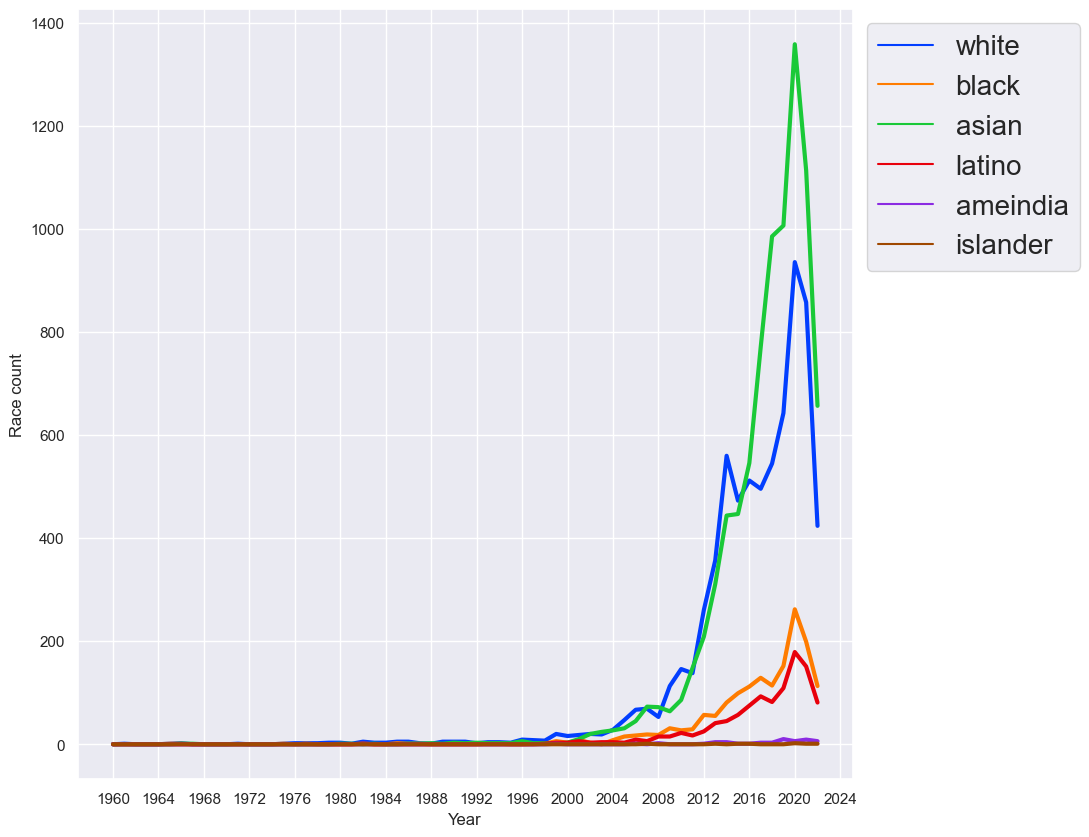

In [1130]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(10,10)})

ax = sns.lineplot(data=test_df, x ='year', y = 'single_race_count',
                  hue='race_type', palette='bright',   # colorblind  deep, muted, pastel, bright, dark, viridis
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1), prop={'size':20})
plt.ylabel('Race count')
plt.xlabel('Year')
plt.show()

In [1131]:

df_pivot = pd.pivot_table(test_df,
                          values='single_race_count',
                          index='race_type',
                          columns='year')
df_pivot



year       1960  1961  1962  1963  1964  1965  1966  1967  1968  1969  1970  \
race_type                                                                     
ameindia      0     0     0     0     0     0     0     0     0     0     0   
asian         0     0     0     0     0     0     1     1     0     0     0   
black         0     0     0     0     0     1     1     0     0     0     0   
islander      0     0     0     0     0     0     0     0     0     0     0   
latino        0     0     0     0     0     0     0     0     0     0     0   
white         0     1     0     0     0     1     2     0     0     0     0   

year       1971  1972  1973  1974  1975  1976  1977  1978  1979  1980  1981  \
race_type                                                                     
ameindia      0     0     0     0     0     0     0     0     0     0     0   
asian         0     0     0     0     0     0     0     0     0     1     1   
black         0     0     0     0     1     0     1     0     0     0     0   
islander      0     0     0     0     0     0     0     0     0     0     0   
latino        0     0     0     0     0     0     0     0     0     0     0   
white         1     0     0     0     1     2     2     2     3     3     1   

year       1982  1983  1984  1985  1986  1987  1988  1989  1990  1991  1992  \
race_type                                                                     
ameindia      0     0     0     0     0     0     0     0     0     0     0   
asian         0     1     0     0     1     1     2     1     3     2     3   
black         1     0     0     2     1     1     0     0     0     0     0   
islander      0     0     0     0     0     0     0     0     0     0     0   
latino        1     0     0     0     0     0     0     0     0     0     0   
white         5     3     3     5     5     2     1     5     5     5     2   

year       1993  1994  1995  1996  1997  1998  1999  2000  2001  2002  2003  \
race_type                                                                     
ameindia      0     0     0     0     0     0     1     0     0     0     0   
asian         2     2     2     6     2     2     1     3    10    20    24   
black         1     1     0     0     1     1     6     3     8     3     0   
islander      0     0     0     0     0     0     0     0     0     0     0   
latino        0     0     0     0     0     1     3     3     6     3     4   
white         4     4     3     9     8     7    20    16    18    20    19   

year       2004  2005  2006  2007  2008  2009  2010  2011  2012  2013  2014  \
race_type                                                                     
ameindia      0     0     1     0     2     0     0     0     1     4     4   
asian        27    31    45    73    72    64    86   148   209   311   444   
black         8    15    17    19    18    31    27    29    57    55    81   
islander      0     0     0     1     0     0     0     0     0     1     0   
latino        4     3     9     6    15    15    22    17    25    41    45   
white        28    47    67    69    53   113   146   138   261   357   560   

year       2015  2016  2017  2018  2019  2020  2021  2022  
race_type                                                  
ameindia      1     1     3     3    10     6     9     6  
asian       447   546   771   986  1007  1359  1114   657  
black        99   112   129   114   152   262   199   113  
islander      1     1     0     0     0     2     1     1  
latino       57    75    93    82   109   179   151    81  
white       473   512   496   545   643   936   858   424

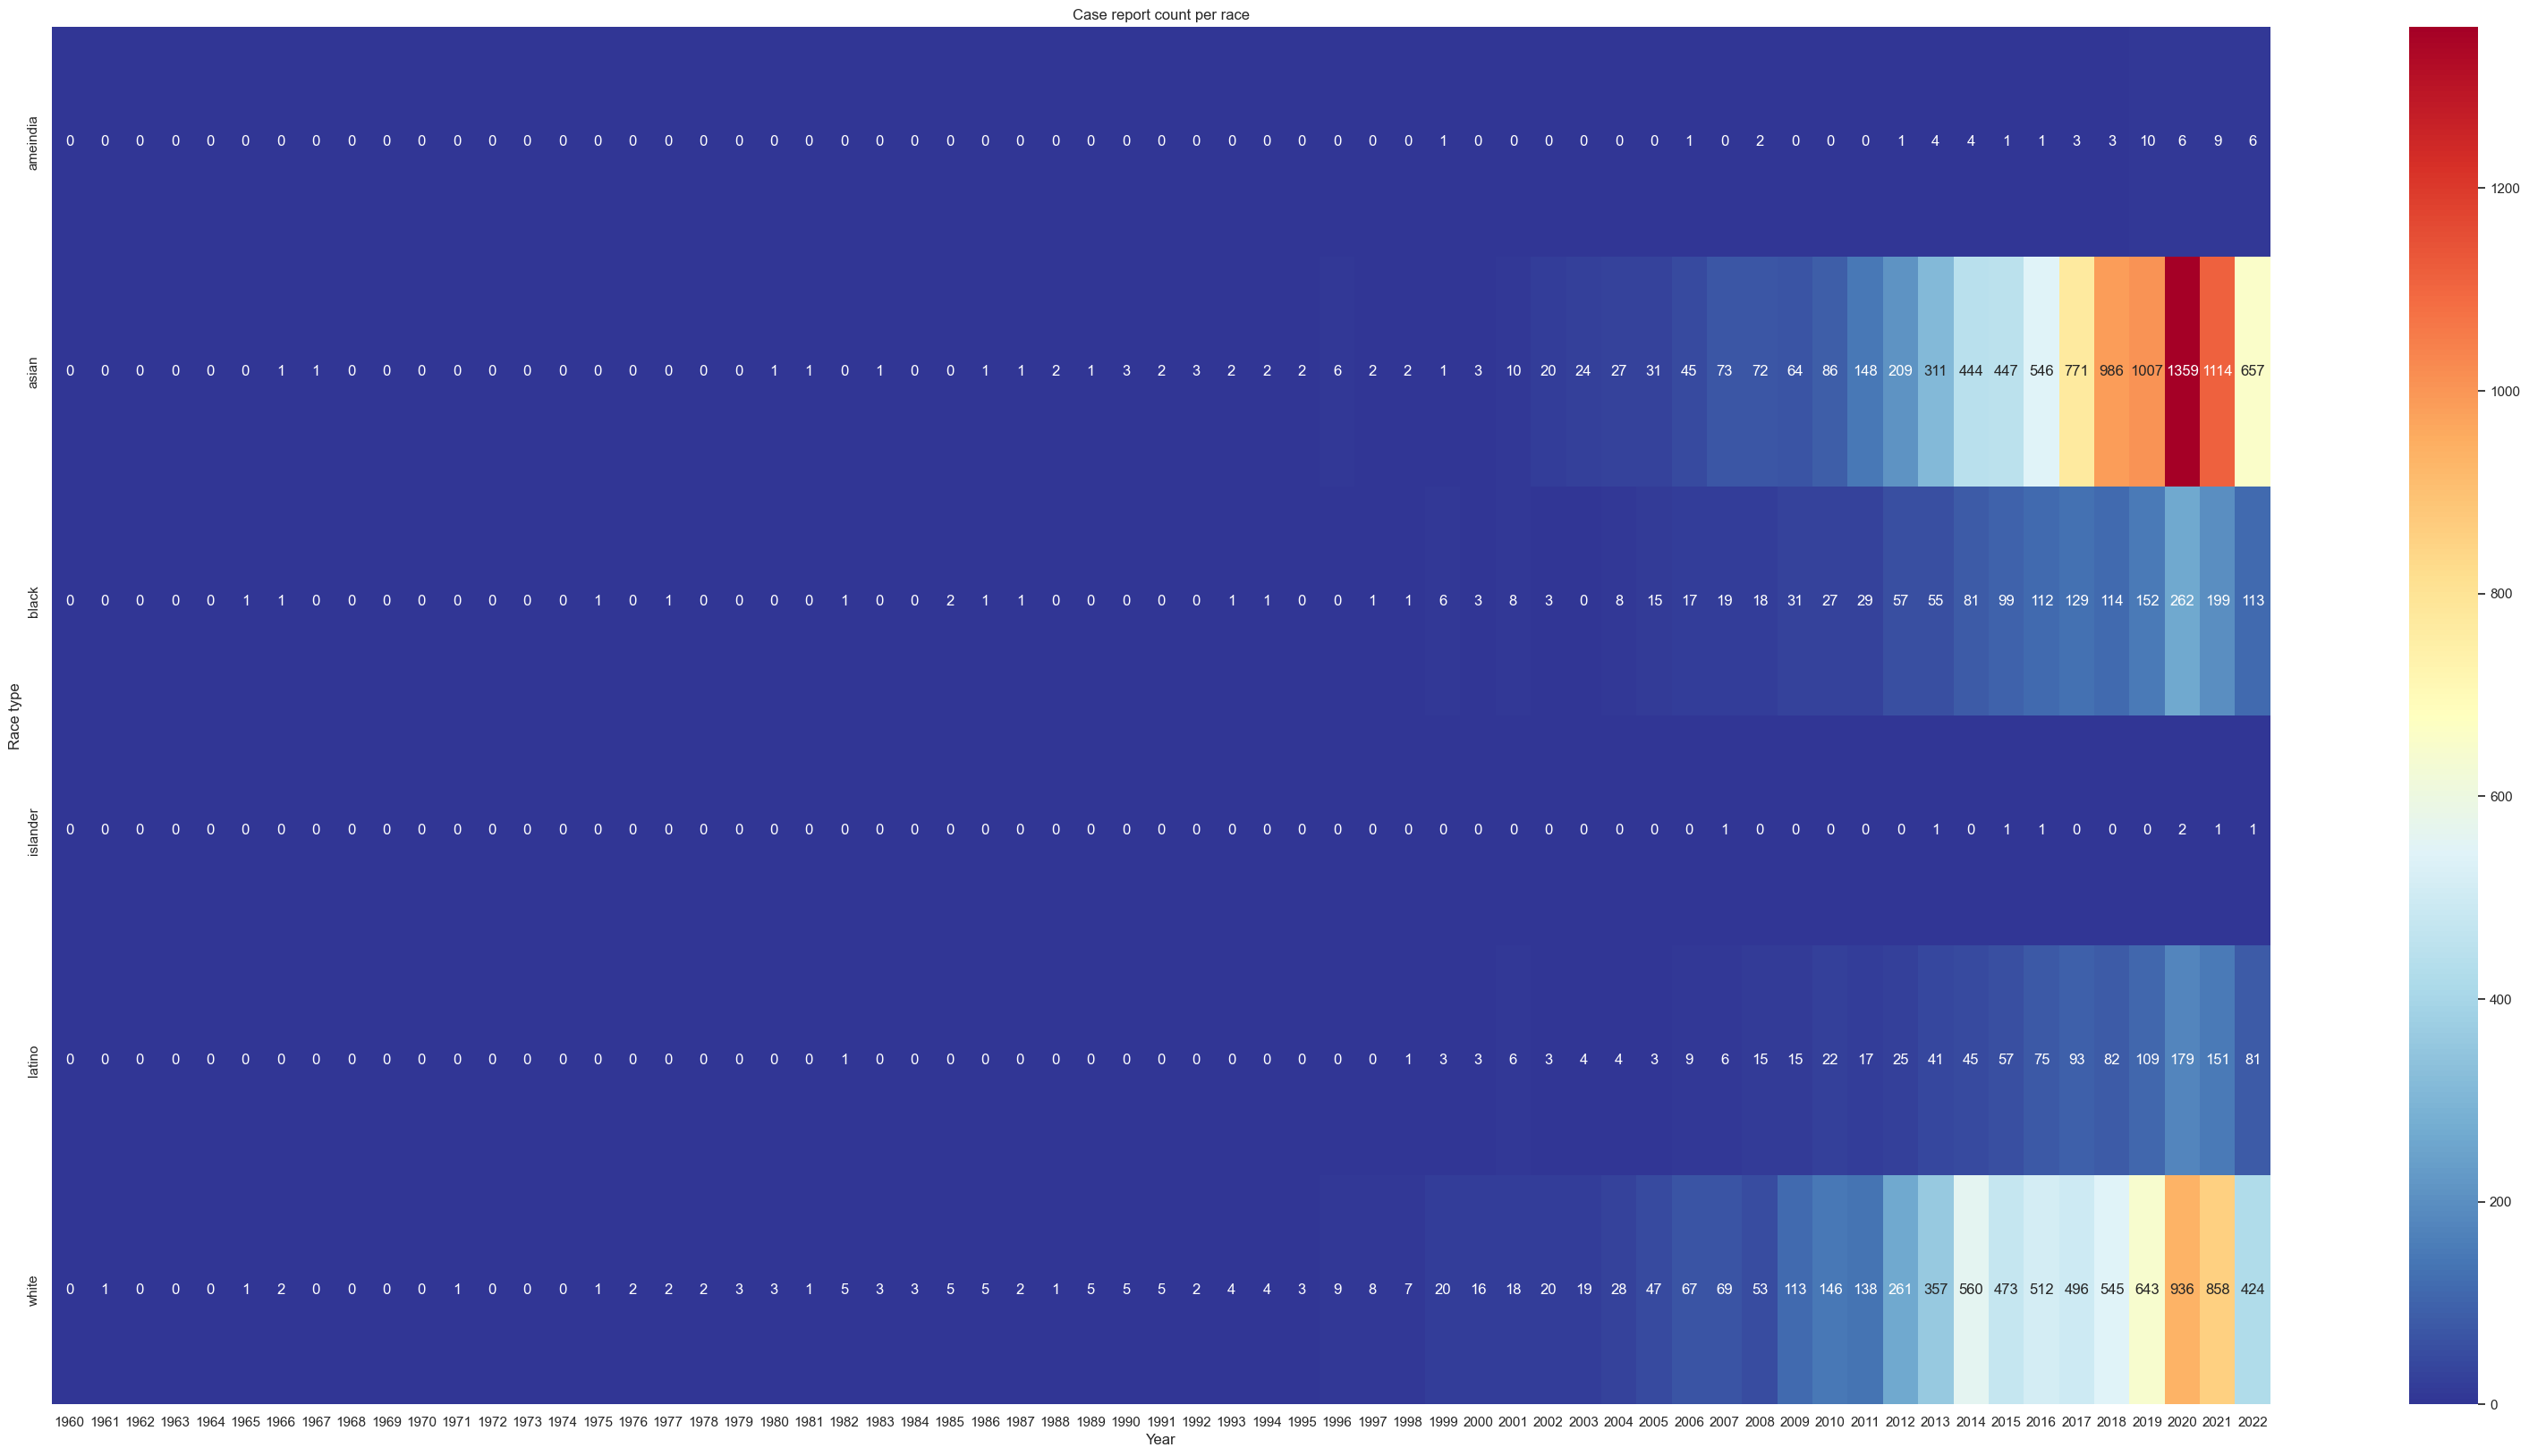

In [1132]:
plt.figure(figsize = (40,20))
plt.title('Case report count per race')

sns.heatmap(df_pivot, annot=True, cmap='RdYlBu_r', fmt= '.4g',)
plt.xlabel('Year')
plt.ylabel('Race type')
plt.show()

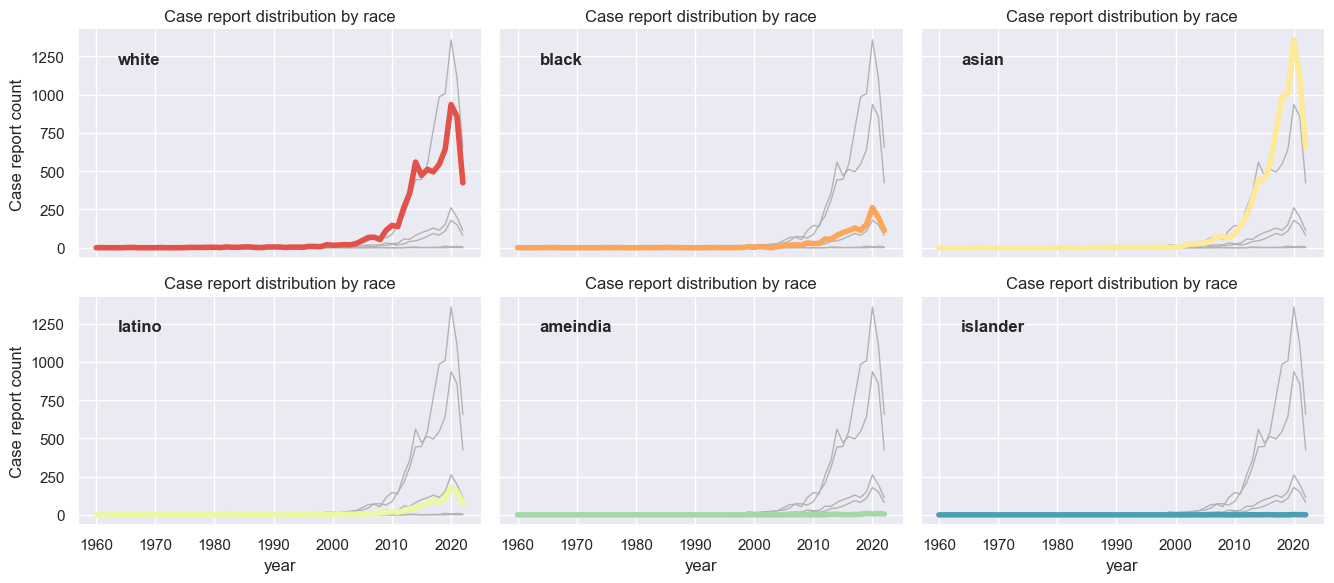

In [1133]:
g = sns.relplot(data = test_df, x = "year", y = "single_race_count",
                col = "race_type", hue = "race_type",
                kind = "line", palette = "Spectral",   
                linewidth = 4, zorder = 5,
                col_wrap = 3, height = 3, aspect = 1.5, legend = False
               )

#add text and silhouettes
for time, ax in g.axes_dict.items():
    ax.text(.1, .85, time,
            transform = ax.transAxes, fontweight="bold"
           )
    sns.lineplot(data = test_df, x = "year", y = "single_race_count", units="race_type",
                 estimator = None, color= ".7", linewidth=1, ax=ax
                )

# ax.set_xticks('')

# # get the values we want displayed as tick labels
# tick_labels = tuple(df['Line'])
# # get the positions for the maximum xtick label
# x_max = int(max(plt.xticks()[0]))  # int() to convert numpy.int32 => int
# # manually set you xtick labels
# plt.xticks(range(0, x_max + 1), tick_labels, rotation=45)


g.set_titles("Case report distribution by race")
g.set_axis_labels("year", "Case report count")
g.tight_layout()

In [1134]:
disease_mesh = 'D000349|Africa'
print(f'Results for {disease_mesh}')
test_df = get_stats_by_mesh_single_df(disease_mesh)
print('='*20)

Results for D000349|Africa
year	total_count	no_race_count	race_count	white_count	black_count	asian_count	latino_count	ameindian_count	islander_count


/var/folders/_3/np49sjc12t54plcrh2qv_xx40000gn/T/ipykernel_76901/3295167026.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  journal_limit = (merged_df_no_subject_date['mesh_list'].astype(str).str.contains(f'({disease_mesh})', regex=True))


1960	0	0	0	0	0	0	0	0	0
1961	0	0	0	0	0	0	0	0	0
1962	0	0	0	0	0	0	0	0	0
1963	0	0	0	0	0	0	0	0	0
1964	0	0	0	0	0	0	0	0	0
1965	0	0	0	0	0	0	0	0	0
1966	0	0	0	0	0	0	0	0	0
1967	0	0	0	0	0	0	0	0	0
1968	0	0	0	0	0	0	0	0	0
1969	0	0	0	0	0	0	0	0	0
1970	0	0	0	0	0	0	0	0	0
1971	0	0	0	0	0	0	0	0	0
1972	0	0	0	0	0	0	0	0	0
1973	0	0	0	0	0	0	0	0	0
1974	0	0	0	0	0	0	0	0	0
1975	0	0	0	0	0	0	0	0	0
1976	0	0	0	0	0	0	0	0	0
1977	0	0	0	0	0	0	0	0	0
1978	0	0	0	0	0	0	0	0	0
1979	0	0	0	0	0	0	0	0	0
1980	0	0	0	0	0	0	0	0	0
1981	0	0	0	0	0	0	0	0	0
1982	1	0	1	1	0	0	0	0	0
1983	0	0	0	0	0	0	0	0	0
1984	0	0	0	0	0	0	0	0	0
1985	0	0	0	0	0	0	0	0	0
1986	0	0	0	0	0	0	0	0	0
1987	1	0	1	1	0	0	0	0	0
1988	0	0	0	0	0	0	0	0	0
1989	0	0	0	0	0	0	0	0	0
1990	0	0	0	0	0	0	0	0	0
1991	0	0	0	0	0	0	0	0	0
1992	0	0	0	0	0	0	0	0	0
1993	0	0	0	0	0	0	0	0	0
1994	0	0	0	0	0	0	0	0	0
1995	0	0	0	0	0	0	0	0	0
1996	1	1	0	0	0	0	0	0	0
1997	0	0	0	0	0	0	0	0	0
1998	0	0	0	0	0	0	0	0	0
1999	1	0	1	0	1	0	0	0	0
2000	1	1	0	0	0	0	0	0	0
2001	2	1	1	1	1	0	1	0	0
2002	1	0	1	0	1	0	0	0	0
2003	1	1	0	

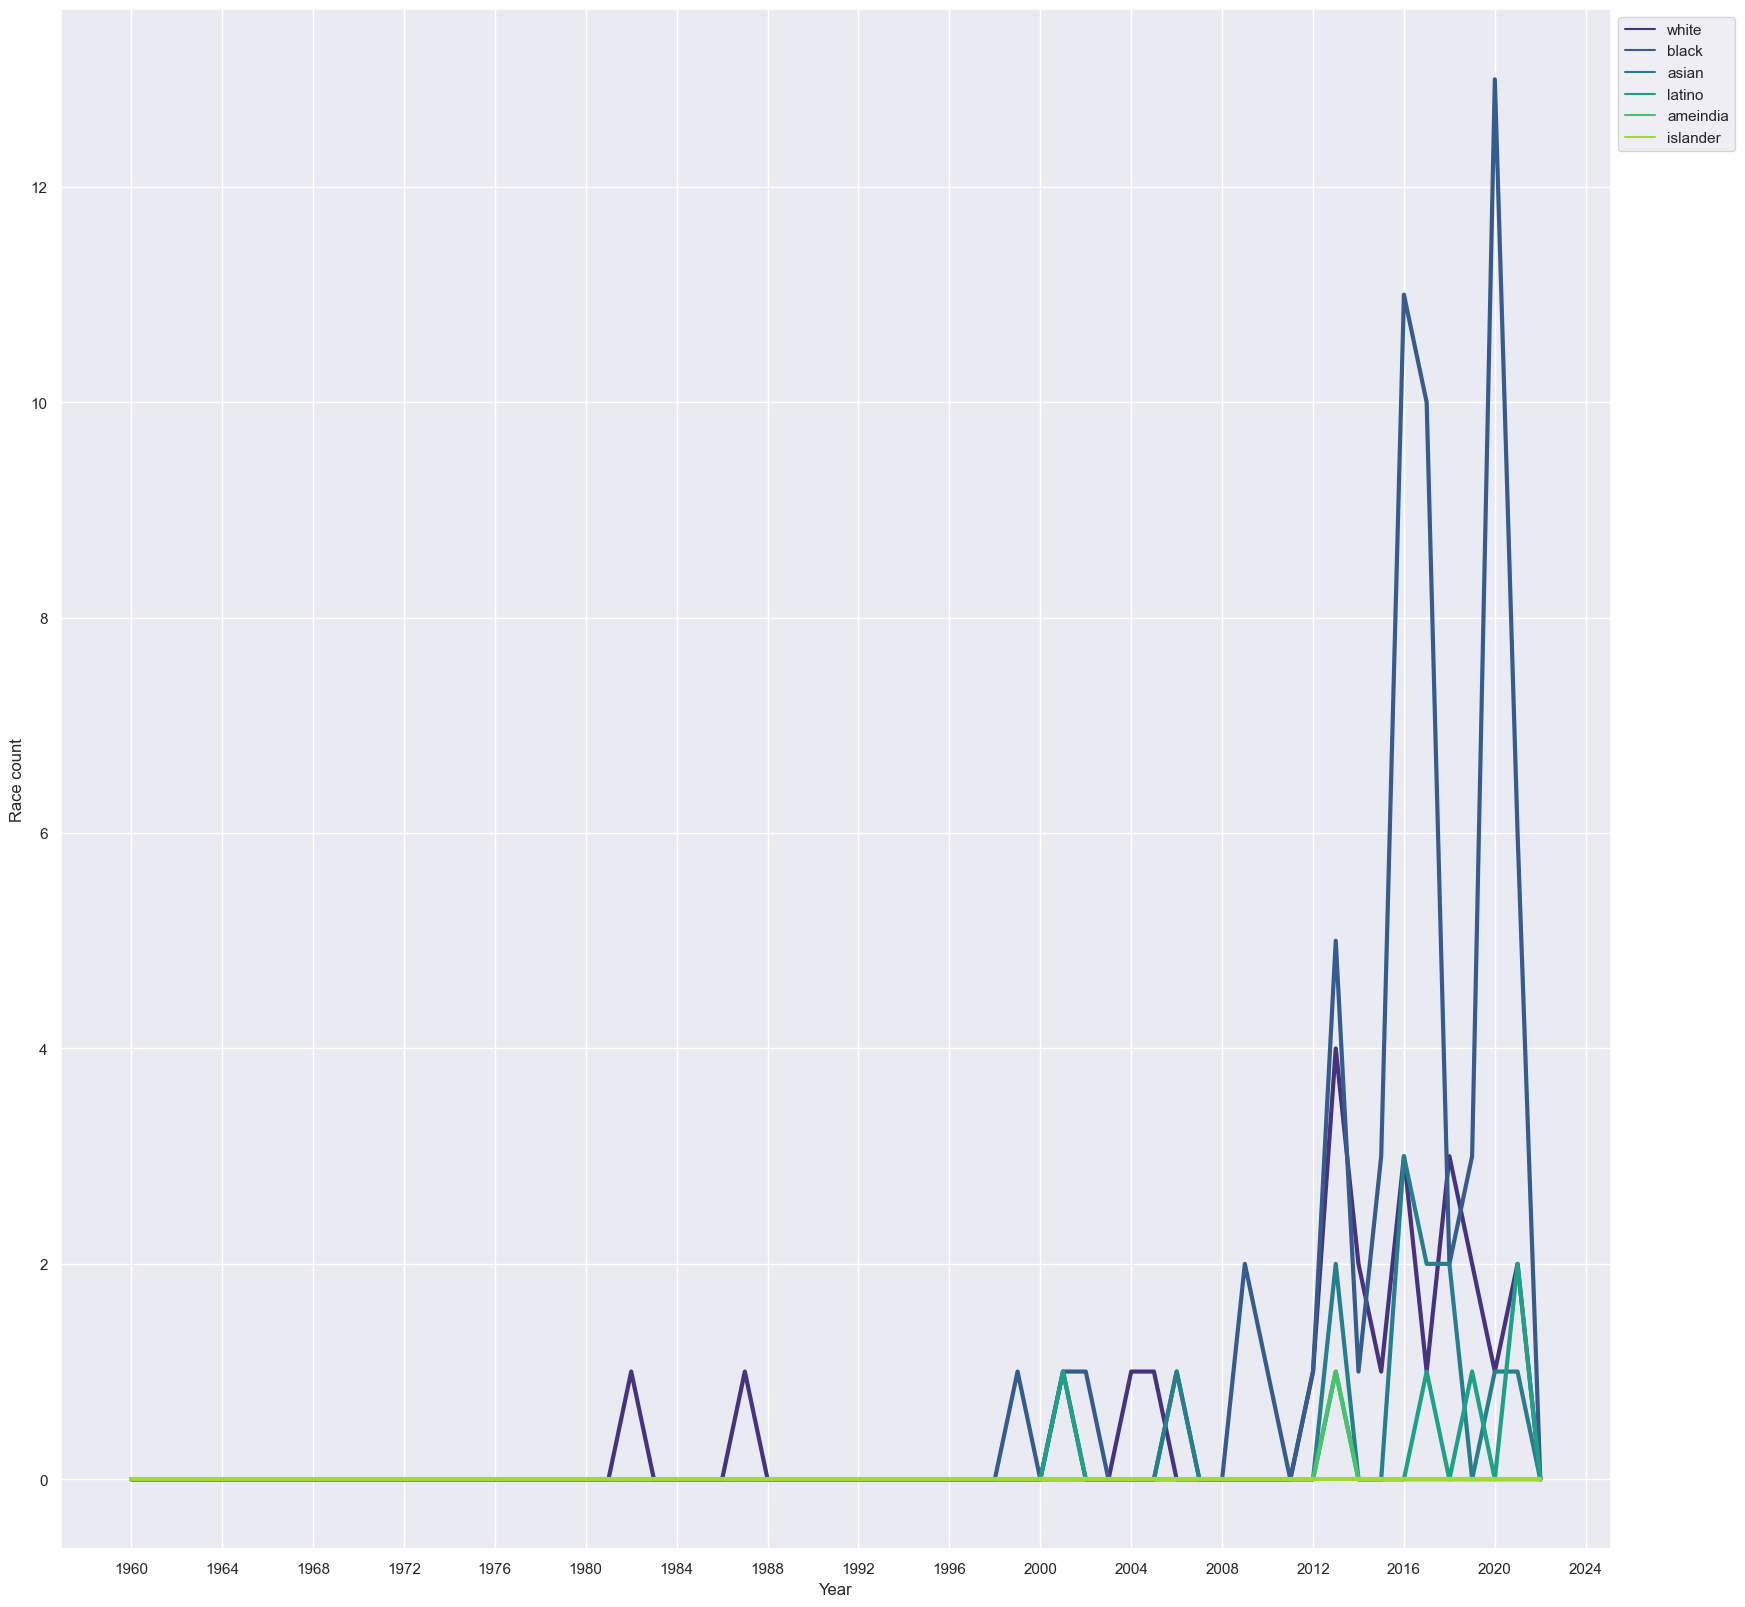

In [1135]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(20,20)})

ax = sns.lineplot(data=test_df, x ='year', y = 'single_race_count',
                  hue='race_type', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Race count')
plt.xlabel('Year')
plt.show()

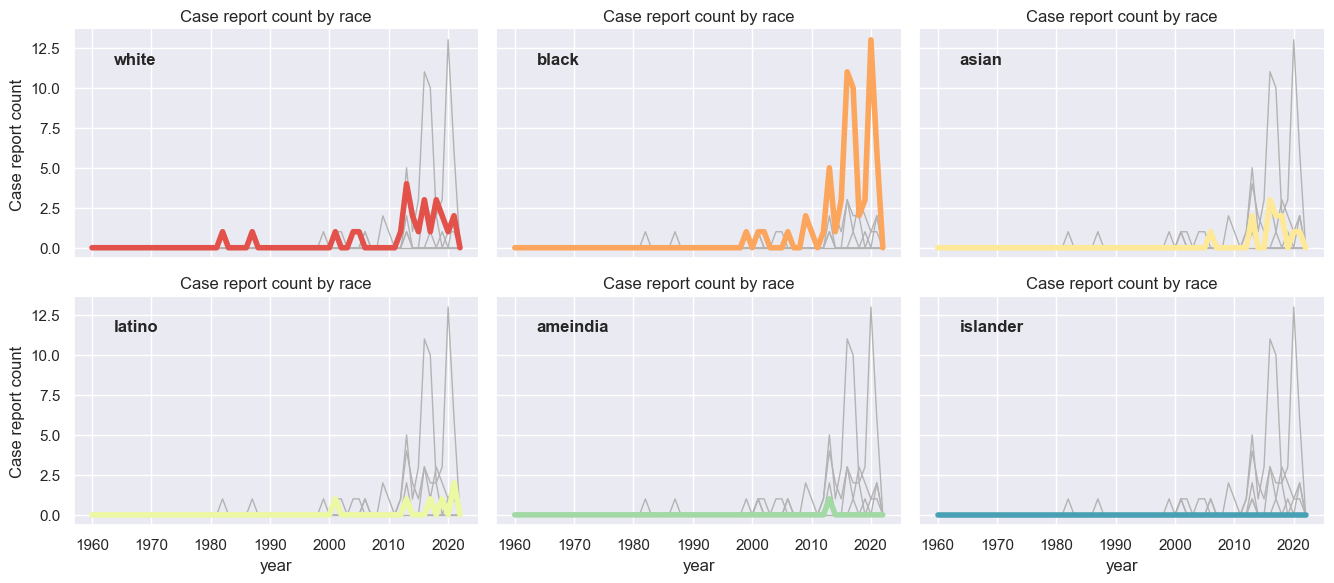

In [1136]:
g = sns.relplot(data = test_df, x = "year", y = "single_race_count",
                col = "race_type", hue = "race_type",
                kind = "line", palette = "Spectral",   
                linewidth = 4, zorder = 5,
                col_wrap = 3, height = 3, aspect = 1.5, legend = False
               )

#add text and silhouettes
for time, ax in g.axes_dict.items():
    ax.text(.1, .85, time,
            transform = ax.transAxes, fontweight="bold"
           )
    sns.lineplot(data = test_df, x = "year", y = "single_race_count", units="race_type",
                 estimator = None, color= ".7", linewidth=1, ax=ax
                )

# ax.set_xticks('')

# # get the values we want displayed as tick labels
# tick_labels = tuple(df['Line'])
# # get the positions for the maximum xtick label
# x_max = int(max(plt.xticks()[0]))  # int() to convert numpy.int32 => int
# # manually set you xtick labels
# plt.xticks(range(0, x_max + 1), tick_labels, rotation=45)


g.set_titles("Case report count by race")
g.set_axis_labels("year", "Case report count")
g.tight_layout()

In [1137]:
# D003550  Cystic Fibrosis
# more common in white patients

disease_mesh = 'D003550|Cystic Fibrosis'
print(f'Results for {disease_mesh}')
test_df = get_stats_by_mesh_single_df(disease_mesh)
print('='*20)

Results for D003550|Cystic Fibrosis
year	total_count	no_race_count	race_count	white_count	black_count	asian_count	latino_count	ameindian_count	islander_count


/var/folders/_3/np49sjc12t54plcrh2qv_xx40000gn/T/ipykernel_76901/3295167026.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  journal_limit = (merged_df_no_subject_date['mesh_list'].astype(str).str.contains(f'({disease_mesh})', regex=True))


1960	0	0	0	0	0	0	0	0	0
1961	0	0	0	0	0	0	0	0	0
1962	0	0	0	0	0	0	0	0	0
1963	0	0	0	0	0	0	0	0	0
1964	0	0	0	0	0	0	0	0	0
1965	0	0	0	0	0	0	0	0	0
1966	0	0	0	0	0	0	0	0	0
1967	0	0	0	0	0	0	0	0	0
1968	0	0	0	0	0	0	0	0	0
1969	0	0	0	0	0	0	0	0	0
1970	0	0	0	0	0	0	0	0	0
1971	0	0	0	0	0	0	0	0	0
1972	0	0	0	0	0	0	0	0	0
1973	0	0	0	0	0	0	0	0	0
1974	0	0	0	0	0	0	0	0	0
1975	0	0	0	0	0	0	0	0	0
1976	0	0	0	0	0	0	0	0	0
1977	0	0	0	0	0	0	0	0	0
1978	0	0	0	0	0	0	0	0	0
1979	0	0	0	0	0	0	0	0	0
1980	0	0	0	0	0	0	0	0	0
1981	0	0	0	0	0	0	0	0	0
1982	0	0	0	0	0	0	0	0	0
1983	0	0	0	0	0	0	0	0	0
1984	0	0	0	0	0	0	0	0	0
1985	0	0	0	0	0	0	0	0	0
1986	0	0	0	0	0	0	0	0	0
1987	0	0	0	0	0	0	0	0	0
1988	1	1	0	0	0	0	0	0	0
1989	0	0	0	0	0	0	0	0	0
1990	0	0	0	0	0	0	0	0	0
1991	0	0	0	0	0	0	0	0	0
1992	1	1	0	0	0	0	0	0	0
1993	1	1	0	0	0	0	0	0	0
1994	0	0	0	0	0	0	0	0	0
1995	0	0	0	0	0	0	0	0	0
1996	0	0	0	0	0	0	0	0	0
1997	1	1	0	0	0	0	0	0	0
1998	0	0	0	0	0	0	0	0	0
1999	0	0	0	0	0	0	0	0	0
2000	0	0	0	0	0	0	0	0	0
2001	0	0	0	0	0	0	0	0	0
2002	0	0	0	0	0	0	0	0	0
2003	0	0	0	

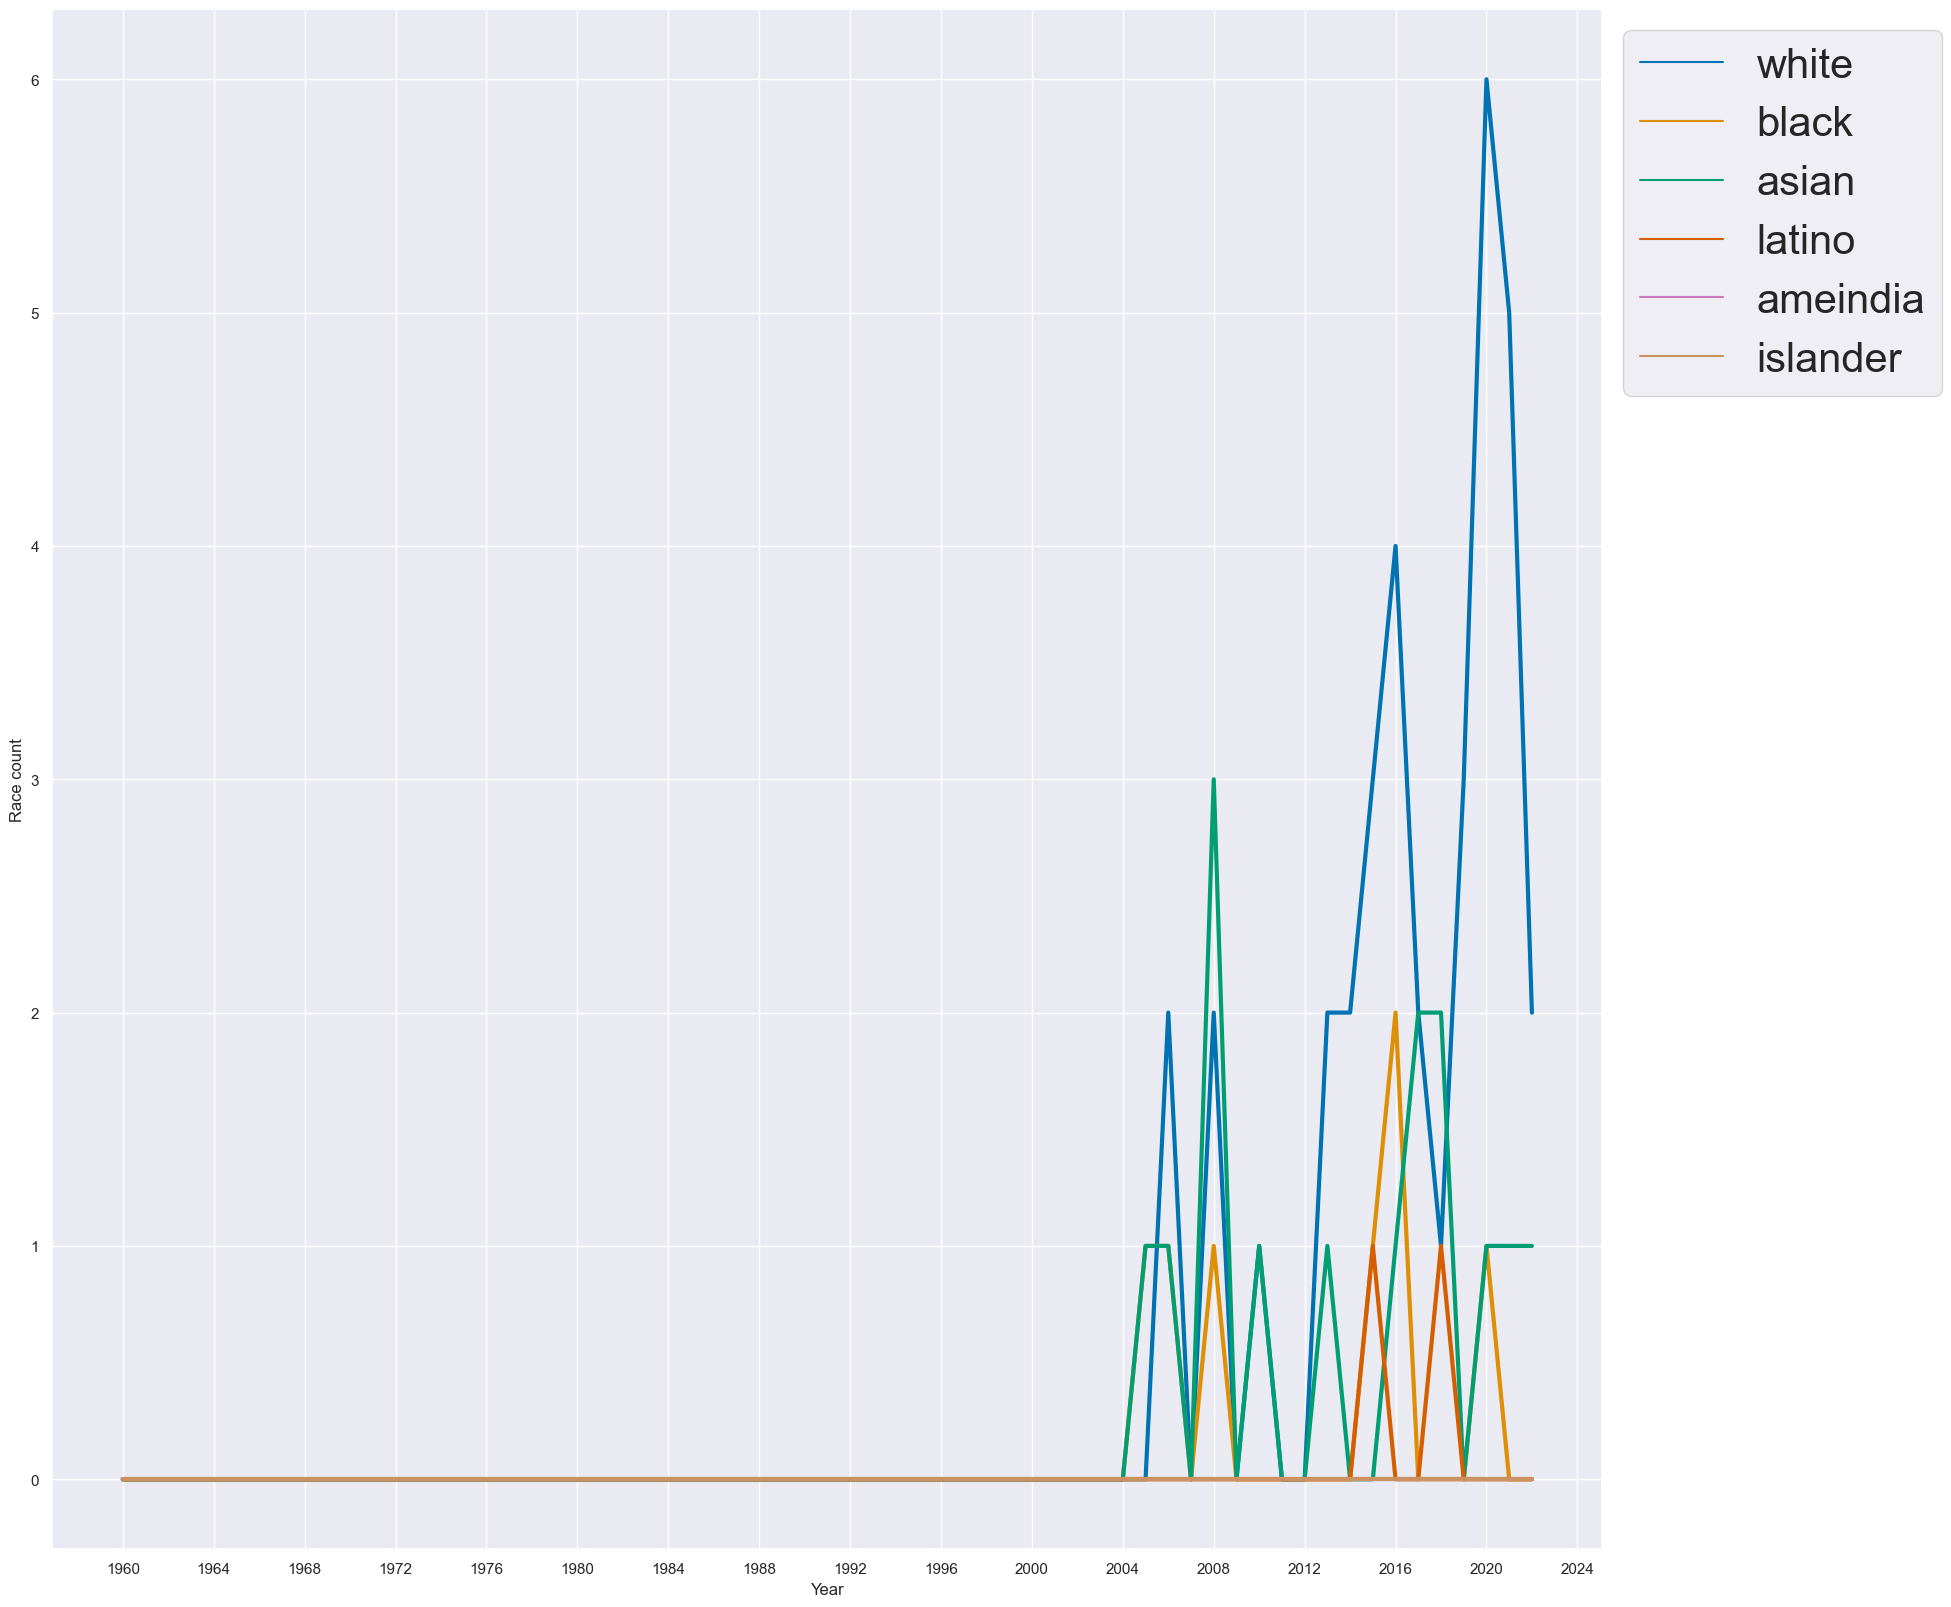

In [1138]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(20,20)})

ax = sns.lineplot(data=test_df, x ='year', y = 'single_race_count',
                  hue='race_type', palette='colorblind',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1), prop={'size':30})
plt.ylabel('Race count')
plt.xlabel('Year')
plt.show()

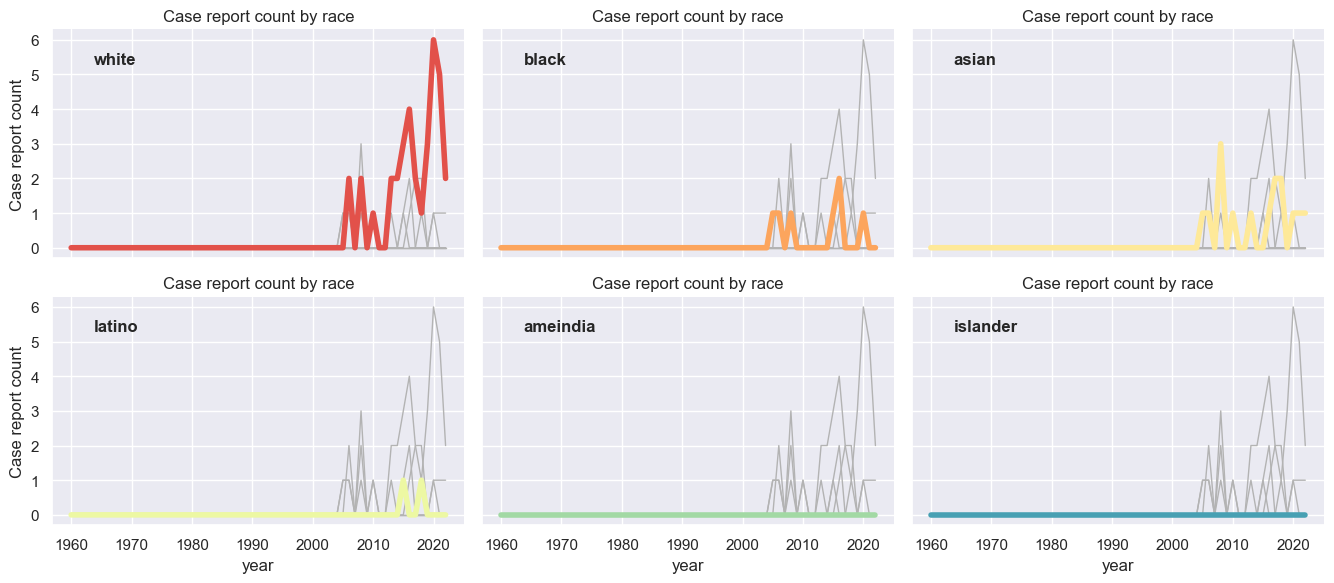

In [1139]:
g = sns.relplot(data = test_df, x = "year", y = "single_race_count",
                col = "race_type", hue = "race_type",
                kind = "line", palette = "Spectral",   
                linewidth = 4, zorder = 5,
                col_wrap = 3, height = 3, aspect = 1.5, legend = False
               )

#add text and silhouettes
for time, ax in g.axes_dict.items():
    ax.text(.1, .85, time,
            transform = ax.transAxes, fontweight="bold"
           )
    sns.lineplot(data = test_df, x = "year", y = "single_race_count", units="race_type",
                 estimator = None, color= ".7", linewidth=1, ax=ax
                )

# ax.set_xticks('')

# # get the values we want displayed as tick labels
# tick_labels = tuple(df['Line'])
# # get the positions for the maximum xtick label
# x_max = int(max(plt.xticks()[0]))  # int() to convert numpy.int32 => int
# # manually set you xtick labels
# plt.xticks(range(0, x_max + 1), tick_labels, rotation=45)


g.set_titles("Case report count by race")
g.set_axis_labels("year", "Case report count")
g.tight_layout()

In [1140]:
# D000755 | Anemia, Sickle Cell
# more common in Black patients

disease_mesh = 'D000755|Anemia, Sickle Cell'
print(f'Results for {disease_mesh}')
test_df = get_stats_by_mesh_single_df(disease_mesh)
print('='*20)

Results for D000755|Anemia, Sickle Cell
year	total_count	no_race_count	race_count	white_count	black_count	asian_count	latino_count	ameindian_count	islander_count


/var/folders/_3/np49sjc12t54plcrh2qv_xx40000gn/T/ipykernel_76901/3295167026.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  journal_limit = (merged_df_no_subject_date['mesh_list'].astype(str).str.contains(f'({disease_mesh})', regex=True))


1960	0	0	0	0	0	0	0	0	0
1961	0	0	0	0	0	0	0	0	0
1962	0	0	0	0	0	0	0	0	0
1963	0	0	0	0	0	0	0	0	0
1964	0	0	0	0	0	0	0	0	0
1965	0	0	0	0	0	0	0	0	0
1966	0	0	0	0	0	0	0	0	0
1967	0	0	0	0	0	0	0	0	0
1968	0	0	0	0	0	0	0	0	0
1969	0	0	0	0	0	0	0	0	0
1970	0	0	0	0	0	0	0	0	0
1971	0	0	0	0	0	0	0	0	0
1972	0	0	0	0	0	0	0	0	0
1973	0	0	0	0	0	0	0	0	0
1974	0	0	0	0	0	0	0	0	0
1975	0	0	0	0	0	0	0	0	0
1976	0	0	0	0	0	0	0	0	0
1977	0	0	0	0	0	0	0	0	0
1978	0	0	0	0	0	0	0	0	0
1979	0	0	0	0	0	0	0	0	0
1980	0	0	0	0	0	0	0	0	0
1981	0	0	0	0	0	0	0	0	0
1982	0	0	0	0	0	0	0	0	0
1983	0	0	0	0	0	0	0	0	0
1984	0	0	0	0	0	0	0	0	0
1985	0	0	0	0	0	0	0	0	0
1986	0	0	0	0	0	0	0	0	0
1987	0	0	0	0	0	0	0	0	0
1988	0	0	0	0	0	0	0	0	0
1989	0	0	0	0	0	0	0	0	0
1990	0	0	0	0	0	0	0	0	0
1991	0	0	0	0	0	0	0	0	0
1992	0	0	0	0	0	0	0	0	0
1993	0	0	0	0	0	0	0	0	0
1994	0	0	0	0	0	0	0	0	0
1995	0	0	0	0	0	0	0	0	0
1996	0	0	0	0	0	0	0	0	0
1997	0	0	0	0	0	0	0	0	0
1998	0	0	0	0	0	0	0	0	0
1999	1	0	1	1	0	0	0	0	0
2000	0	0	0	0	0	0	0	0	0
2001	0	0	0	0	0	0	0	0	0
2002	0	0	0	0	0	0	0	0	0
2003	0	0	0	

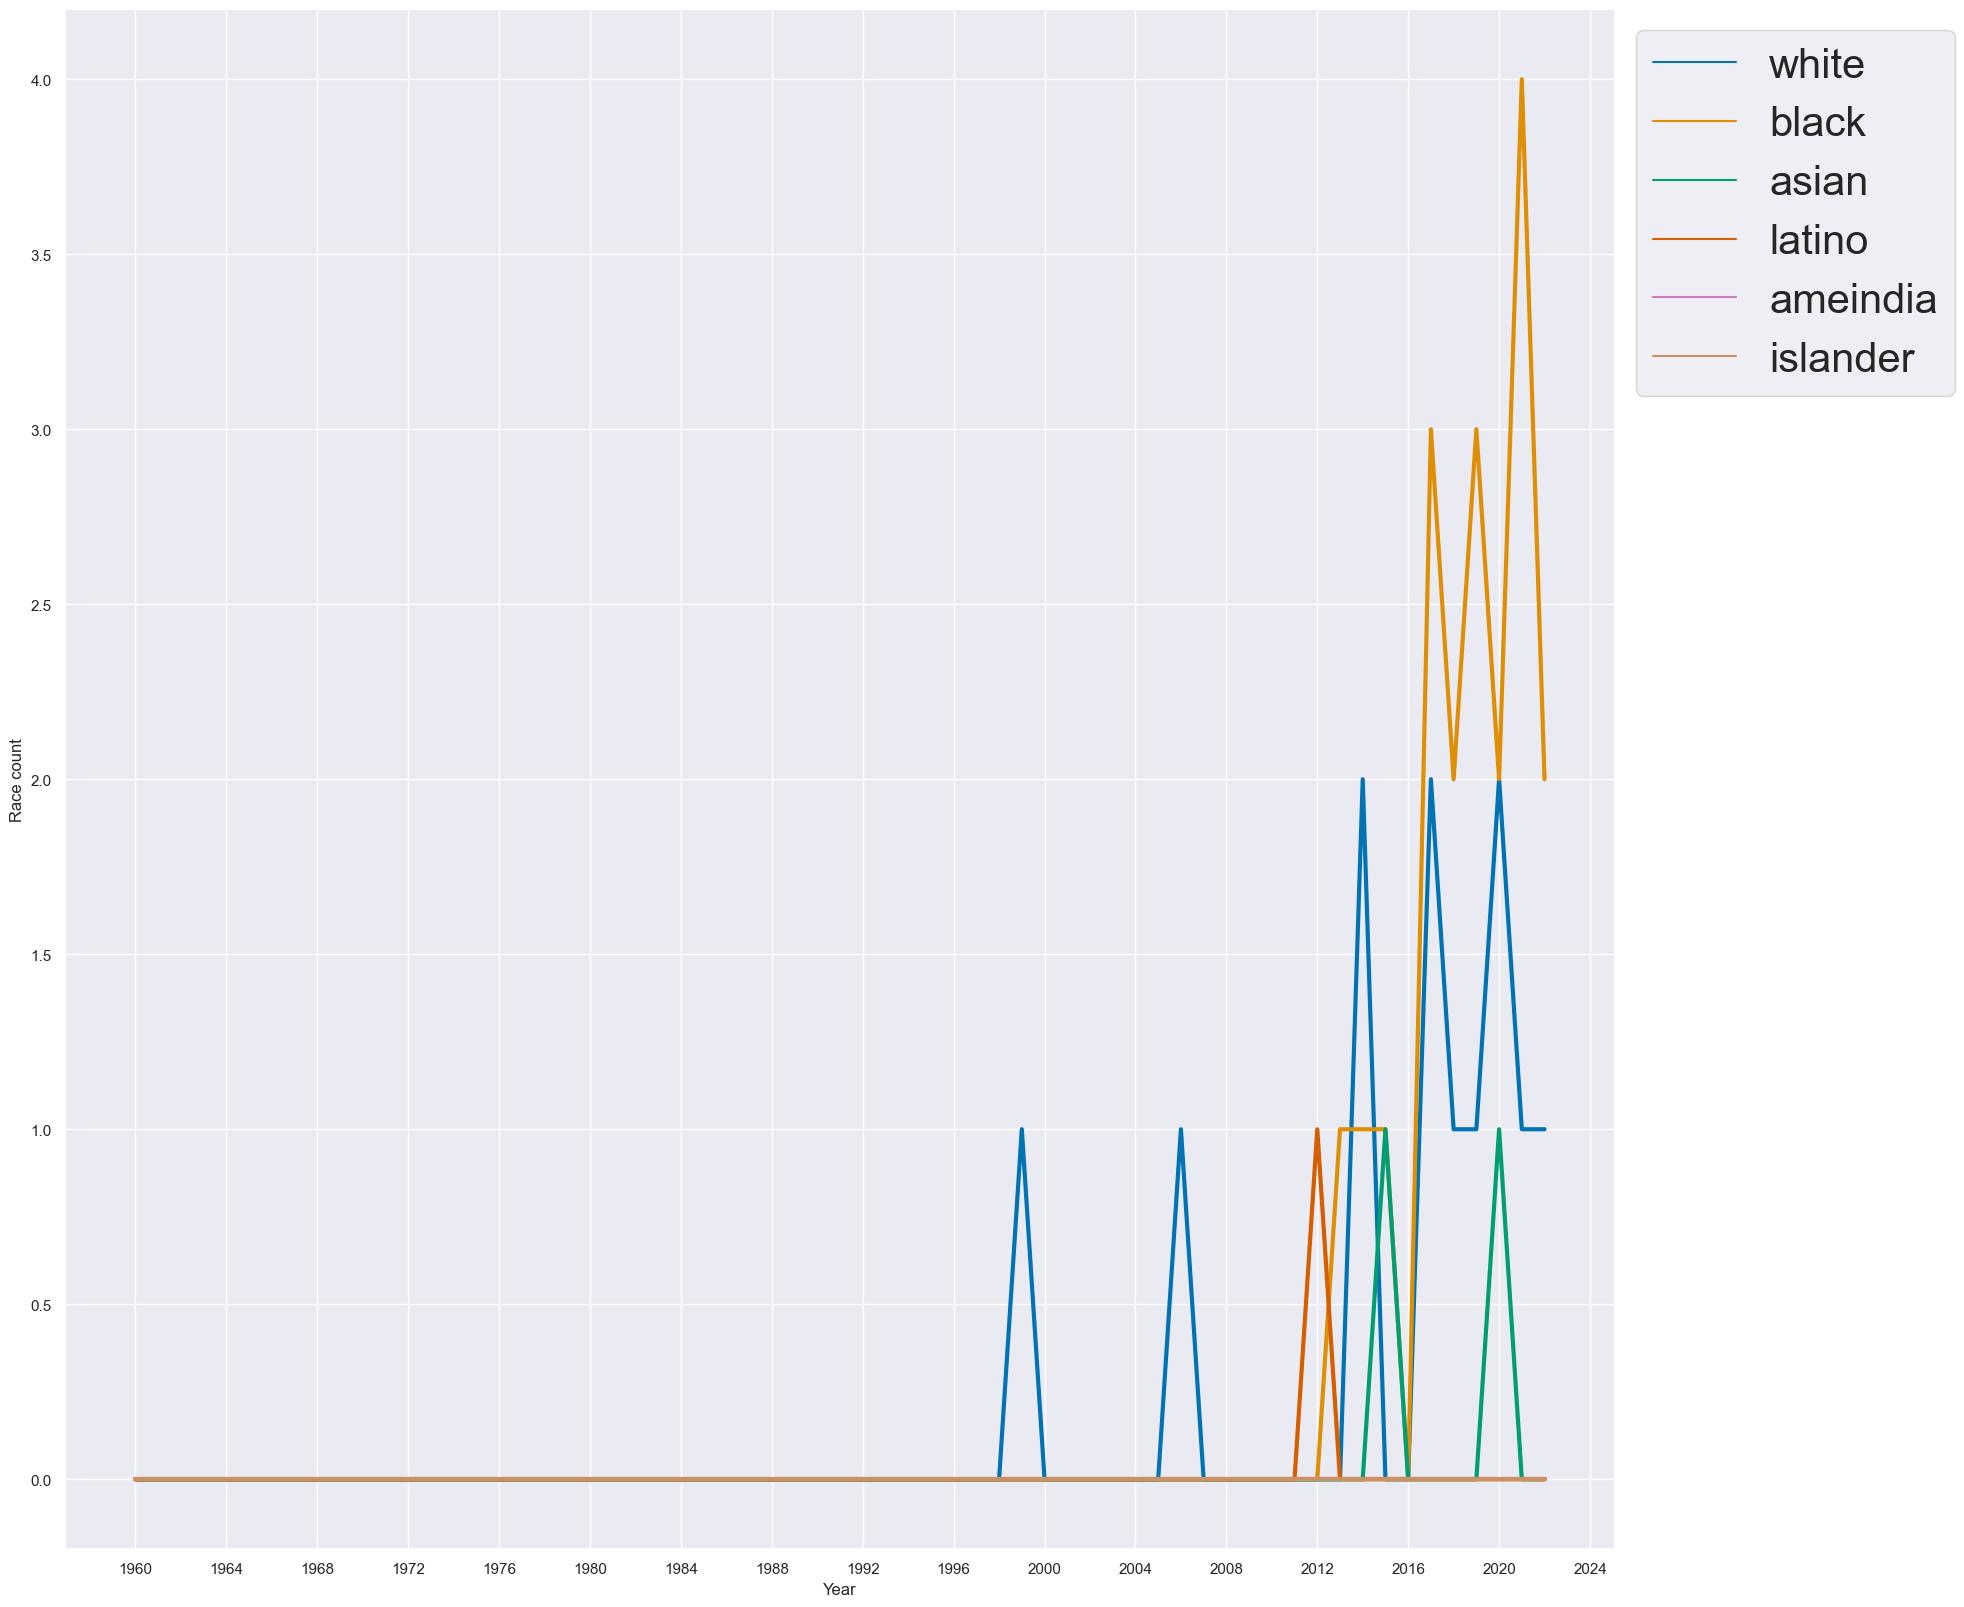

In [1141]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(20,20)})

ax = sns.lineplot(data=test_df, x ='year', y = 'single_race_count',
                  hue='race_type', palette='colorblind',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1), prop={'size':30})
plt.ylabel('Race count')
plt.xlabel('Year')
plt.show()

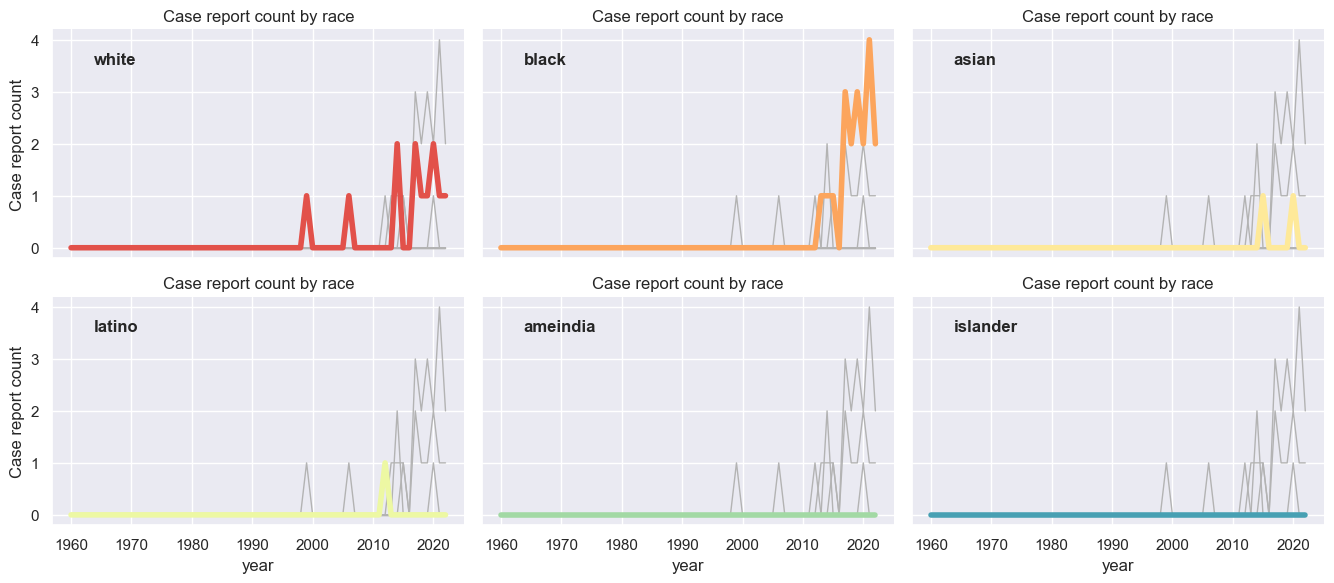

In [1142]:
g = sns.relplot(data = test_df, x = "year", y = "single_race_count",
                col = "race_type", hue = "race_type",
                kind = "line", palette = "Spectral",   
                linewidth = 4, zorder = 5,
                col_wrap = 3, height = 3, aspect = 1.5, legend = False
               )

#add text and silhouettes
for time, ax in g.axes_dict.items():
    ax.text(.1, .85, time,
            transform = ax.transAxes, fontweight="bold"
           )
    sns.lineplot(data = test_df, x = "year", y = "single_race_count", units="race_type",
                 estimator = None, color= ".7", linewidth=1, ax=ax
                )

# ax.set_xticks('')

# # get the values we want displayed as tick labels
# tick_labels = tuple(df['Line'])
# # get the positions for the maximum xtick label
# x_max = int(max(plt.xticks()[0]))  # int() to convert numpy.int32 => int
# # manually set you xtick labels
# plt.xticks(range(0, x_max + 1), tick_labels, rotation=45)


g.set_titles("Case report count by race")
g.set_axis_labels("year", "Case report count")
g.tight_layout()

In [1143]:

def get_stats_by_mesh_df(mesh_tag):
    result_list = []
    all_count = 0

    print('year\ttotal_count\tno_race_count\trace_count\twhite_count\tblack_count\tasian_count\tlatino_count\tameindian_count\tislander_count')
    result_list.append('year\ttotal_count\tno_race_count\trace_count\twhite_count\tblack_count\tasian_count\tlatino_count\tameindian_count\tislander_count'.split('\t'))
    
    for year in range(1990,2023):
        year_limit = (merged_df_no_subject_date['pubdate'] >= f'{year}-01-01')  & (merged_df_no_subject_date['pubdate'] <= f'{year}-12-31')

        journal_limit = (merged_df_no_subject_date['mesh_list'].astype(str).str.contains(f'({disease_mesh})', regex=True))
        total_count = merged_df_no_subject_date[
            year_limit
            & journal_limit
          ].shape[0]

        no_race_count = merged_df_no_subject_date[
            year_limit
            & journal_limit
            & (merged_df_no_subject_date['no_race']==True)
          ].shape[0]

        race_count = merged_df_no_subject_date[
           year_limit
            & journal_limit
            & (merged_df_no_subject_date['no_race']==False)
          ].shape[0]

        white_count = merged_df_no_subject_date[
              year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'white' in x))
          ].shape[0]

        black_count = merged_df_no_subject_date[
           year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'black' in x)
              )
          ].shape[0]

        asian_count = merged_df_no_subject_date[
           year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'asian' in x)
              )
          ].shape[0]

        latino_count = merged_df_no_subject_date[
           year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'latino' in x)
              )
          ].shape[0]

        ameindian_count = merged_df_no_subject_date[
          year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'ameindian' in x)
              )
          ].shape[0]

        islander_count = merged_df_no_subject_date[
           year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'islander' in x)
              )
          ].shape[0]

        print(f'{year}\t{total_count}\t{no_race_count}\t{race_count}\t{white_count}\t{black_count}\t{asian_count}\t{latino_count}\t{ameindian_count}\t{islander_count}')
        result_list.append([year,total_count,no_race_count,race_count,white_count,black_count,asian_count,latino_count,ameindian_count,islander_count])
        all_count += total_count
    print(all_count)
#     print(result_list[:5])
    result_df = pd.DataFrame(result_list[1:], columns=result_list[0])
    result_df['MESH'] = disease_mesh
    return result_df
    



In [1144]:
disease_mesh = 'D014057|Tomography, X-Ray Computed'
print(f'Results for {disease_mesh}')
test_df_1 = get_stats_by_mesh_df(disease_mesh)

disease_mesh = 'D008279|Magnetic Resonance Imaging'
print(f'Results for {disease_mesh}')
test_df_2 = get_stats_by_mesh_df(disease_mesh)
print('='*20)

disease_mesh = 'D011859|Radiography'
print(f'Results for {disease_mesh}')
test_df_3 = get_stats_by_mesh_df(disease_mesh)
print('='*20)


disease_mesh = 'D014463|Ultrasonography'
print(f'Results for {disease_mesh}')
test_df_4 = get_stats_by_mesh_df(disease_mesh)
print('='*20)

disease_mesh = 'D004452|Echocardiography'
print(f'Results for {disease_mesh}')
test_df_5 = get_stats_by_mesh_df(disease_mesh)
print('='*20)


Results for D014057|Tomography, X-Ray Computed
year	total_count	no_race_count	race_count	white_count	black_count	asian_count	latino_count	ameindian_count	islander_count


/var/folders/_3/np49sjc12t54plcrh2qv_xx40000gn/T/ipykernel_76901/281460603.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  journal_limit = (merged_df_no_subject_date['mesh_list'].astype(str).str.contains(f'({disease_mesh})', regex=True))


1990	7	7	0	0	0	0	0	0	0
1991	9	9	0	0	0	0	0	0	0
1992	4	4	0	0	0	0	0	0	0
1993	4	4	0	0	0	0	0	0	0
1994	5	5	0	0	0	0	0	0	0
1995	6	6	0	0	0	0	0	0	0
1996	11	8	3	2	0	1	0	0	0
1997	13	9	4	3	0	1	0	0	0
1998	6	5	1	1	0	0	0	0	0
1999	25	22	3	2	0	0	1	0	0
2000	16	12	4	1	0	1	2	0	0
2001	23	18	5	2	1	2	0	0	0
2002	31	29	2	1	0	1	0	0	0
2003	27	26	1	0	0	1	0	0	0
2004	27	23	4	1	1	3	0	0	0
2005	82	68	14	8	4	3	0	0	0
2006	89	81	8	5	0	3	0	0	0
2007	158	138	20	6	2	12	1	0	0
2008	183	173	10	3	2	5	1	0	0
2009	219	190	29	11	6	10	3	0	0
2010	210	181	29	18	5	7	1	0	0
2011	317	285	32	13	1	16	3	0	0
2012	387	319	68	29	6	35	1	0	0
2013	447	338	109	42	7	56	4	0	0
2014	536	380	156	77	5	75	3	0	0
2015	608	468	140	55	12	70	7	0	0
2016	683	499	184	80	16	95	4	0	0
2017	630	469	161	57	9	94	7	1	0
2018	930	723	207	55	13	143	4	0	0
2019	848	687	161	50	13	95	12	1	0
2020	1352	1149	203	61	14	120	17	1	0
2021	514	415	99	33	6	56	7	1	0
2022	128	109	19	3	2	16	0	0	0
8535
Results for D008279|Magnetic Resonance Imaging
year	total_count	no_race_count	race_count	wh

/var/folders/_3/np49sjc12t54plcrh2qv_xx40000gn/T/ipykernel_76901/281460603.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  journal_limit = (merged_df_no_subject_date['mesh_list'].astype(str).str.contains(f'({disease_mesh})', regex=True))


1990	3	3	0	0	0	0	0	0	0
1991	2	2	0	0	0	0	0	0	0
1992	1	1	0	0	0	0	0	0	0
1993	2	2	0	0	0	0	0	0	0
1994	2	2	0	0	0	0	0	0	0
1995	4	4	0	0	0	0	0	0	0
1996	9	9	0	0	0	0	0	0	0
1997	4	4	0	0	0	0	0	0	0
1998	4	4	0	0	0	0	0	0	0
1999	12	11	1	1	0	0	0	0	0
2000	10	8	2	1	0	0	1	0	0
2001	14	13	1	0	0	1	0	0	0
2002	18	15	3	1	0	3	0	0	0
2003	19	15	4	3	0	3	0	0	0
2004	21	20	1	0	0	1	0	0	0
2005	56	50	6	2	3	2	0	0	0
2006	66	59	7	5	0	1	1	0	0
2007	105	97	8	5	0	4	0	0	0
2008	137	120	17	7	3	7	0	0	0
2009	144	121	23	14	1	8	0	0	0
2010	154	133	21	11	3	9	1	0	0
2011	176	149	27	13	2	14	1	0	0
2012	234	202	32	16	2	12	2	0	0
2013	292	240	52	19	6	24	3	0	0
2014	350	247	103	52	3	52	3	0	0
2015	373	289	84	36	3	44	2	0	0
2016	462	359	103	44	4	55	4	0	0
2017	493	364	129	50	10	74	2	0	0
2018	655	508	147	46	11	92	6	0	0
2019	671	520	151	60	7	83	7	0	0
2020	861	720	141	34	11	92	7	1	1
2021	542	426	116	42	10	69	2	0	0
2022	165	135	30	12	4	13	1	0	0
6061
Results for D011859|Radiography
year	total_count	no_race_count	race_count	white_count	black_count	asian_co

/var/folders/_3/np49sjc12t54plcrh2qv_xx40000gn/T/ipykernel_76901/281460603.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  journal_limit = (merged_df_no_subject_date['mesh_list'].astype(str).str.contains(f'({disease_mesh})', regex=True))


1990	3	2	1	1	0	0	0	0	0
1991	3	3	0	0	0	0	0	0	0
1992	6	5	1	1	0	0	0	0	0
1993	4	4	0	0	0	0	0	0	0
1994	3	2	1	1	0	0	0	0	0
1995	4	4	0	0	0	0	0	0	0
1996	4	4	0	0	0	0	0	0	0
1997	3	3	0	0	0	0	0	0	0
1998	14	13	1	0	1	0	0	0	0
1999	14	14	0	0	0	0	0	0	0
2000	12	10	2	2	0	0	0	0	0
2001	21	19	2	1	0	0	1	0	0
2002	12	10	2	1	0	2	0	0	0
2003	22	21	1	0	0	1	0	0	0
2004	21	20	1	0	0	1	0	0	0
2005	37	35	2	0	1	1	0	0	0
2006	39	33	6	4	1	2	1	0	0
2007	44	36	8	2	2	5	1	0	0
2008	59	53	6	3	0	3	0	0	0
2009	74	62	12	4	1	6	1	0	0
2010	112	95	17	9	1	6	2	0	0
2011	125	105	20	5	3	13	0	0	0
2012	116	92	24	13	2	10	3	0	0
2013	178	136	42	19	1	21	3	0	0
2014	180	135	45	24	2	19	4	0	0
2015	209	167	42	18	3	21	2	0	0
2016	123	87	36	18	2	19	2	0	0
2017	111	76	35	14	5	16	2	0	0
2018	139	104	35	10	2	21	3	0	0
2019	156	128	28	11	4	10	4	0	0
2020	316	271	45	9	7	26	6	0	0
2021	87	71	16	3	3	10	1	0	0
2022	21	18	3	1	0	2	0	0	0
2272
Results for D014463|Ultrasonography
year	total_count	no_race_count	race_count	white_count	black_count	asian_count	latino_count	ameindian

/var/folders/_3/np49sjc12t54plcrh2qv_xx40000gn/T/ipykernel_76901/281460603.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  journal_limit = (merged_df_no_subject_date['mesh_list'].astype(str).str.contains(f'({disease_mesh})', regex=True))


1990	4	2	2	1	0	1	0	0	0
1991	6	6	0	0	0	0	0	0	0
1992	3	3	0	0	0	0	0	0	0
1993	2	2	0	0	0	0	0	0	0
1994	2	2	0	0	0	0	0	0	0
1995	3	3	0	0	0	0	0	0	0
1996	3	2	1	1	0	0	0	0	0
1997	4	2	2	2	0	0	0	0	0
1998	6	5	1	1	0	0	0	0	0
1999	10	8	2	1	1	0	0	0	0
2000	8	7	1	0	1	0	0	0	0
2001	17	17	0	0	0	0	0	0	0
2002	7	6	1	1	0	0	0	0	0
2003	8	8	0	0	0	0	0	0	0
2004	25	25	0	0	0	0	0	0	0
2005	22	20	2	1	0	1	0	0	0
2006	28	25	3	2	1	0	1	0	0
2007	48	45	3	0	0	3	0	0	0
2008	31	28	3	1	0	3	0	0	0
2009	46	41	5	2	1	3	1	0	0
2010	50	44	6	2	0	4	0	0	0
2011	55	48	7	2	0	5	0	0	0
2012	85	69	16	10	2	5	0	0	0
2013	82	68	14	5	0	9	0	0	0
2014	105	76	29	17	3	11	1	0	0
2015	144	116	28	9	4	13	2	0	0
2016	142	106	36	16	3	16	1	0	0
2017	159	122	37	12	3	23	3	0	0
2018	251	205	46	13	4	29	3	0	0
2019	264	205	59	18	2	34	6	0	0
2020	355	297	58	20	4	34	3	1	0
2021	214	173	41	15	3	24	1	0	0
2022	63	57	6	2	0	4	0	0	0
2252
Results for D004452|Echocardiography
year	total_count	no_race_count	race_count	white_count	black_count	asian_count	latino_count	ameindian_count	islander_c

/var/folders/_3/np49sjc12t54plcrh2qv_xx40000gn/T/ipykernel_76901/281460603.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  journal_limit = (merged_df_no_subject_date['mesh_list'].astype(str).str.contains(f'({disease_mesh})', regex=True))


1990	0	0	0	0	0	0	0	0	0
1991	1	1	0	0	0	0	0	0	0
1992	1	0	1	0	0	1	0	0	0
1993	1	1	0	0	0	0	0	0	0
1994	1	1	0	0	0	0	0	0	0
1995	0	0	0	0	0	0	0	0	0
1996	0	0	0	0	0	0	0	0	0
1997	2	2	0	0	0	0	0	0	0
1998	3	3	0	0	0	0	0	0	0
1999	2	2	0	0	0	0	0	0	0
2000	1	1	0	0	0	0	0	0	0
2001	1	1	0	0	0	0	0	0	0
2002	5	5	0	0	0	0	0	0	0
2003	10	9	1	1	0	0	0	0	0
2004	7	6	1	0	0	1	0	0	0
2005	12	11	1	0	0	1	0	0	0
2006	15	13	2	2	0	0	0	0	0
2007	29	26	3	2	1	1	0	0	0
2008	22	19	3	1	0	1	1	0	0
2009	25	20	5	3	1	1	1	0	0
2010	41	33	8	6	0	2	0	0	0
2011	42	37	5	1	1	3	0	0	0
2012	25	20	5	4	0	1	0	0	0
2013	68	52	16	6	0	10	0	0	0
2014	82	59	23	10	3	10	1	0	0
2015	184	157	27	11	3	12	2	0	0
2016	157	126	31	10	3	18	0	0	0
2017	177	152	25	9	2	14	1	0	0
2018	221	179	42	23	3	17	1	0	0
2019	188	162	26	7	7	13	0	0	0
2020	294	259	35	8	5	19	5	0	0
2021	167	147	20	9	1	12	0	0	0
2022	46	45	1	1	0	0	0	0	0
1830


In [1145]:
res_df = pd.concat([test_df_1, test_df_2, test_df_3, test_df_4, test_df_5])
res_df.head()

year  total_count  no_race_count  race_count  white_count  black_count  \
0  1990            7              7           0            0            0   
1  1991            9              9           0            0            0   
2  1992            4              4           0            0            0   
3  1993            4              4           0            0            0   
4  1994            5              5           0            0            0   

   asian_count  latino_count  ameindian_count  islander_count  \
0            0             0                0               0   
1            0             0                0               0   
2            0             0                0               0   
3            0             0                0               0   
4            0             0                0               0   

                                 MESH  
0  D014057|Tomography, X-Ray Computed  
1  D014057|Tomography, X-Ray Computed  
2  D014057|Tomography, X-Ray Computed  
3  D014057|Tomography, X-Ray Computed  
4  D014057|Tomography, X-Ray Computed

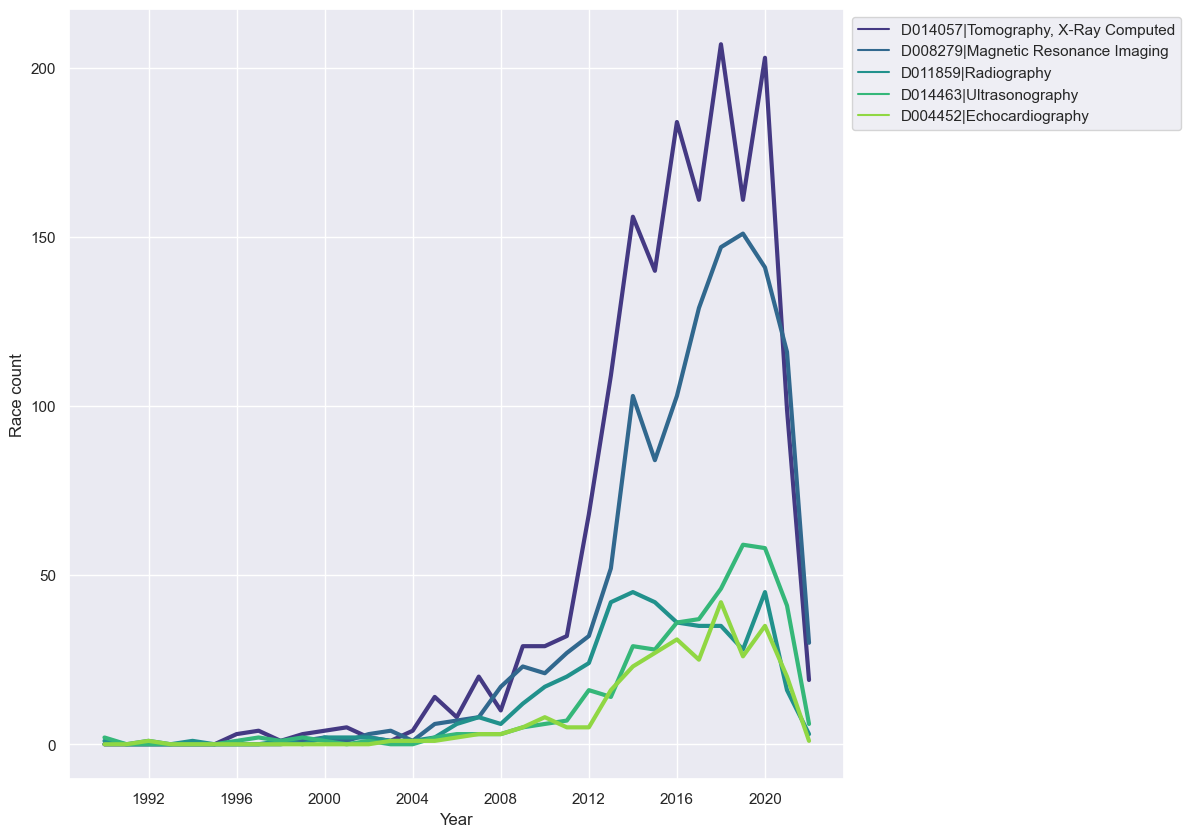

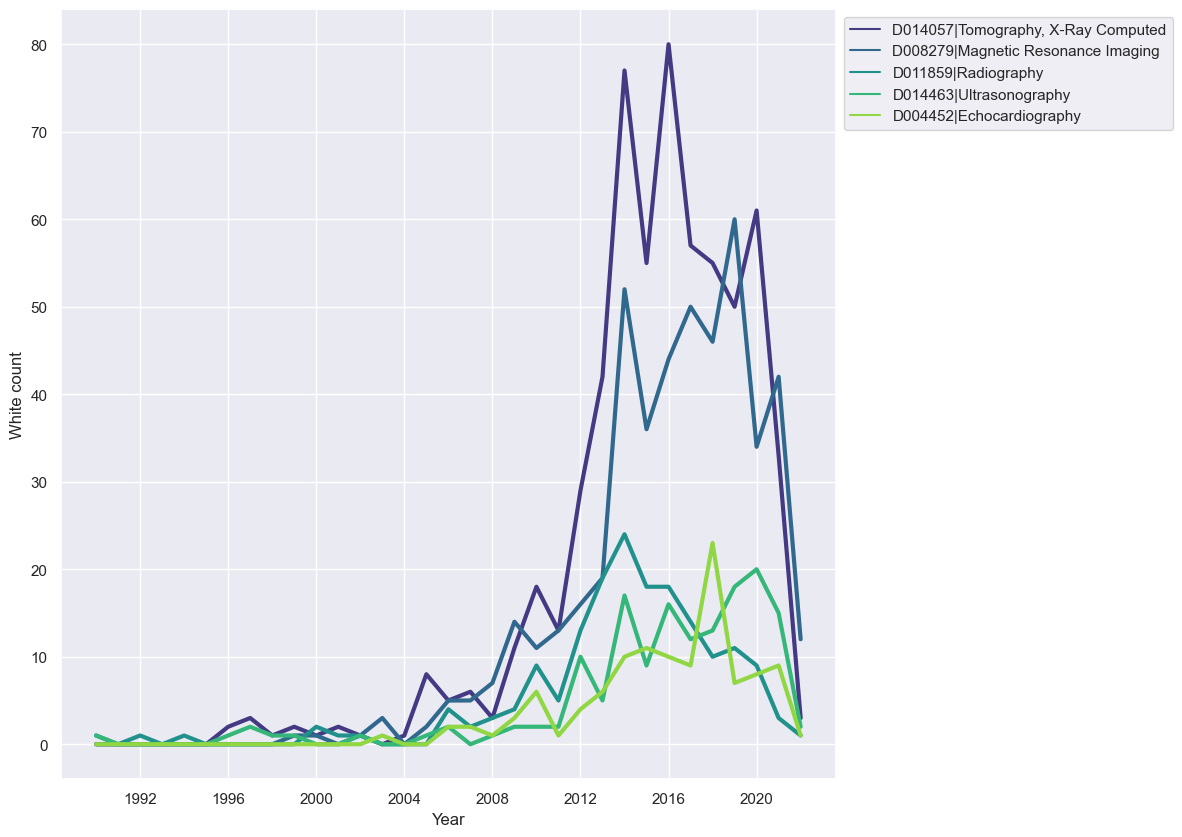

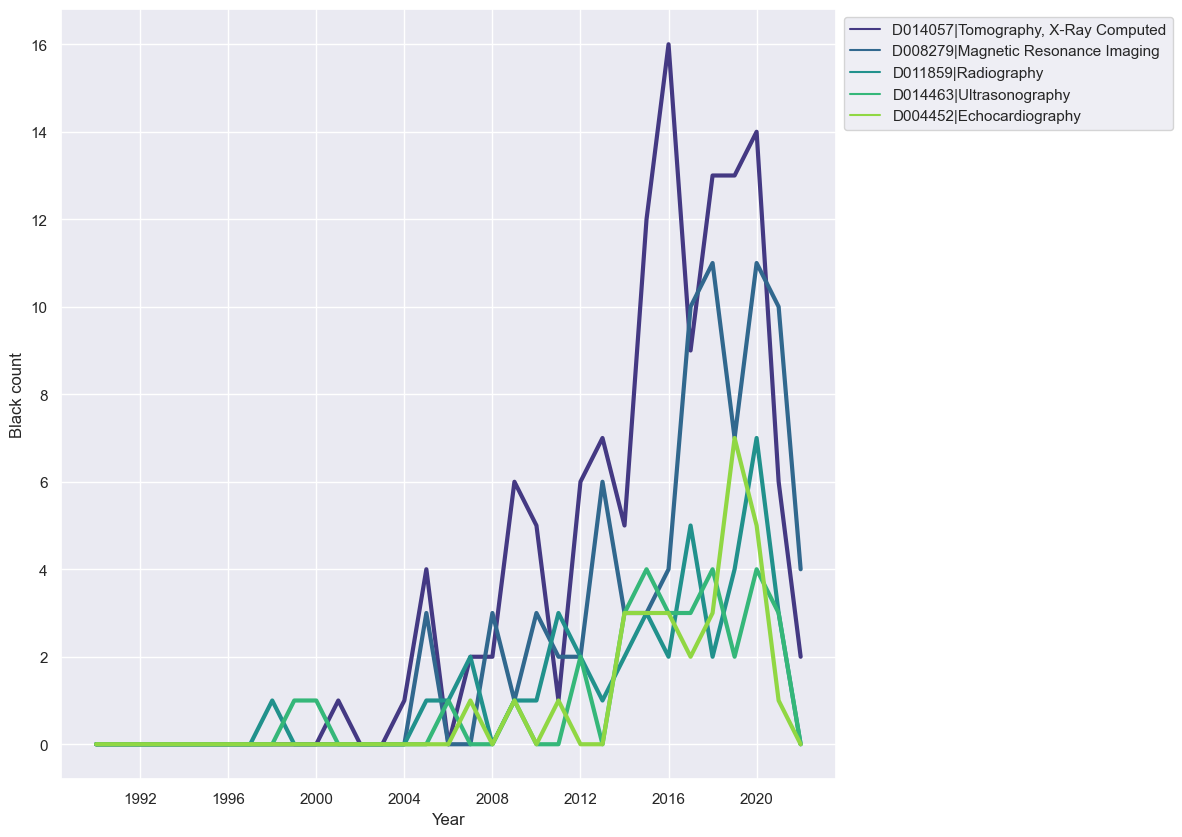

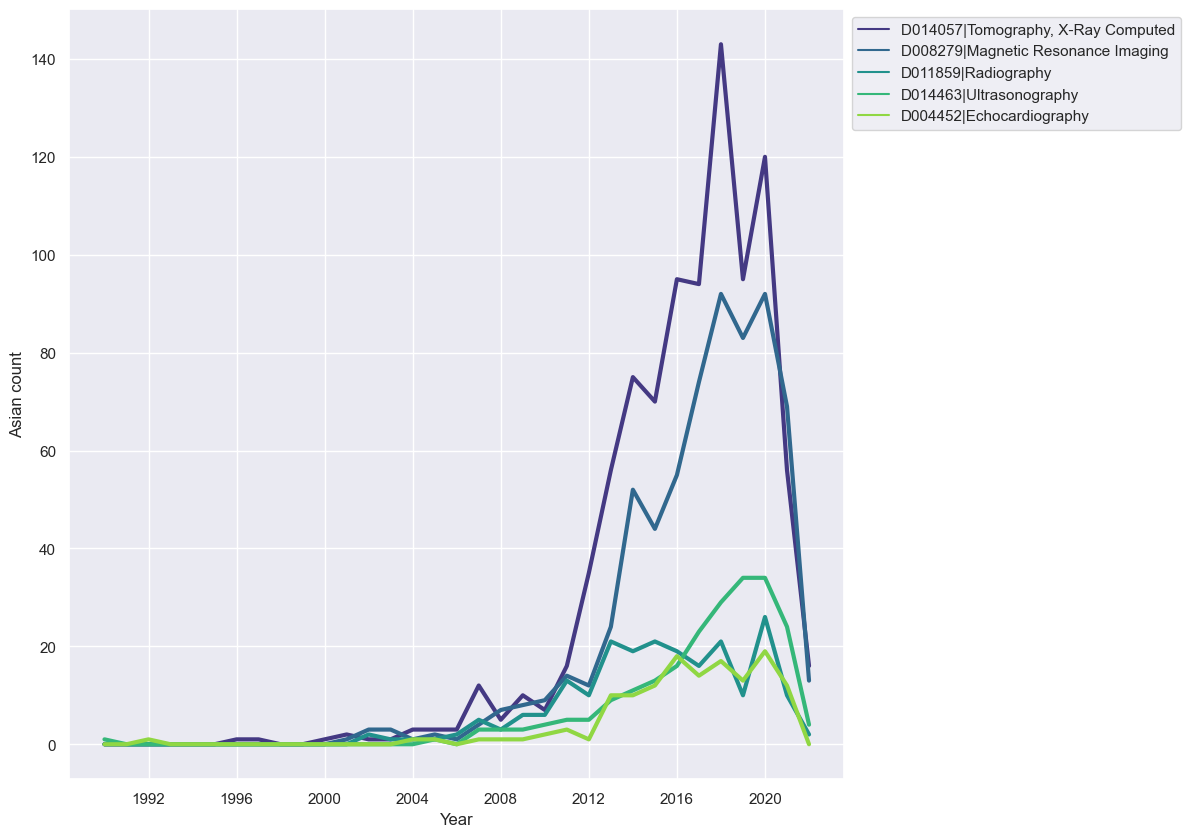

In [1146]:

# sns.barplot(x = 'year',y = 'race_count',data = res_df)
# sns.set(rc={'figure.figsize':(20,20)})
# plt.title("Race count over the years")
# plt.show()

sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(10,10)})

ax = sns.lineplot(data=res_df, x ='year', y = 'race_count',
                  hue='MESH', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Race count')
plt.xlabel('Year')
plt.show()


sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(10,10)})

ax = sns.lineplot(data=res_df, x ='year', y = 'white_count',
                  hue='MESH', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('White count')
plt.xlabel('Year')
plt.show()

sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(10,10)})

ax = sns.lineplot(data=res_df, x ='year', y = 'black_count',
                  hue='MESH', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Black count')
plt.xlabel('Year')
plt.show()


ax = sns.lineplot(data=res_df, x ='year', y = 'asian_count',
                  hue='MESH', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Asian count')
plt.xlabel('Year')
plt.show()

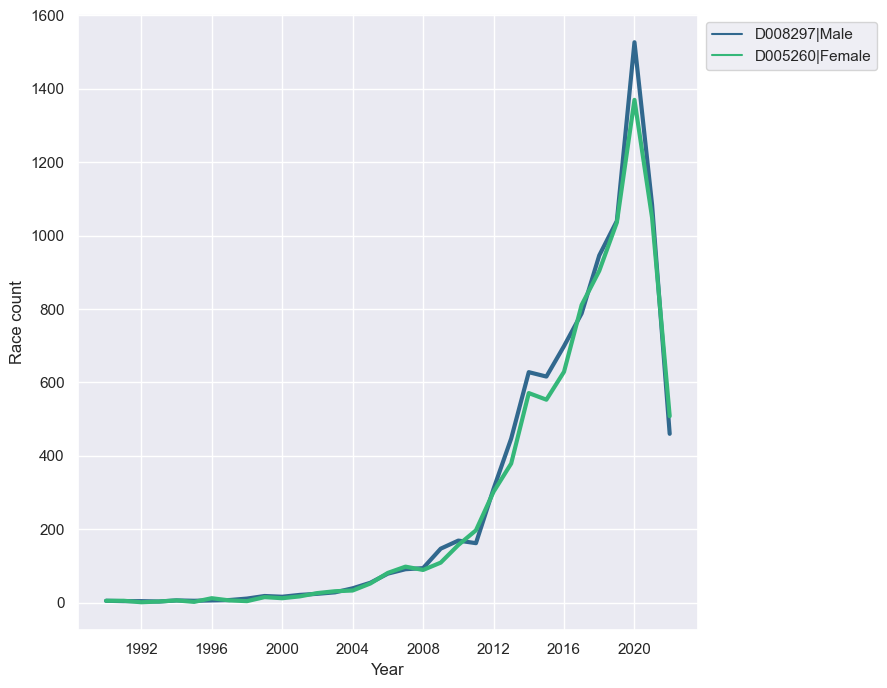

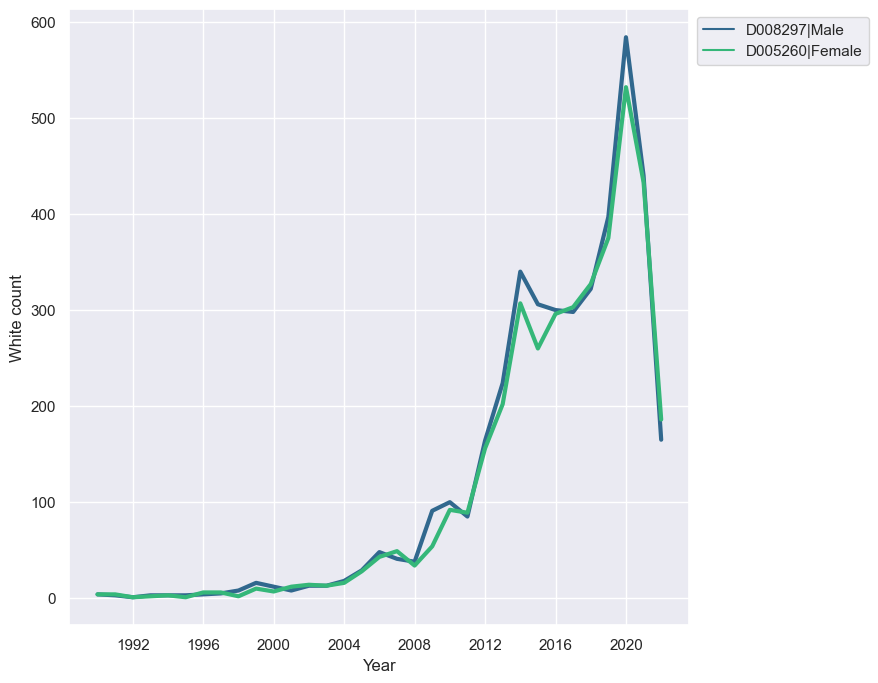

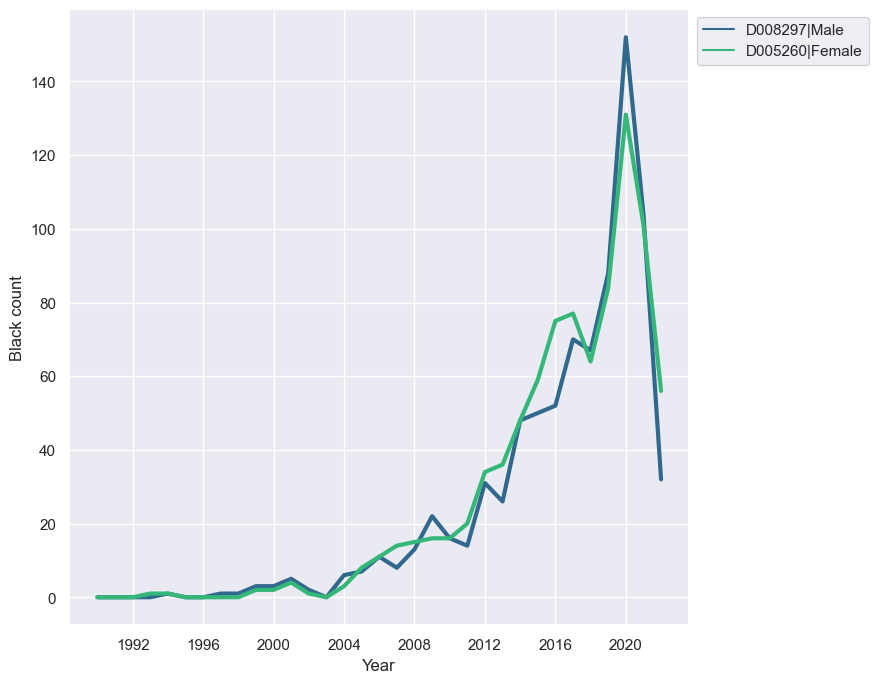

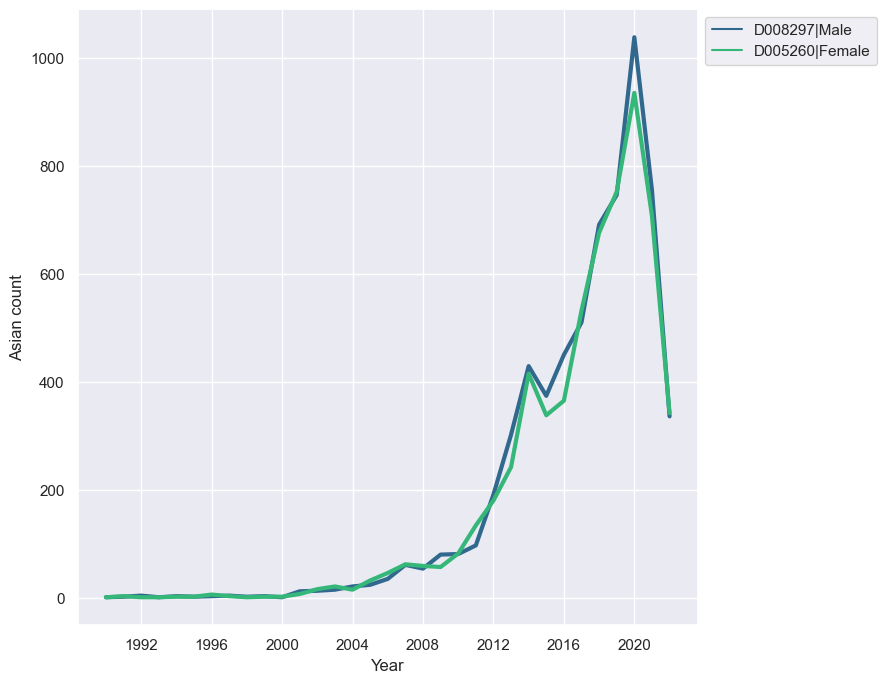

In [865]:
disease_mesh = 'D008297|Male'
print(f'Results for {disease_mesh}')
test_df_1 = get_stats_by_mesh_df(disease_mesh)
print('='*20)


disease_mesh = 'D005260|Female'
print(f'Results for {disease_mesh}')
test_df_2 = get_stats_by_mesh_df(disease_mesh)
print('='*20)

res_df = pd.concat([test_df_1, test_df_2])
res_df.head()

sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(8,8)})

ax = sns.lineplot(data=res_df, x ='year', y = 'race_count',
                  hue='MESH', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Race count')
plt.xlabel('Year')
plt.show()


sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(8,8)})

ax = sns.lineplot(data=res_df, x ='year', y = 'white_count',
                  hue='MESH', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('White count')
plt.xlabel('Year')
plt.show()

sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(8,8)})

ax = sns.lineplot(data=res_df, x ='year', y = 'black_count',
                  hue='MESH', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Black count')
plt.xlabel('Year')
plt.show()


ax = sns.lineplot(data=res_df, x ='year', y = 'asian_count',
                  hue='MESH', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Asian count')
plt.xlabel('Year')
plt.show()

Results for D000328|Adult
year	total_count	no_race_count	race_count	white_count	black_count	asian_count	latino_count	ameindian_count	islander_count


/var/folders/_3/np49sjc12t54plcrh2qv_xx40000gn/T/ipykernel_76901/281460603.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  journal_limit = (merged_df_no_subject_date['mesh_list'].astype(str).str.contains(f'({disease_mesh})', regex=True))


1990	33	28	5	3	0	2	0	0	0
1991	39	33	6	4	0	2	0	0	0
1992	34	32	2	0	0	2	0	0	0
1993	40	39	1	1	1	0	0	0	0
1994	38	33	5	2	1	2	0	0	0
1995	31	31	0	0	0	0	0	0	0
1996	44	40	4	1	0	3	0	0	0
1997	36	32	4	4	1	0	0	0	0
1998	44	41	3	2	0	1	0	0	0
1999	80	68	12	9	2	0	3	0	0
2000	60	49	11	7	3	1	1	0	0
2001	97	80	17	8	4	7	3	0	0
2002	98	79	19	10	2	9	1	0	0
2003	155	132	23	13	0	10	2	0	0
2004	171	140	31	13	5	14	2	0	0
2005	236	198	38	20	7	13	1	0	0
2006	288	231	57	37	8	16	4	0	0
2007	346	282	64	30	11	31	3	0	0
2008	425	369	56	14	12	25	12	0	0
2009	463	371	92	45	15	32	8	0	0
2010	617	500	117	59	17	39	13	0	0
2011	673	563	110	48	17	56	6	0	0
2012	831	640	191	97	17	74	16	0	0
2013	1074	805	269	134	30	114	19	2	0
2014	1299	900	399	201	42	174	22	1	0
2015	1546	1184	362	164	43	145	31	1	0
2016	1649	1251	398	169	50	190	24	1	0
2017	1885	1427	458	158	56	243	31	0	0
2018	2416	1838	578	190	53	340	42	0	0
2019	2657	2071	586	212	54	326	41	1	0
2020	4171	3361	810	298	98	420	69	2	2
2021	2822	2189	633	253	75	321	58	2	0
2022	1290	1000	290	108	32	1

/var/folders/_3/np49sjc12t54plcrh2qv_xx40000gn/T/ipykernel_76901/281460603.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  journal_limit = (merged_df_no_subject_date['mesh_list'].astype(str).str.contains(f'({disease_mesh})', regex=True))


1990	9	7	2	2	0	0	0	0	0
1991	9	9	0	0	0	0	0	0	0
1992	7	7	0	0	0	0	0	0	0
1993	9	8	1	1	0	0	0	0	0
1994	7	7	0	0	0	0	0	0	0
1995	8	7	1	1	0	1	0	0	0
1996	6	6	0	0	0	0	0	0	0
1997	8	8	0	0	0	0	0	0	0
1998	7	5	2	1	0	0	1	0	0
1999	14	9	5	5	0	0	0	0	0
2000	9	9	0	0	0	0	0	0	0
2001	14	9	5	4	2	1	2	0	0
2002	17	13	4	2	0	2	0	0	0
2003	18	14	4	1	0	2	1	0	0
2004	38	32	6	4	0	3	0	0	0
2005	48	34	14	6	2	5	1	0	0
2006	65	53	12	5	2	5	0	1	0
2007	75	62	13	6	2	5	3	0	0
2008	106	88	18	3	3	12	3	1	0
2009	136	105	31	19	1	9	4	0	0
2010	190	156	34	19	2	11	6	0	0
2011	192	150	42	27	5	14	3	0	0
2012	254	184	70	38	13	27	5	0	0
2013	308	230	78	38	10	32	7	1	0
2014	371	256	115	69	11	42	9	2	0
2015	468	346	122	66	18	44	5	0	0
2016	497	365	132	68	13	58	11	0	0
2017	556	423	133	59	10	62	13	3	0
2018	727	550	177	73	13	100	13	1	0
2019	866	630	236	94	33	119	22	2	0
2020	1339	1004	335	135	33	178	30	2	0
2021	1144	864	280	117	43	128	30	3	1
2022	614	472	142	67	20	66	14	2	0
8136


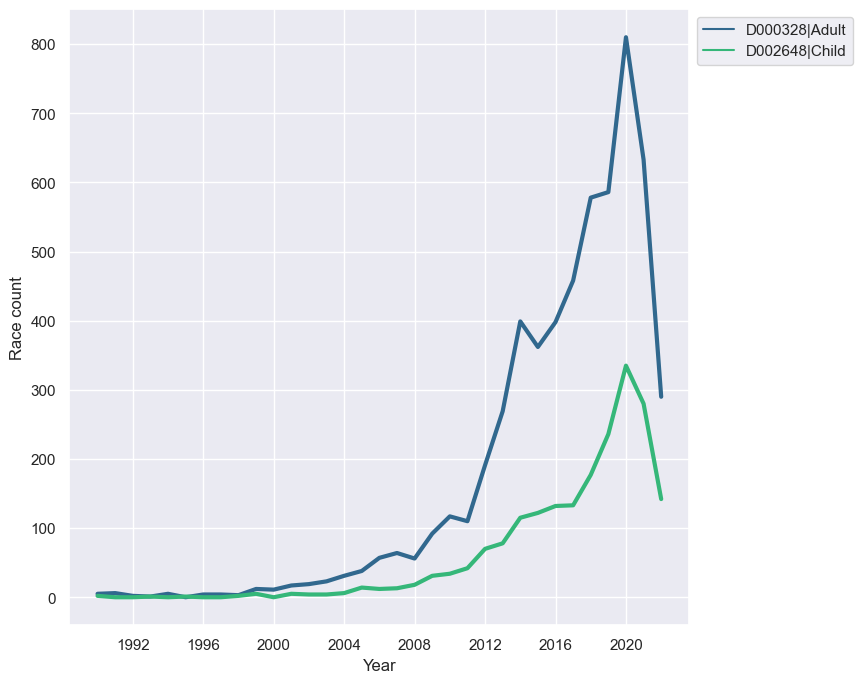

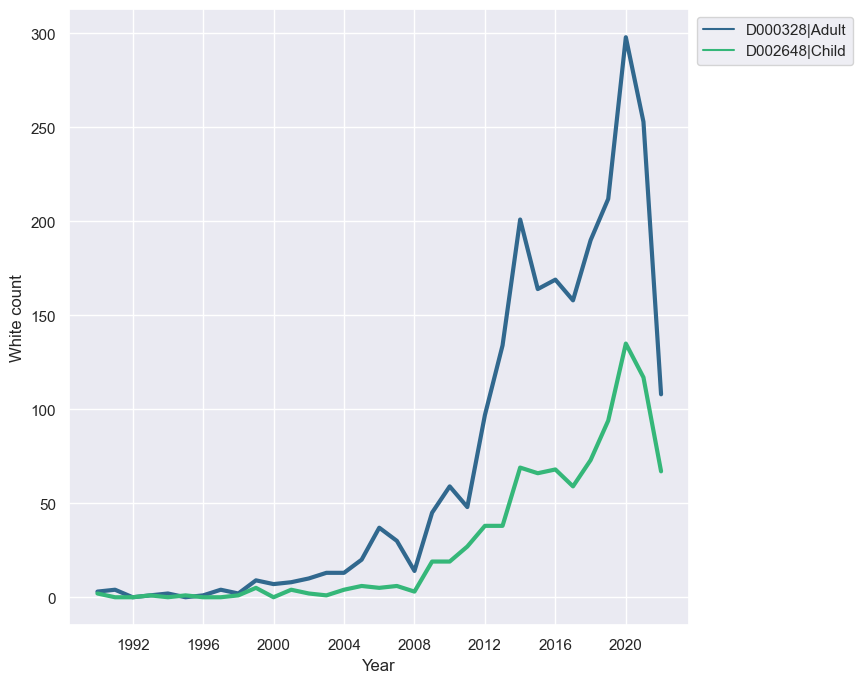

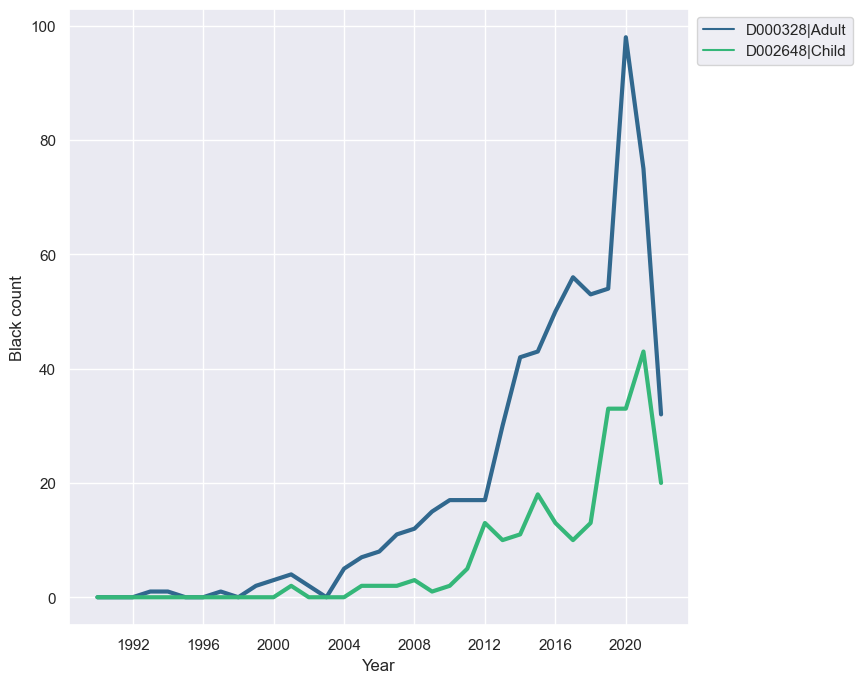

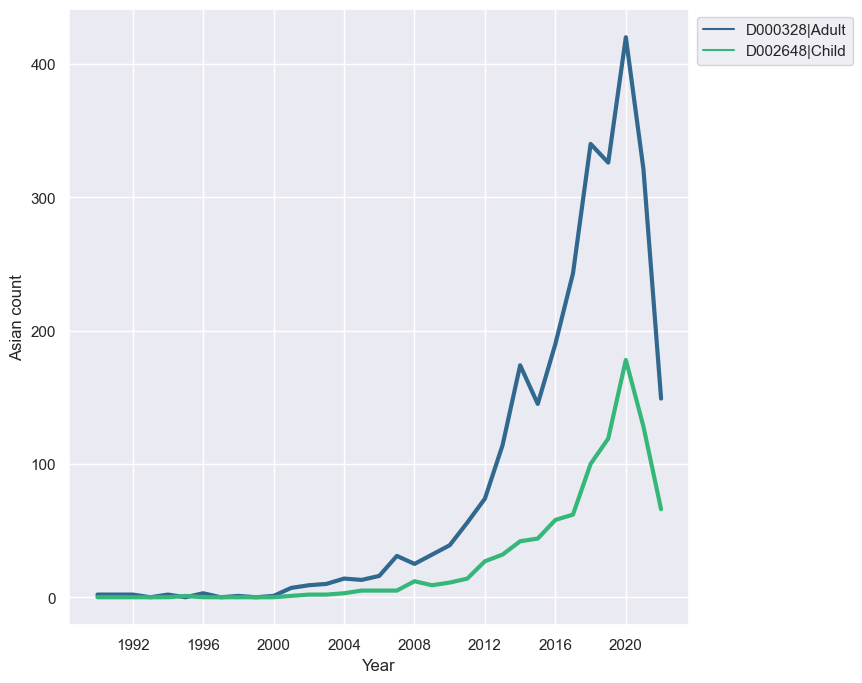

In [1147]:
disease_mesh = 'D000328|Adult'
print(f'Results for {disease_mesh}')
test_df_1 = get_stats_by_mesh_df(disease_mesh)
print('='*20)

disease_mesh = 'D002648|Child'
print(f'Results for {disease_mesh}')
test_df_2 = get_stats_by_mesh_df(disease_mesh)
print('='*20)


res_df = pd.concat([test_df_1, test_df_2])
res_df.head()

sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(8,8)})

ax = sns.lineplot(data=res_df, x ='year', y = 'race_count',
                  hue='MESH', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Race count')
plt.xlabel('Year')
plt.show()


sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(8,8)})

ax = sns.lineplot(data=res_df, x ='year', y = 'white_count',
                  hue='MESH', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('White count')
plt.xlabel('Year')
plt.show()

sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(8,8)})

ax = sns.lineplot(data=res_df, x ='year', y = 'black_count',
                  hue='MESH', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Black count')
plt.xlabel('Year')
plt.show()


ax = sns.lineplot(data=res_df, x ='year', y = 'asian_count',
                  hue='MESH', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Asian count')
plt.xlabel('Year')
plt.show()